---
# **BIOMEDICAL TEXT CLASSIFICATION USING LSTM, GRU AND BAHDANAU ATTENTION**
---

## About Dataset

The dataset contains a medical abstracts dataset (around 12 000 medical abstracts), describing 5 different classes of patient conditions : $neoplasms$, $digestive$ $system$ $diseases$, $nervous$ $system$ $diseases$, $cardiovascular$ $diseases$ and $general$ $pathological$ $conditions$.

The dataset can be used for text classification. It is available via https://github.com/sebischair/Medical-Abstracts-TC-Corpus and also Hugging Face : https://github.com/sebischair/Medical-Abstracts-TC-Corpus.

When citing this medical abstracts dataset in academic papers and theses, please use the following BibTeX entry:

author = {Schopf, Tim and Braun, Daniel and Matthes, Florian},
title = {Evaluating Unsupervised Text Classification: Zero-Shot and Similarity-Based Approaches},
year = {2023},
isbn = {9781450397629},
publisher = {Association for Computing Machinery},
address = {New York, NY, USA}.


This notebook focuses on exploratory data analysis and the model validation phase. Only models that perform satisfactorily during validation will be considered for the subsequent optimization phase. To address class imbalance, we rely on techniques such as SMOTE, Borderline-SMOTE, and class weighting.

In [1]:
import random
import pickle
import time
import re
import wandb
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModel
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.manifold import TSNE
import copy
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from tqdm import tqdm
import imageio
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# **I. Data preparation**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/medical_tc_train.csv')
data.head()

condition_label                                   medical_abstract
0                5  Tissue changes around loose prostheses. A cani...
1                1  Neuropeptide Y and neuron-specific enolase lev...
2                2  Sexually transmitted diseases of the colon, re...
3                1  Lipolytic factors associated with murine and h...
4                3  Does carotid restenosis predict an increased r...

In [5]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 0 to 11549
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   condition_label   11550 non-null  int64 
 1   medical_abstract  11550 non-null  object
dtypes: int64(1), object(1)
memory usage: 180.6+ KB


In [6]:
X = data["medical_abstract"].values

data['label'] = data['condition_label'] - 1
y = data["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 8085 samples
Validation set: 1732 samples
Test set: 1733 samples


In [7]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def tokenize(text):
    """
    Tokenizes English text by:
    - converting to lowercase
    - removing punctuation
    - removing numbers
    - removing English stopwords

    Args:
        text (str): Input English text.

    Returns:
        List[str]: List of cleaned tokens without stopwords and numbers.
    """
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    tokens = [word for word in tokens if word not in STOPWORDS]

    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
print(len(filtered_vocab))
VOCAB_SIZE =  len(filtered_vocab)

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}
print(word_to_index["malaria"])
print(index_to_word[201])

print(index_to_word[301])
print(word_to_index["host"])

20931
2430
rates
weight
1251


In [9]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]
        raw_text = self.raw_text_data[idx] if self.raw_text_data is not None else None
        return input_tensor, target_tensor, raw_text

In [10]:
X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])

[4642, 192, 195, 602, 20932, 129, 12864, 4181, 192, 3428, 1815, 20932, 4643, 685, 73, 724, 7571, 463, 1571, 1096, 977, 5536, 4644, 6, 10, 1085, 2114, 555, 78, 650, 574, 119, 129, 241, 195, 117, 6, 5943, 254, 1141, 18, 164, 117, 1, 11644, 62, 1639, 288, 5536, 1734, 1088, 1197, 62, 143, 5536, 1712, 1734, 1, 20932, 1197, 62, 165, 143, 3349, 73, 724, 1, 913, 38, 7997, 1350, 118, 264, 164, 117, 81, 169, 73, 724, 239, 2853, 7, 809, 44, 5536, 1735, 1, 243, 892, 143, 3628, 6, 28, 320, 100, 1640, 11, 8486, 713, 3771, 28, 1011, 539, 275, 875, 1466, 110, 76, 196, 3099, 2576, 20932, 53, 1, 16914, 2576, 1903, 125, 7, 11645, 195, 28, 800, 3772, 195, 602, 782, 1639, 7997, 1042, 5536, 3628, 51, 195, 28, 10, 848, 5363, 117, 831, 2576, 195, 117, 6628, 16915, 4644, 192, 5188, 126, 3429, 2, 849]


In [11]:
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

Train Tensor Shape: torch.Size([8085, 400]), Type: torch.int64
Validation Tensor Shape: torch.Size([1732, 400]), Type: torch.int64
Test Tensor Shape: torch.Size([1733, 400]), Type: torch.int64


In [12]:
batch_size = 16
train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


In [13]:
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

NUM_CLASSES = len(torch.unique(y_train_tensor))
VOCAB_SIZE = len(word_to_index)
print(NUM_CLASSES)

Training set size: 8085
Validation set size: 1732
Test set size: 1733
Combined dataset size: 9817
5


In [14]:
# --- BioMedNLP Setup ---
BiomedNLP_model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(BiomedNLP_model_name)
BiomedNLP = AutoModel.from_pretrained(BiomedNLP_model_name).to(device)

for param in BiomedNLP.parameters():
    param.requires_grad = True

BATCH_SIZE = 64

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention Mechanism.

    This class implements the Bahdanau attention mechanism as described in the paper:

    Args:
        hidden_dim (int): The hidden dimension of the GRU output.


    Attributes:
        W (nn.Linear): A linear layer for the transformation of the RNN outputs.
        v (nn.Linear): A linear layer for computing attention scores.
    """
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, rnn_outputs):
        """
        Apply the attention mechanism on the RNN outputs.

        Args:
            rnn_outputs (Tensor): The outputs of the RNN (GRU or LSTM).

        Returns:
            Tensor: The context vector computed by the attention mechanism.
        """
        score = torch.tanh(self.W(rnn_outputs))
        attn_weights = torch.softmax(self.v(score), dim=1)
        context = torch.sum(attn_weights * rnn_outputs, dim=1)
        return context

class BiomedNLP_GRU_Attention(nn.Module):
    """
    Model combining BiomedNLP embeddings, GRU layers, and Bahdanau Attention mechanism for multi-class classification.

    Args:
        bert_dim (int): The dimension of the PubMedBERT embeddings (usually 768).
        hidden_dim (int): The hidden dimension of the GRU layer.
        num_classes (int): The number of output classes for classification (default is 5 for multi-class classification).
        num_layers (int): The number of layers in the GRU (default is 1).
        dropout_prob (float): Dropout probability for regularization.

    Attributes:
        gru (nn.GRU): A bidirectional GRU layer.
        attention (BahdanauAttention): The Bahdanau attention mechanism.
        fc (nn.Linear): The fully connected layer to produce the output predictions.
        dropout (nn.Dropout): Dropout layer for regularization.
    """
    def __init__(self, bert_dim, hidden_dim, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.6):
        super(BiomedNLP_GRU_Attention, self).__init__()

        self.gru = nn.GRU(
            input_size=bert_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.

        Args:
            input_ids (Tensor): The tokenized input sequence IDs.
            attention_mask (Tensor): The attention mask to differentiate padding from real tokens.

        Returns:
            Tensor: The output logits for classification.
        """
        with torch.no_grad():
            bert_outputs = BiomedNLP(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeds = bert_outputs.last_hidden_state
        gru_out, _ = self.gru(bert_embeds)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)  # Logits for multi-class classification
        return output

class BiomedNLP_LSTM_Attention(nn.Module):
    """
    Model combining BiomedNLP embeddings, LSTM layers, and Bahdanau Attention mechanism for multi-class classification.

    Args:
        bert_dim (int): The dimension of the PubMedBERT embeddings (usually 768).
        hidden_dim (int): The hidden dimension of the LSTM layer.
        num_classes (int): Number of output classes.
        num_layers (int): Number of stacked LSTM layers.
        dropout_prob (float): Dropout probability for regularization.
    """
    def __init__(self, bert_dim, hidden_dim, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.6):
        super(BiomedNLP_LSTM_Attention, self).__init__()

        self.lstm = nn.LSTM(
            input_size=bert_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.

        Args:
            input_ids (Tensor): The tokenized input sequence IDs.
            attention_mask (Tensor): The attention mask to differentiate padding from real tokens.

        Returns:
            Tensor: The output logits for classification.
        """
        with torch.no_grad():
            bert_outputs = BiomedNLP(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeds = bert_outputs.last_hidden_state
        lstm_out, _ = self.lstm(bert_embeds)
        context = self.attention(lstm_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

class GRU_BahdanauAttention(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.6):
        super(GRU_BahdanauAttention, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        context = self.attention(gru_out)
        x = F.relu(context)
        x = self.dropout(x)
        output = self.fc(x)
        return output

class LSTM_BahdanauAttention(nn.Module):
    """
    Bidirectional LSTM with Bahdanau Attention Mechanism.

    Args:
        embedding_matrix (Tensor): Pre-trained embedding matrix.
        hidden_dim (int): Hidden size of the LSTM.
        num_classes (int): Number of output classes.
        num_layers (int): Number of LSTM layers.
        dropout_prob (float): Dropout rate.
    """
    def __init__(self, embedding_matrix, hidden_dim, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.6):
        super(LSTM_BahdanauAttention, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        context = self.attention(lstm_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

In [16]:
class BiomedNLPDataset(Dataset):
    """
    Dataset class for multi-class classification using PubMedBERT embeddings.

    Args:
        texts (list of str): A list of raw text sequences.
        labels (list of int): A list of integer labels (0-4) corresponding to each text.
        tokenizer (transformers tokenizer): A tokenizer to preprocess the text data.
        max_length (int): Maximum length for padding/truncation. Default is 500.

    Attributes:
        texts (list of str): The raw text data.
        encodings (dict): Tokenized text data with input IDs and attention masks.
        labels (Tensor): Tensor of integer labels for the classification task.
    """

    def __init__(self, texts, labels, tokenizer, max_length=500):
        self.texts = texts
        self.encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: Contains input IDs, attention masks, and the corresponding label and raw text.
        """
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        item['text'] = self.texts[idx]
        return item

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.labels)

In [17]:
clip = 5

def count_parameters(model):
    """
    Count the number of trainable parameters in the model.
    Args:
        model: The model whose parameters are to be counted.
    Returns:
        Total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)

        loss = criterion(logits, labels)
        loss.backward()

        # --- Apply gradient clipping here ---
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().detach().numpy()
        total_correct += np.sum(preds == labels.cpu().numpy())
        total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_samples
    return avg_loss, avg_accuracy

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels_cpu)

    val_loss /= len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return balanced_acc, f1, val_loss

def test_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test dataset, calculating loss, accuracy, F1-score, precision, recall, and balanced accuracy.
    Args:
        model: The model to evaluate.
        test_loader: DataLoader for the test dataset.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU device.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, recall, and precision.
    """
    model.eval()
    total_loss = 0
    total_accuracy = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target_tensor = batch['labels'].to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, target_tensor)
            total_loss += loss.item()

            batch_accuracy = accuracy_score(target_tensor.cpu(), torch.argmax(output, dim=1).cpu())
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            labels = target_tensor.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch and return average loss and balanced accuracy.
    """
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        if len(batch) == 3:
            inputs, targets, _ = batch
        else:
            inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = targets.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    avg_loss = total_loss / len(train_loader)
    balanced_acc = balanced_accuracy_score(np.array(all_labels), np.array(all_preds))

    return avg_loss, balanced_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch and return average loss, balanced accuracy, and F1-score.
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                inputs, targets, _ = batch
            else:
                inputs, targets = batch

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = targets.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(val_loader)
    balanced_acc = balanced_accuracy_score(np.array(all_labels), np.array(all_preds))
    f1 = f1_score(np.array(all_labels), np.array(all_preds), average="weighted", zero_division=0)

    return avg_loss, balanced_acc, f1

def test_epoch(model, test_loader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        test_loader: DataLoader for test data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, Recall, and Precision.
    """
    model.eval()  # Set model to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass
            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = accuracy_score(target_tensor.cpu(), torch.argmax(output, dim=1).cpu())

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

def custom_collate_fn(batch):
    """
    Custom collate function to combine input tensors, target tensors, and raw texts into a batch.
    Stacks inputs and targets into tensors, returns raw texts as a list.

    Args:
        batch (list): List of tuples containing input tensor, target tensor, and raw text.

    Returns:
        tuple: Stacked inputs tensor, stacked targets tensor, and list of raw texts.
    """
    inputs, targets, raw_texts = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    return inputs, targets, list(raw_texts)

In [18]:
def load_glove_embeddings(glove_path, word_to_index, embedding_dim):
    """
    Loads GloVe embeddings (.txt format) and returns an embedding matrix.

    Args:
        glove_path (str): Path to the GloVe .txt file (e.g., glove.6B.300d.txt).
        word_to_index (dict): Mapping from words to their index in the vocabulary.
        embedding_dim (int): Dimension of the embeddings (e.g., 300).

    Returns:
        torch.Tensor: Embedding matrix of shape (vocab_size, embedding_dim).
    """
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

def load_fasttext_embeddings(vec_path, word_to_index, embedding_dim=300):
    """
    Loads FastText embeddings from a .txt or .vec file and returns an embedding matrix.

    Note:
        The .txt or .vec format contains a header (num_tokens, dimension),
        followed by one word vector per line in the format: word val1 val2 ... valN.

    Args:
        vec_path (str): Path to the FastText .txt or .vec file (e.g., cc.en.300.txt or cc.en.300.vec).
        word_to_index (dict): Mapping from words to their index in the vocabulary.
        embedding_dim (int): Dimensionality of the embeddings (e.g., 300).

    Returns:
        torch.Tensor: Embedding matrix of shape (vocab_size, embedding_dim).
    """
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')

    with open(vec_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        header = f.readline()  # header contains: num_words dim
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) < embedding_dim + 1:
                continue  # skip malformed lines
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

In [19]:
BATCH_SIZE = 64

# --- Load Data ---
train_dataset = BiomedNLPDataset(X_train.tolist(), y_train, tokenizer)
val_dataset = BiomedNLPDataset(X_val.tolist(), y_val, tokenizer)
test_dataset = BiomedNLPDataset(X_test.tolist(), y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Combine the training and validation datasets (for test)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

### **Applying SMOTE for addressing imbalance problem**

In [ ]:
X_train_np = X_train_tensor.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()

original_text_map = {tuple(vec): text for vec, text in zip(X_train_np, X_train)}

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled_np, y_resampled_np = smote.fit_resample(X_train_np, y_train_np)

raw_text_resampled = []
for vec in X_resampled_np:
    key = tuple(vec)
    if key in original_text_map:
        raw_text_resampled.append(original_text_map[key])
    else:
        raw_text_resampled.append("[Synthetic sample - no raw text]")

X_resampled_tensor = torch.tensor(X_resampled_np, dtype=torch.float)
y_resampled_tensor = torch.tensor(y_resampled_np, dtype=torch.long)

train_dataset_smote = BiomedNLPDataset(raw_text_resampled, y_resampled_np, tokenizer)
val_dataset = BiomedNLPDataset(X_val.tolist(), y_val, tokenizer)
test_dataset = BiomedNLPDataset(X_test.tolist(), y_test, tokenizer)

train_loader_smote = DataLoader(train_dataset_smote, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **II. GRU + Bahdanau + BioMedNLP**

## **II.1 Optimization Phase**

In [20]:
BERT_DIM = 768
HIDDEN_DIM = 156
DROPOUT = 0.4

#### **Optimizer selection**

In [ ]:
num_epochs = 10
learning_rate = 5e-5

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
results = []

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW
}

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = BiomedNLP_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    print(model)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        val_f1s.append(f1)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Opt: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

    all_train_losses[optimizer_name] = train_losses
    all_val_losses[optimizer_name] = val_losses
    all_train_accs[optimizer_name] = train_accs
    all_val_accs[optimizer_name] = val_accs

    label = f"Batch={BATCH_SIZE} | Optimizer={optimizer_name} | HD={HIDDEN_DIM} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with optimizer: Adam
BiomedNLP_GRU_Attention(
  (gru): GRU(768, 156, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=312, out_features=156, bias=True)
    (v): Linear(in_features=156, out_features=1, bias=False)
  )
  (fc): Linear(in_features=312, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Total trainable parameters: 917285
Opt: Adam | Epoch 1/10 - TL: 1.5859, VL: 1.4977, TA: 27.19%, VA: 53.28%, F1: 48.76%, Time: 4.72 min
Opt: Adam | Epoch 2/10 - TL: 1.4316, VL: 1.2785, TA: 43.07%, VA: 63.57%, F1: 49.62%, Time: 4.77 min
Opt: Adam | Epoch 3/10 - TL: 1.1167, VL: 0.9549, TA: 56.75%, VA: 67.05%, F1: 56.20%, Time: 4.76 min
Opt: Adam | Epoch 4/10 - TL: 0.9201, VL: 0.8609, TA: 60.57%, VA: 68.60%, F1: 59.73%, Time: 4.76 min
Opt: Adam | Epoch 5/10 - TL: 0.8614, VL: 0.8296, TA: 61.87%, VA: 69.22%, F1: 60.81%, Time: 4.76 min
Opt: Adam | Epoch 6/10 - TL: 0.8325, VL: 0.8129, TA: 62.62%, VA: 69.81%, F1: 61.6

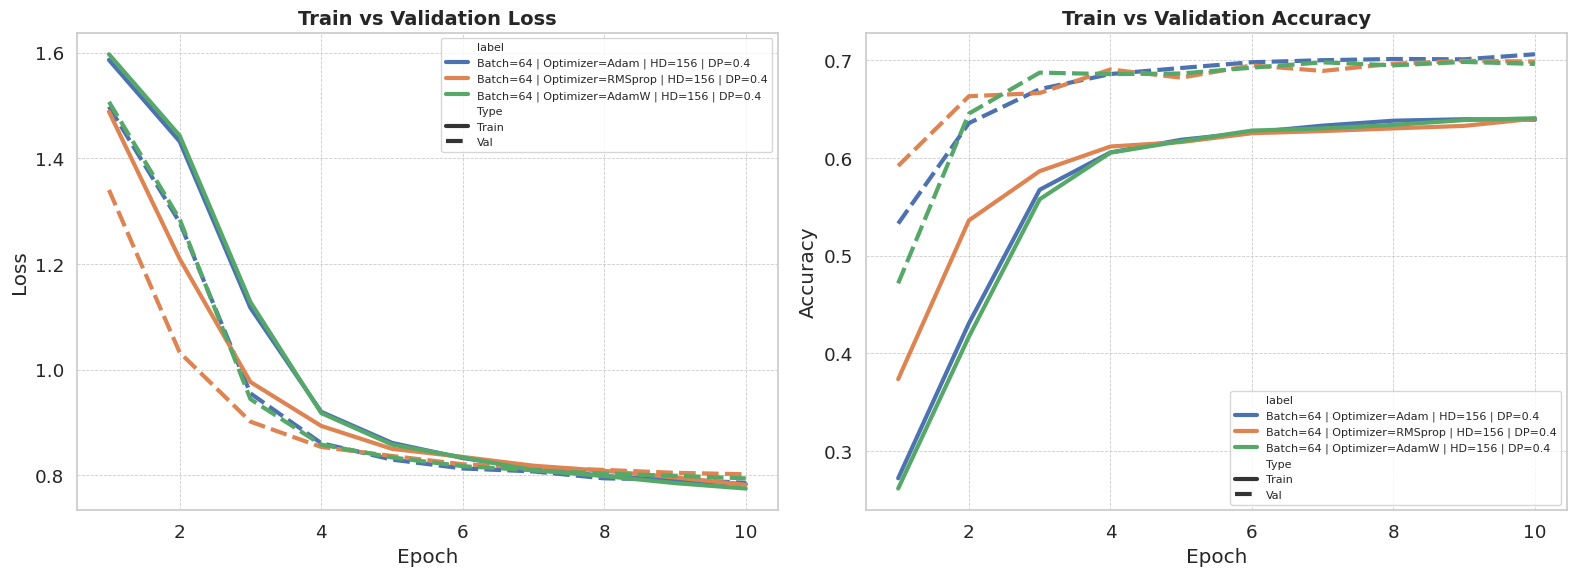

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Learning rate value selection**

In [ ]:
learning_rates = [3e-5, 8e-5, 5e-5]
optimizer_name = 'RMSprop'
optimizer_class = optim.RMSprop
results = []
num_epochs = 10

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop optimizer, learning rate = {lr}")

    model = BiomedNLP_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    print(model)

    optimizer = optimizer_class(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(f1)

        print(
            f"LR: {lr:.1e} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {(time.time() - start_time)/60:.2f} min"
        )

    label = f"LR={lr:.1e} | Optimizer={optimizer_name} | HD={HIDDEN_DIM} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with RMSprop optimizer, learning rate = 3e-05
BiomedNLP_GRU_Attention(
  (gru): GRU(768, 156, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=312, out_features=156, bias=True)
    (v): Linear(in_features=156, out_features=1, bias=False)
  )
  (fc): Linear(in_features=312, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
LR: 3.0e-05 | Epoch 1/10 - TL: 1.5598, VL: 1.4760, TA: 29.55%, VA: 57.38%, F1: 48.63%, Time: 4.55 min
LR: 3.0e-05 | Epoch 2/10 - TL: 1.4432, VL: 1.3487, TA: 42.50%, VA: 62.50%, F1: 50.27%, Time: 4.54 min
LR: 3.0e-05 | Epoch 3/10 - TL: 1.2790, VL: 1.1564, TA: 52.75%, VA: 65.10%, F1: 53.31%, Time: 4.53 min
LR: 3.0e-05 | Epoch 4/10 - TL: 1.0934, VL: 0.9940, TA: 57.27%, VA: 67.40%, F1: 56.29%, Time: 4.54 min
LR: 3.0e-05 | Epoch 5/10 - TL: 0.9734, VL: 0.9113, TA: 59.68%, VA: 68.00%, F1: 58.87%, Time: 4.54 min
LR: 3.0e-05 | Epoch 6/10 - TL: 0.9094, VL: 0.8728, TA: 60.75%, VA: 68.14%, F1: 59

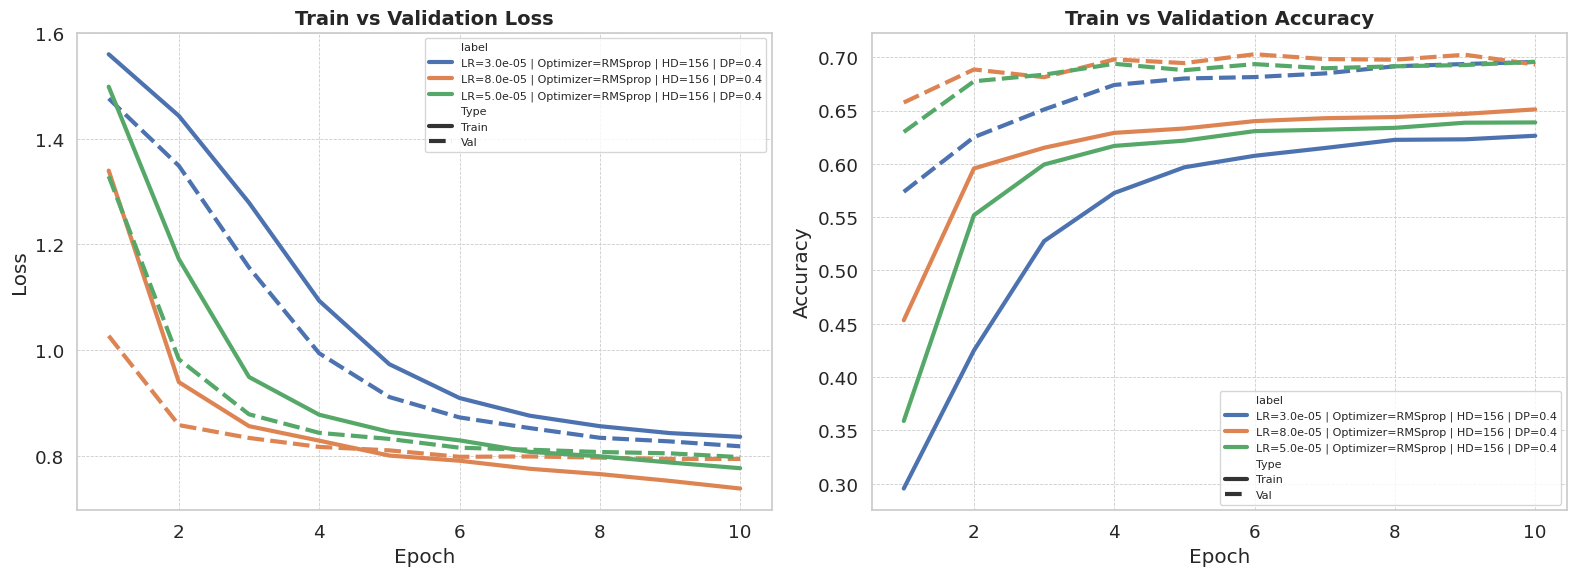

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Batch size value selection**

In [ ]:
batch_sizes = [8, 32, 64]
learning_rate = 2e-5
num_epochs = 10

results = []

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")

    # Create DataLoader with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = BiomedNLP_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(f1)

        print(
            f"BS: {batch_size} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {(time.time() - start_time)/60:.2f} min"
        )

    label = f"LR={learning_rate:.1e} | Batch={batch_size} | HD={HIDDEN_DIM} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with batch size: 8
BS: 8 | Epoch 1/10 - TL: 1.5477, VL: 1.4362, TA: 32.74%, VA: 52.87%, F1: 45.87%, Time: 5.18 min
BS: 8 | Epoch 2/10 - TL: 1.2680, VL: 1.0216, TA: 51.58%, VA: 66.41%, F1: 56.34%, Time: 5.16 min
BS: 8 | Epoch 3/10 - TL: 0.9607, VL: 0.8911, TA: 59.69%, VA: 67.78%, F1: 60.91%, Time: 5.17 min
BS: 8 | Epoch 4/10 - TL: 0.8870, VL: 0.8591, TA: 61.93%, VA: 68.44%, F1: 60.91%, Time: 5.17 min
BS: 8 | Epoch 5/10 - TL: 0.8537, VL: 0.8424, TA: 62.96%, VA: 68.36%, F1: 61.02%, Time: 5.17 min
BS: 8 | Epoch 6/10 - TL: 0.8317, VL: 0.8349, TA: 63.64%, VA: 68.82%, F1: 61.47%, Time: 5.16 min
BS: 8 | Epoch 7/10 - TL: 0.8146, VL: 0.8314, TA: 64.13%, VA: 68.72%, F1: 62.22%, Time: 5.17 min
BS: 8 | Epoch 8/10 - TL: 0.8034, VL: 0.8275, TA: 64.77%, VA: 69.77%, F1: 62.79%, Time: 5.17 min
BS: 8 | Epoch 9/10 - TL: 0.7945, VL: 0.8229, TA: 65.15%, VA: 69.33%, F1: 61.71%, Time: 5.17 min
BS: 8 | Epoch 10/10 - TL: 0.7942, VL: 0.8230, TA: 64.94%, VA: 69.10%, F1: 62.61%, Time: 5.17 min

🔹 Train

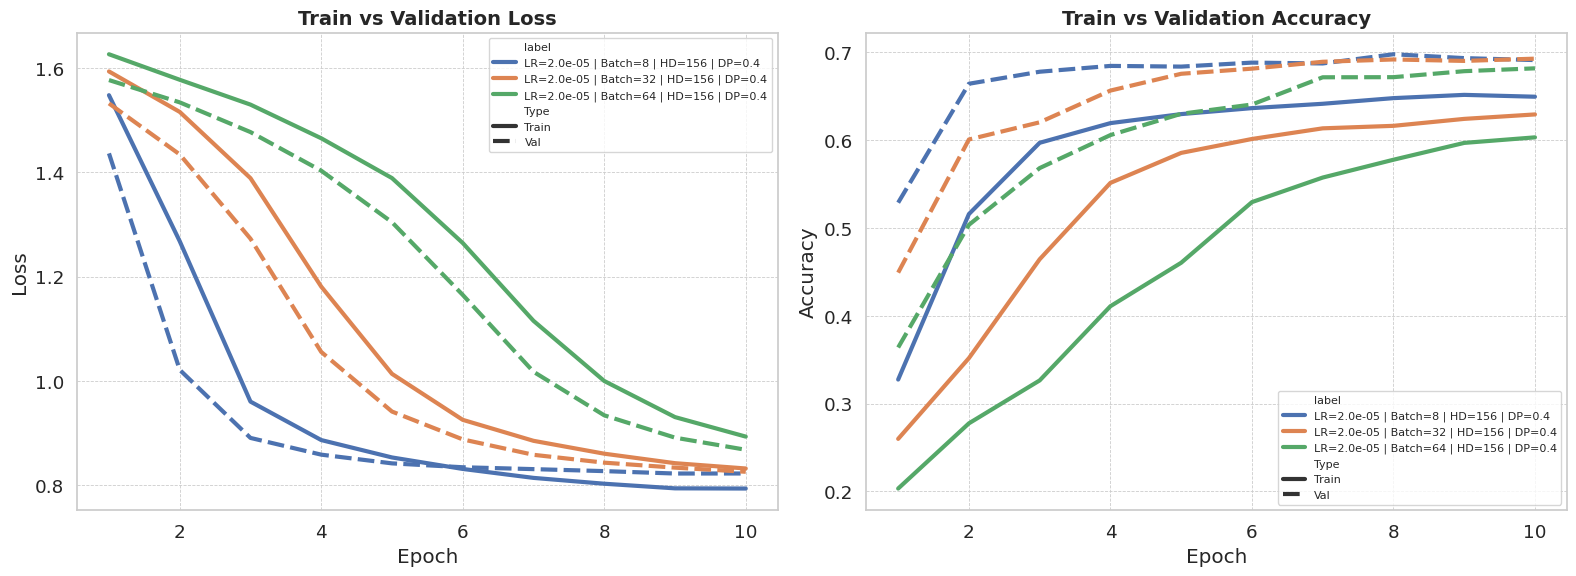

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Hidden dimension value selection**

In [ ]:
hidden_dims = [256, 167, 400]
learning_rate = 3e-5
batch_size = 16
num_epochs = 10
results = []

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden dimension: {hidden_dim}")

    # Dataloaders remain the same since batch_size is fixed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Pass the loop variable `hidden_dim` instead of a fixed HIDDEN_DIM
    model = BiomedNLP_GRU_Attention(BERT_DIM, hidden_dim, dropout_prob=DROPOUT).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(f1)

        print(
            f"HD: {hidden_dim} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {(time.time() - start_time)/60:.2f} min"
        )

    label = f"LR={learning_rate:.1e} | BS={batch_size} | HD={hidden_dim} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with hidden dimension: 256
HD: 256 | Epoch 1/10 - TL: 1.4988, VL: 1.2643, TA: 36.17%, VA: 63.42%, F1: 53.16%, Time: 5.08 min
HD: 256 | Epoch 2/10 - TL: 1.0354, VL: 0.8878, TA: 58.52%, VA: 68.97%, F1: 58.73%, Time: 5.12 min
HD: 256 | Epoch 3/10 - TL: 0.8688, VL: 0.8373, TA: 61.68%, VA: 68.75%, F1: 60.60%, Time: 5.12 min
HD: 256 | Epoch 4/10 - TL: 0.8311, VL: 0.8254, TA: 63.38%, VA: 68.80%, F1: 61.58%, Time: 5.12 min
HD: 256 | Epoch 5/10 - TL: 0.8033, VL: 0.8171, TA: 63.60%, VA: 69.73%, F1: 61.89%, Time: 5.12 min
HD: 256 | Epoch 6/10 - TL: 0.7890, VL: 0.8210, TA: 64.45%, VA: 69.55%, F1: 62.84%, Time: 5.12 min
HD: 256 | Epoch 7/10 - TL: 0.7742, VL: 0.8077, TA: 64.48%, VA: 69.91%, F1: 62.02%, Time: 5.12 min
HD: 256 | Epoch 8/10 - TL: 0.7563, VL: 0.7992, TA: 65.42%, VA: 70.14%, F1: 62.44%, Time: 5.12 min
HD: 256 | Epoch 9/10 - TL: 0.7472, VL: 0.8184, TA: 65.75%, VA: 68.15%, F1: 61.66%, Time: 5.12 min
HD: 256 | Epoch 10/10 - TL: 0.7397, VL: 0.8080, TA: 65.90%, VA: 68.74%, F1: 62.

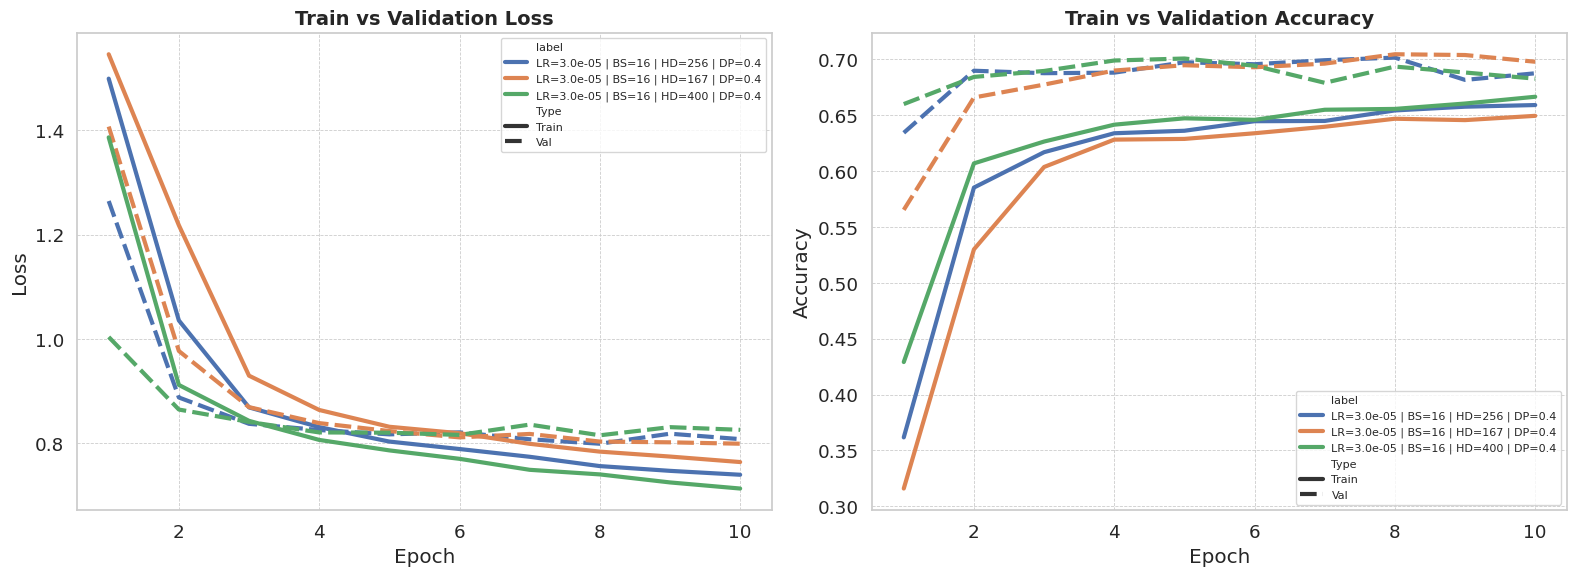

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Dropout value selection**

In [ ]:
dropout_values = [0.3, 0.5, 0.7]
hidden_dims = [154]
learning_rate = 3e-5
batch_size = 64
num_epochs = 10
results = []

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for hidden_dim in hidden_dims:
    for dropout_prob in dropout_values:
        print(f"\n🔹 Training with hidden_dim={hidden_dim}, dropout={dropout_prob}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = BiomedNLP_GRU_Attention(BERT_DIM, hidden_dim, dropout_prob=dropout_prob).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        val_f1s = []

        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(f1)

            print(
                f"HD={hidden_dim}, DP={dropout_prob} | Epoch {epoch+1}/{num_epochs} - "
                f"TL={train_loss:.4f}, VL={val_loss:.4f}, "
                f"TA={train_acc:.2%}, VA={val_acc:.2%}, F1={f1:.2%}, "
                f"Time={(time.time() - start_time)/60:.2f} min"
            )

        label = f"LR={learning_rate:.1e} | BS={batch_size} | HD={hidden_dim} | DP={dropout_prob}"
        for epoch in range(num_epochs):
            results.append({
                "epoch": epoch + 1,
                "label": label,
                "train_loss": train_losses[epoch],
                "val_loss": val_losses[epoch],
                "train_acc": train_accs[epoch],
                "val_acc": val_accs[epoch],
                "val_f1": val_f1s[epoch]
            })


🔹 Training with hidden_dim=154, dropout=0.3
HD=154, DP=0.3 | Epoch 1/10 - TL=1.5928, VL=1.5410, TA=25.49%, VA=47.38%, F1=45.75%, Time=4.61 min
HD=154, DP=0.3 | Epoch 2/10 - TL=1.5089, VL=1.4409, TA=37.72%, VA=59.68%, F1=51.79%, Time=4.71 min
HD=154, DP=0.3 | Epoch 3/10 - TL=1.3887, VL=1.2856, TA=48.94%, VA=62.66%, F1=54.30%, Time=4.70 min
HD=154, DP=0.3 | Epoch 4/10 - TL=1.1910, VL=1.0506, TA=56.36%, VA=66.48%, F1=56.34%, Time=4.71 min
HD=154, DP=0.3 | Epoch 5/10 - TL=0.9953, VL=0.9261, TA=59.78%, VA=67.27%, F1=57.27%, Time=4.71 min
HD=154, DP=0.3 | Epoch 6/10 - TL=0.9130, VL=0.8746, TA=60.37%, VA=68.61%, F1=61.42%, Time=4.71 min
HD=154, DP=0.3 | Epoch 7/10 - TL=0.8742, VL=0.8503, TA=61.47%, VA=68.26%, F1=60.37%, Time=4.71 min
HD=154, DP=0.3 | Epoch 8/10 - TL=0.8455, VL=0.8345, TA=62.25%, VA=68.68%, F1=60.61%, Time=4.71 min
HD=154, DP=0.3 | Epoch 9/10 - TL=0.8285, VL=0.8270, TA=62.78%, VA=68.97%, F1=60.34%, Time=4.72 min
HD=154, DP=0.3 | Epoch 10/10 - TL=0.8179, VL=0.8217, TA=63.04%, 

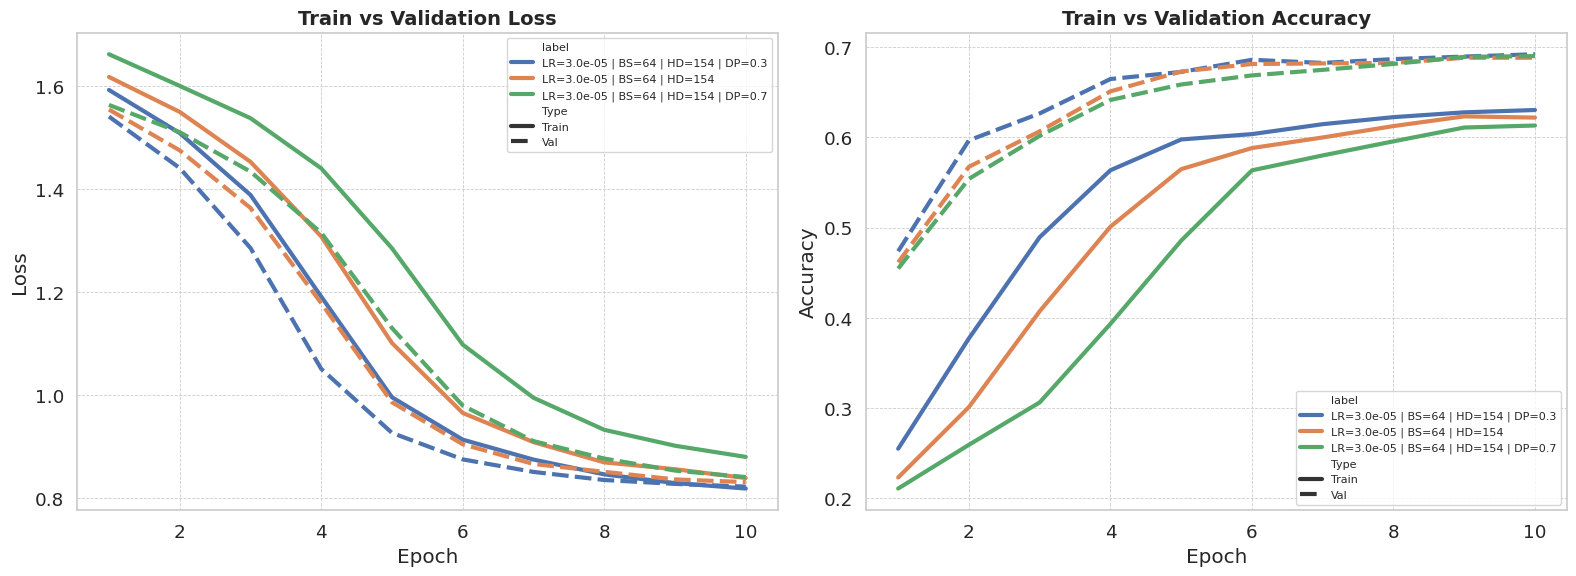

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

## **II.2 Test Phase**

/tmp/ipython-input-54-3554093930.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_test_labels, y='disease', palette="husl", order=df_test_labels['disease'].value_counts().index)


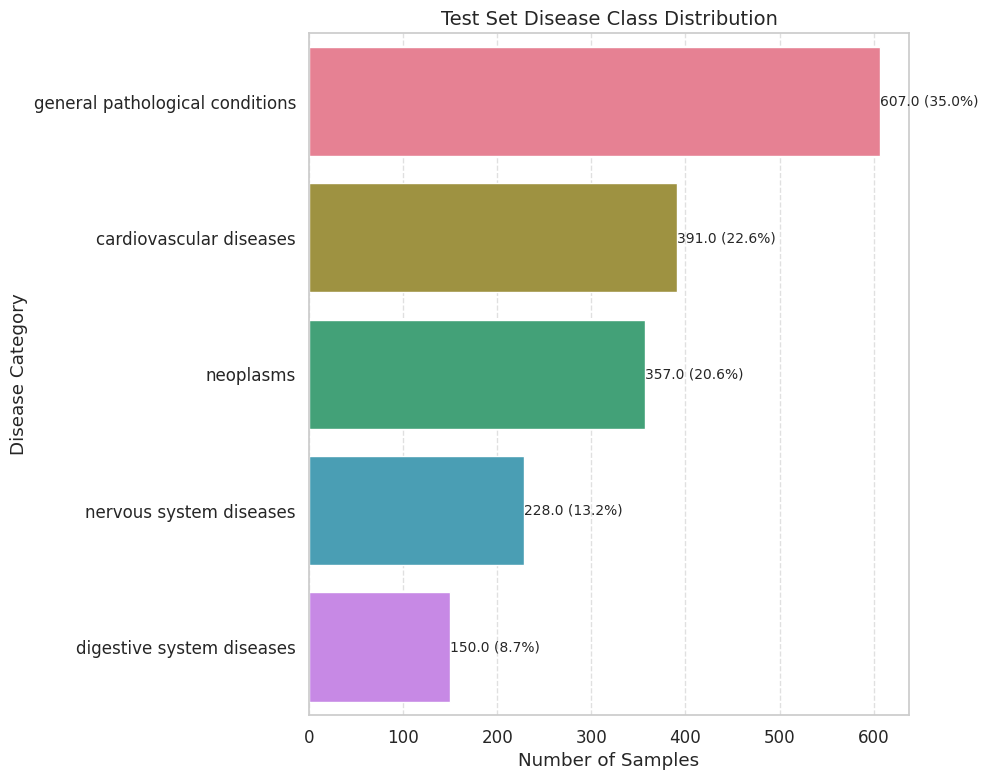

In [ ]:
disease_map = {
    0: 'neoplasms',
    1: 'digestive system diseases',
    2: 'nervous system diseases',
    3: 'cardiovascular diseases',
    4: 'general pathological conditions'
}

# Convert labels to names
label_names = [disease_map[int(label)] for label in y_test]
df_test_labels = pd.DataFrame({'disease': label_names})

# Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Plot setup
fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # Wider figure

# Plot horizontal bar chart (sorted by count if desired)
ax = sns.countplot(data=df_test_labels, y='disease', palette="husl", order=df_test_labels['disease'].value_counts().index)

# Add annotations for count and percentage
total = len(y_test)
for i, p in enumerate(ax.patches):
    count = p.get_width()
    percentage = 100 * count / total
    ax.text(count, p.get_y() + p.get_height() / 2,
            f'{count} ({percentage:.1f}%)',
            va='center', ha='left', fontsize=10)

# Title and axis labels
ax.set_title("Test Set Disease Class Distribution", fontsize=14)
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Disease Category")

# Grid and layout
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 8
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Combine the training and validation datasets (for test)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### **With Class Weighting**

In [ ]:
BERT_DIM = 768
HIDDEN_DIM = 286
DROPOUT = 0.4

# --- Model Instantiation ---
model = BiomedNLP_GRU_Attention(BERT_DIM, HIDDEN_DIM,num_layers=1, dropout_prob=DROPOUT).to(device)

learning_rate = 5e-5
num_epochs = 30
patience = 4
best_model_path = "best_model_weight_class.pth"

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# --- Compute Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_function = nn.CrossEntropyLoss(class_weights_tensor)

# --- Tracking Variables ---
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []

best_test_bal_acc = 0
patience_counter = 0
best_model_state = None

# --- Training with Early Stopping ---
with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as epoch_pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, combined_loader, optimizer, loss_function, device)
        test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_model(
                    model, test_loader, loss_function, device)

        # Logging
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_balanced_accs.append(test_balanced_acc)
        test_f1s.append(test_f1)

        epoch_duration = time.time() - start_time

        # --- Early Stopping Logic ---
        if test_balanced_acc > best_test_bal_acc:
            best_test_bal_acc = test_balanced_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(best_model_state, best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch + 1}.")
                break

        # --- Progress Bar Update ---
        epoch_pbar.set_postfix({
            "Training Loss": f"{train_loss:.4f}",
            "Test Loss": f"{test_loss:.4f}",
            "Training Balanced Acc": f"{train_acc:.2%}",
            "Test Balanced Acc": f"{test_balanced_acc:.2%}",
            "Test F1": f"{test_f1:.2%}",
            "Test Precision": f"{test_precision:.2%}",
            "Test Recall": f"{test_recall:.2%}",
            "Time(min)": f"{epoch_duration / 60:.2f}"
        })
        epoch_pbar.update(1)

# --- Load Best Model ---
model.load_state_dict(torch.load(best_model_path))

Training Progress:  47%|████▋     | 14/30 [1:33:52<1:47:17, 402.34s/epoch, Training Loss=0.6653, Test Loss=0.9058, Training Balanced Acc=69.12%, Test Balanced Acc=69.34%, Test F1=61.81%, Test Precision=64.53%, Test Recall=63.24%, Time(min)=6.26]


Early stopping at epoch 15.


<All keys matched successfully>

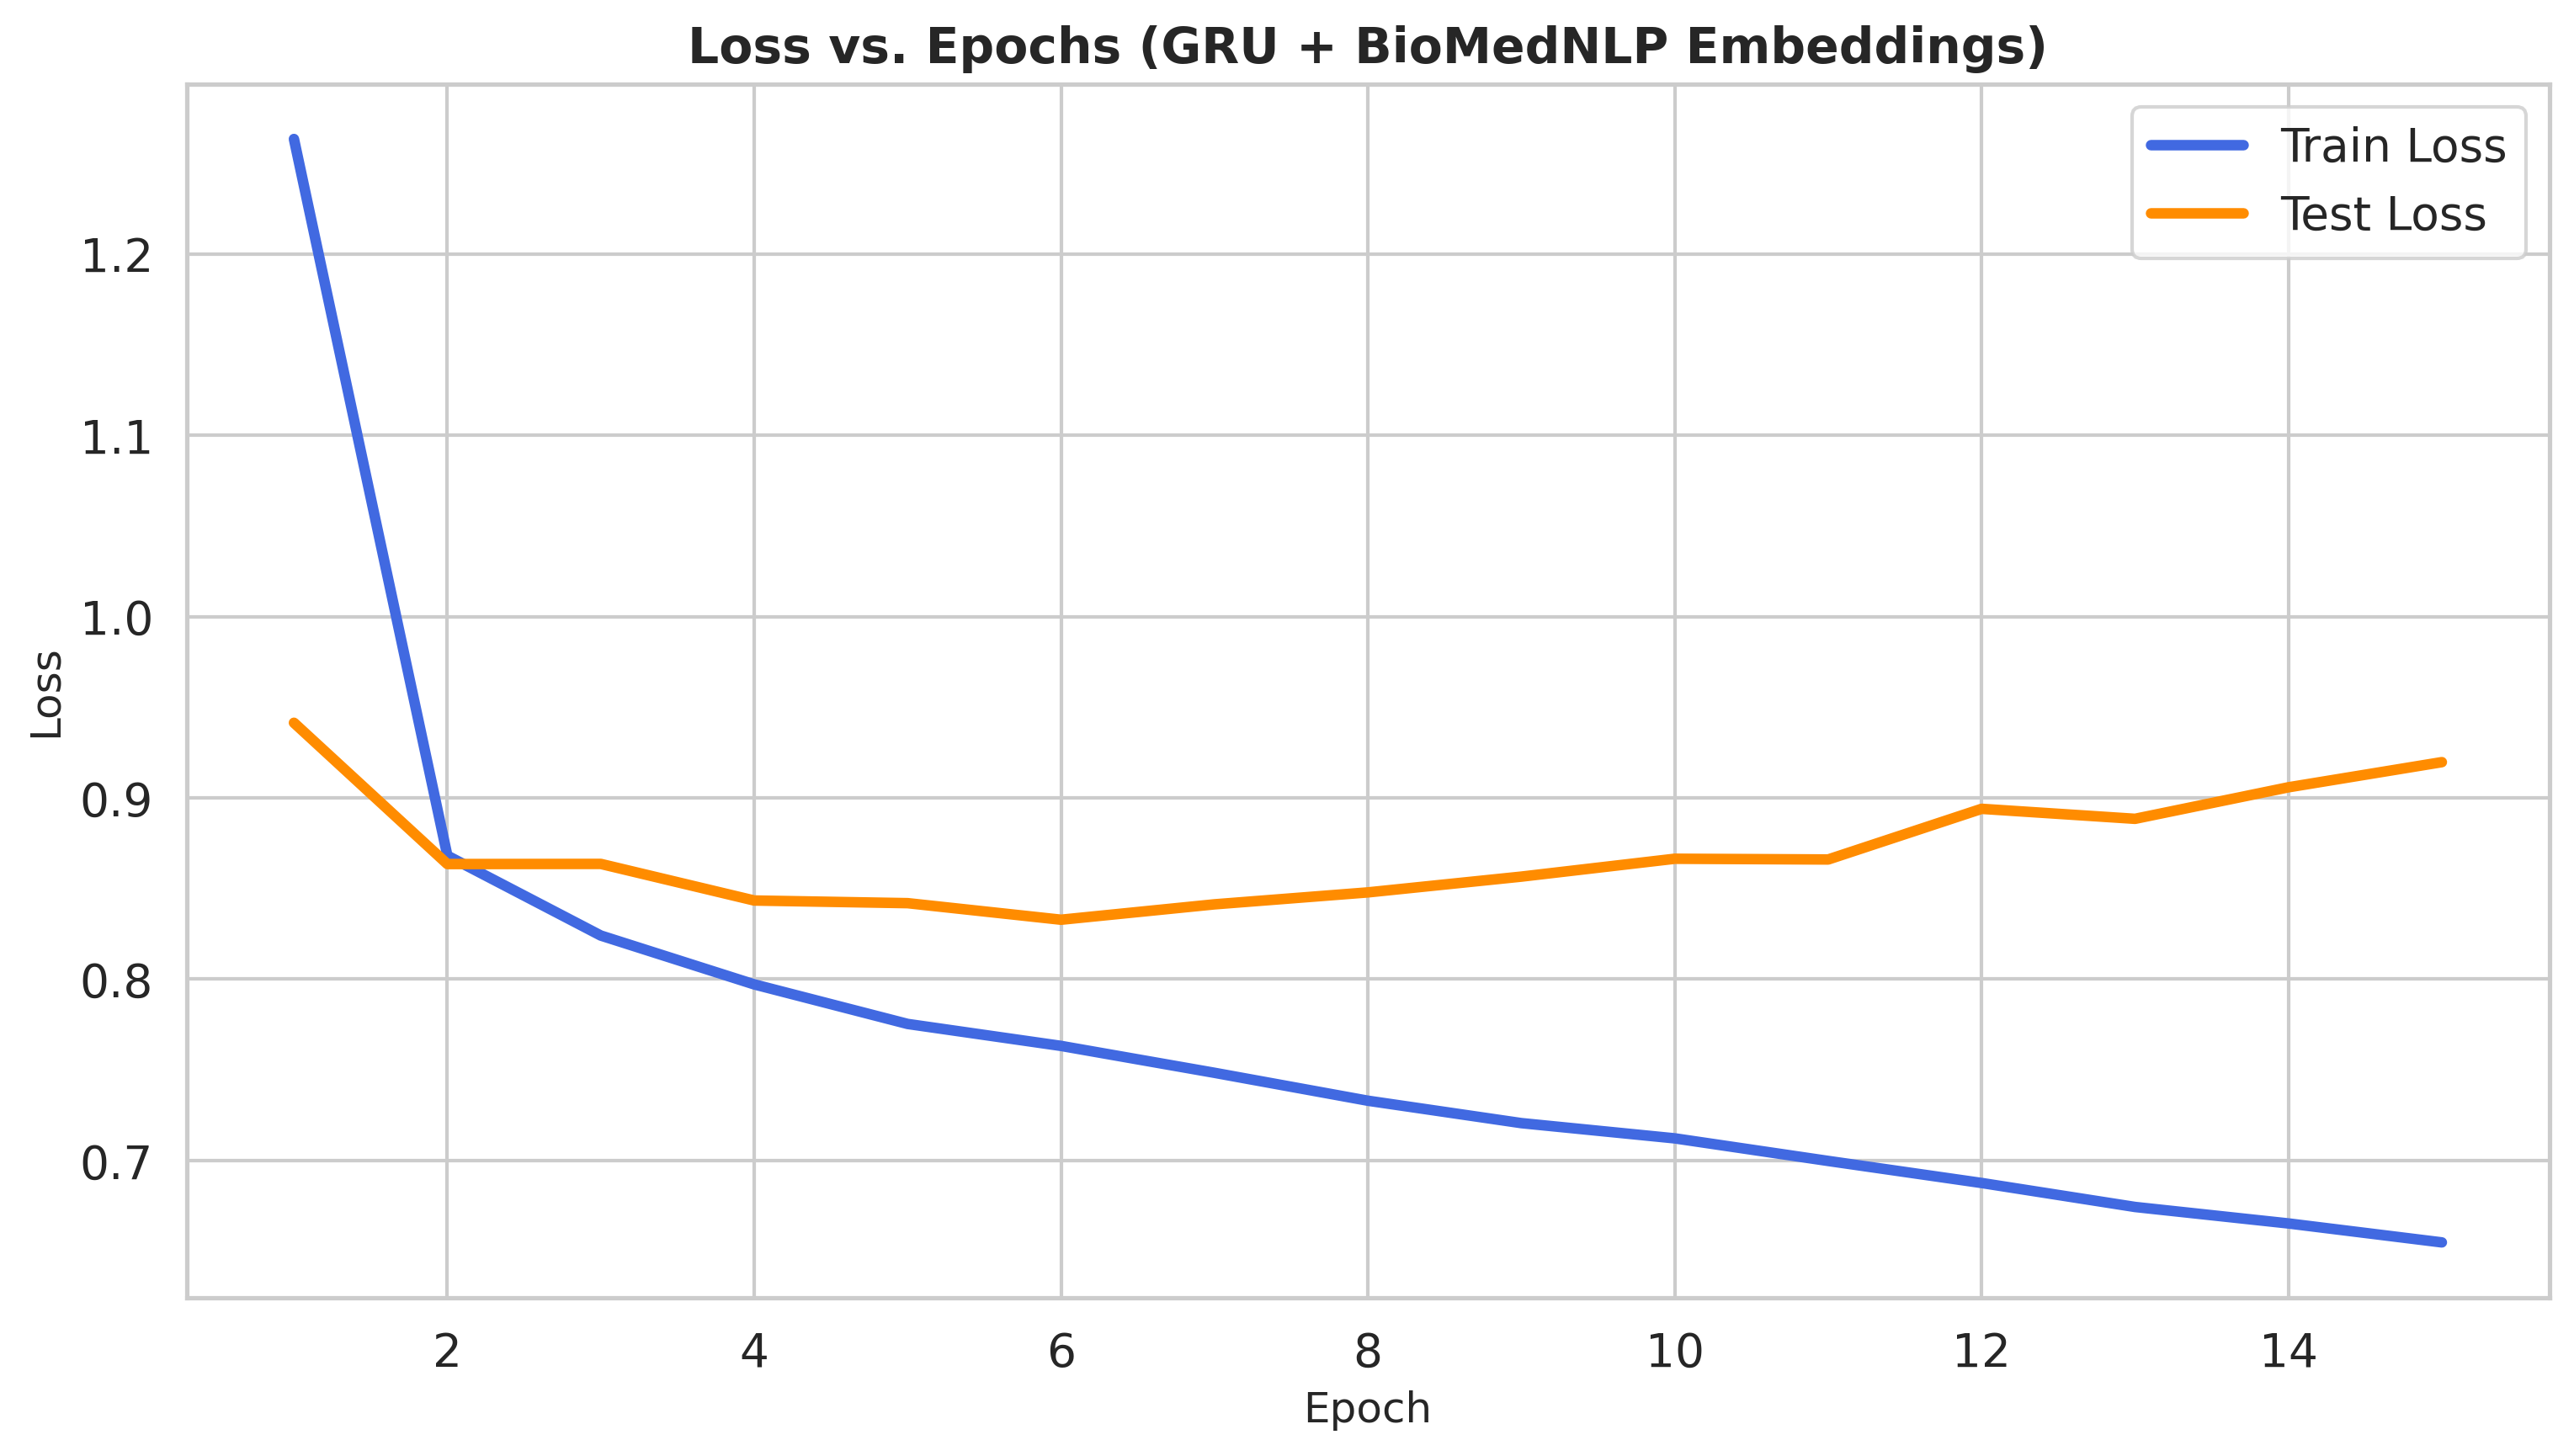

In [ ]:
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})

plt.figure(figsize=(20, 6), dpi=300)

# === 1. Loss Curve ===
plt.subplot(1, 2, 1)

epochs = list(range(1, len(train_losses) + 1))

sns.lineplot(x=epochs, y=train_losses, label='Train Loss', color='royalblue')
sns.lineplot(x=epochs, y=test_losses, label='Test Loss', color='darkorange')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs. Epochs (GRU + BioMedNLP Embeddings)', fontsize=14, weight='bold')
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()

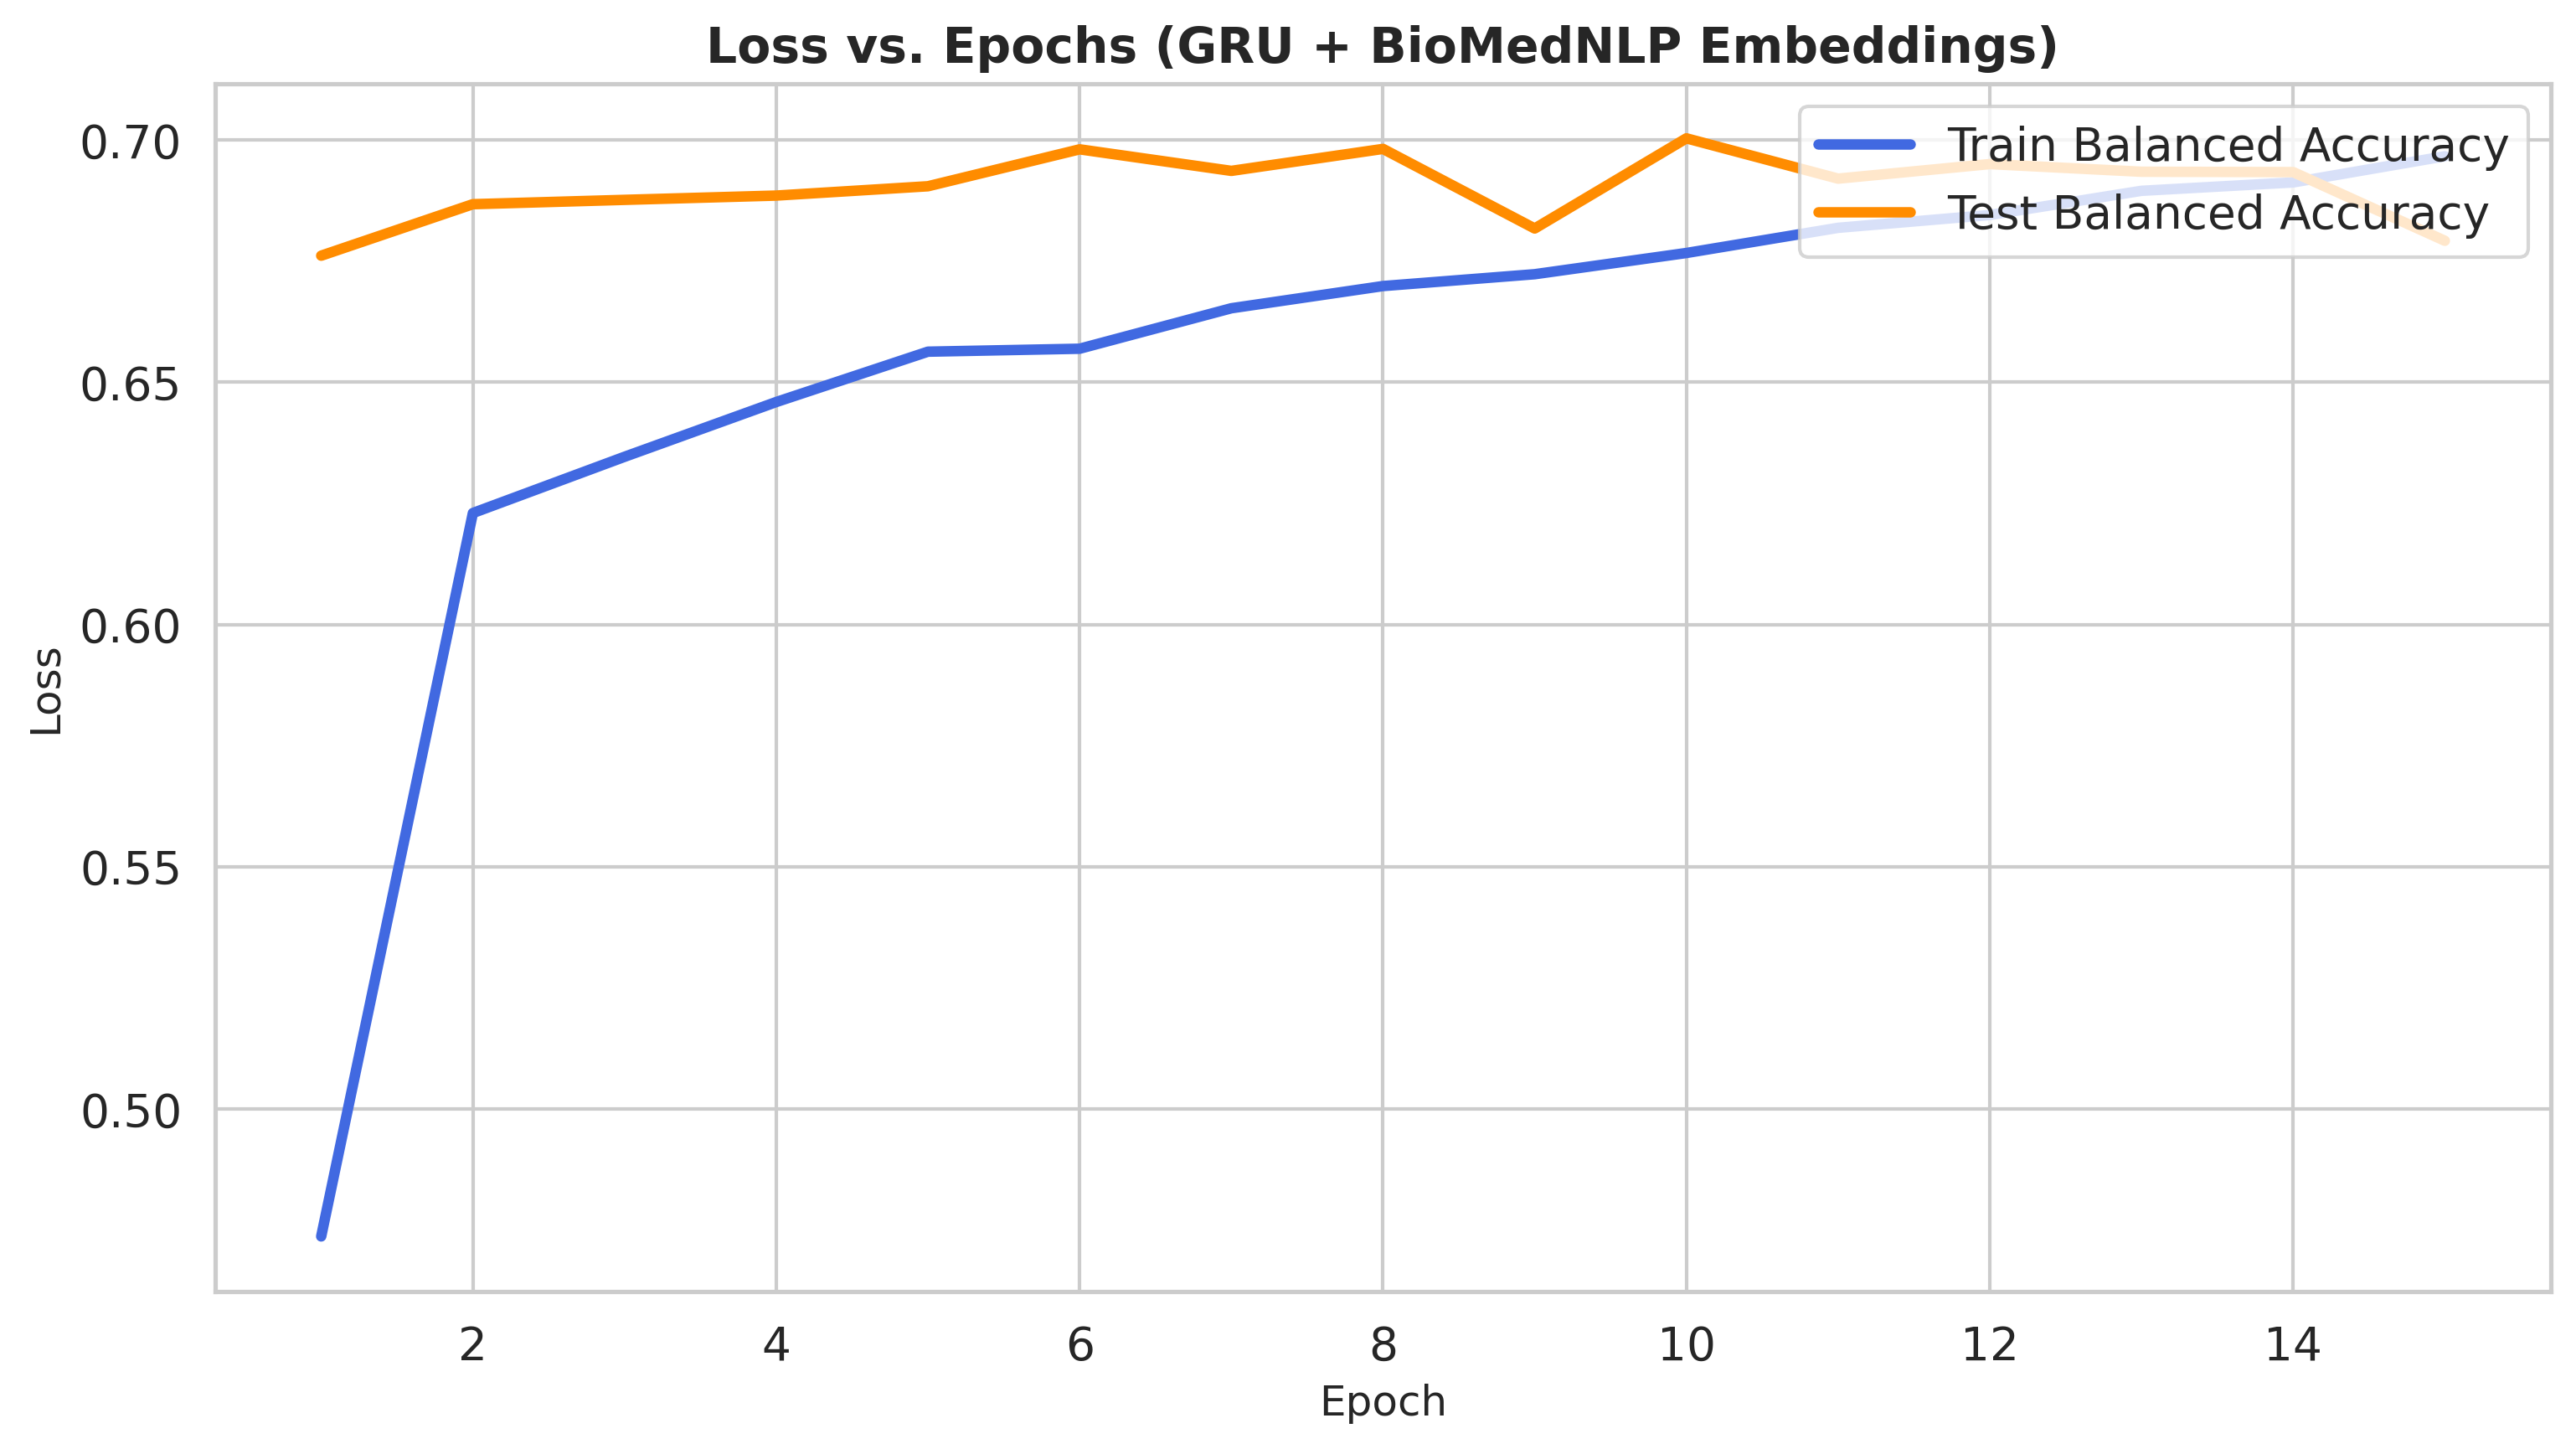

In [ ]:
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
plt.figure(figsize=(20, 6), dpi=300)

# === 2. Balanced Accurcy Curve ===
plt.subplot(1, 2, 1)

epochs = list(range(1, len(train_losses) + 1))

sns.lineplot(x=epochs, y=train_accuracies, label='Train Balanced Accuracy', color='royalblue')
sns.lineplot(x=epochs, y=test_balanced_accs, label='Test Balanced Accuracy', color='darkorange')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs. Epochs (GRU + BioMedNLP Embeddings)', fontsize=14, weight='bold')
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()

In [ ]:
model = BiomedNLP_GRU_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device)

model.load_state_dict(torch.load("/content/best_model_weight_class.pth"))
model.eval()

loss_function = nn.CrossEntropyLoss(class_weights_tensor)

# --- Recalculate metrics on test set ---
final_test_loss, final_test_acc, final_test_f1, final_test_bal_acc, final_test_recall, final_test_precision = test_model(
    model, test_loader, loss_function, device
)

# --- Print results ---
print("\n Final Evaluation Metrics of Best Model:")
print(f"Test Loss           : {final_test_loss:.4f}")
print(f"Test Accuracy       : {final_test_acc:.2%}")
print(f"Test F1 Score       : {final_test_f1:.2%}")
print(f"Balanced Accuracy   : {final_test_bal_acc:.2%}")
print(f"Test Precision      : {final_test_precision:.2%}")
print(f"Test Recall         : {final_test_recall:.2%}")


 Final Evaluation Metrics of Best Model:
Test Loss           : 0.8664
Test Accuracy       : 63.53%
Test F1 Score       : 61.39%
Balanced Accuracy   : 70.04%
Test Precision      : 65.42%
Test Recall         : 63.53%


In [ ]:
def plot_confusion_matrix(ax, y_true, y_pred, num_classes):
    """Plots a confusion matrix as a heatmap.

    Args:
        ax (matplotlib.axes.Axes): The axes on which to plot the confusion matrix.
        y_true (list or array): The true class labels for the test set.
        y_pred (list or array): The predicted class labels for the test set.
        num_classes (int): The number of unique classes in the dataset.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes), ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

def evaluate_and_analyze_BioMedNLP(model, test_loader, device):
    """
    Evaluates a BERT-based model (e.g., BioMedNLP) on the test dataset and performs detailed analysis.

    Args:
        model (nn.Module): Trained BERT-based model.
        test_loader (DataLoader): DataLoader that yields dictionary-style batches with input_ids, attention_mask, etc.
        device (torch.device): Device to perform evaluation on (CPU or GPU).

    Returns:
        df_results (pd.DataFrame): DataFrame with per-class success and failure rates.
        df_wrong (pd.DataFrame): Samples that were predicted incorrectly with full metadata.
        df_correct (pd.DataFrame): Samples that were predicted correctly with full metadata.
        all_labels (list): Ground truth labels for all test samples.
        all_probs (list): Predicted class probabilities for all test samples.
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_indices = []
    all_texts = []
    wrong_samples = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            texts = batch['text']

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_indices.extend(range(batch_idx * test_loader.batch_size, (batch_idx + 1) * test_loader.batch_size))
            all_texts.extend(texts)

            for idx, (pred, prob, label, text) in enumerate(zip(preds, probs, labels, texts)):
                if pred != label:
                    wrong_samples.append({
                        "index": batch_idx * test_loader.batch_size + idx,
                        "true_label": label.item(),
                        "predicted_label": pred.item(),
                        "probability": prob[pred].item(),
                        "text": text
                    })

    class_stats = defaultdict(lambda: {'correct': 0, 'wrong': 0})
    for true_label, pred_label in zip(all_labels, all_preds):
        if true_label == pred_label:
            class_stats[true_label]['correct'] += 1
        else:
            class_stats[true_label]['wrong'] += 1

    class_results = []
    for cls in sorted(class_stats.keys()):
        total = class_stats[cls]['correct'] + class_stats[cls]['wrong']
        success_rate = (class_stats[cls]['correct'] / total) * 100 if total > 0 else 0
        failure_rate = (class_stats[cls]['wrong'] / total) * 100 if total > 0 else 0
        class_results.append({'class': cls, 'success_rate': success_rate, 'failure_rate': failure_rate})

    df_results = pd.DataFrame(class_results)
    df_wrong = pd.DataFrame(wrong_samples)

    correct_samples = []
    for idx, (pred, prob, label, text) in enumerate(zip(all_preds, all_probs, all_labels, all_texts)):
        if pred == label:
            correct_samples.append({
                "index": idx,
                "true_label": label,
                "predicted_label": pred,
                "probability": prob[pred].item(),
                "text": text
            })

    df_correct = pd.DataFrame(correct_samples)

    return df_results, df_wrong, df_correct, all_labels, all_probs

def plot_wrong_distributions(wrong_indices, all_labels, all_preds, num_classes = NUM_CLASSES):
    """Plots the distribution of wrong predictions for each class."""
    class_counts_wrong = defaultdict(int)

    for idx in wrong_indices:
        true_label = all_labels[idx]
        class_counts_wrong[true_label] += 1

    class_labels = sorted(class_counts_wrong.keys())
    counts = [class_counts_wrong[label] for label in class_labels]
    colors = sns.color_palette("husl", len(class_labels))

    class_names = [f"Class {label}" for label in class_labels]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    plt.barh(class_names, counts, color=colors)
    plt.xlabel('Number of Wrong Predictions')
    plt.ylabel('Crop Disease Classes')
    plt.title('Distribution of Wrong Predictions for Each Class')

    for i, (count, name) in enumerate(zip(counts, class_names)):
        plt.text(count, i, str(count), ha='left', va='center')

    plt.show()

In [ ]:
model = BiomedNLP_GRU_Attention(BERT_DIM, HIDDEN_DIM,num_layers=1, dropout_prob=DROPOUT).to(device)
model.load_state_dict(torch.load("best_model_weight_class.pth"))

<All keys matched successfully>

In [ ]:
df_results_BioMedNLP, df_wrong_BioMedNLP, df_correct_BioMedNLP, all_labels_BioMedNLP, all_probs_BioMedNLP = evaluate_and_analyze_BioMedNLP(model, test_loader, device)

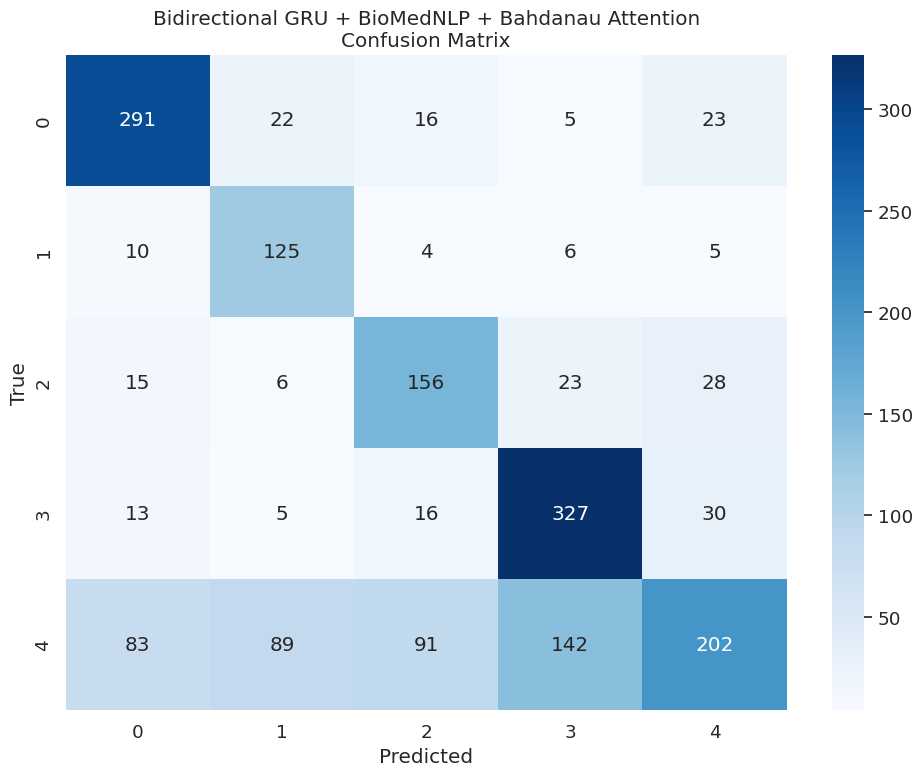

In [ ]:
all_preds_BioMedNLP = np.argmax(np.array(all_probs_BioMedNLP), axis=1)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

plot_confusion_matrix(axes, all_labels_BioMedNLP, all_preds_BioMedNLP, NUM_CLASSES)
axes.set_title("Bidirectional GRU + BioMedNLP + Bahdanau Attention\nConfusion Matrix")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 5
class_names = [f'Class {i}' for i in range(n_classes)]

y_true_BioMedNLP = np.array(all_labels_BioMedNLP)
y_score_BioMedNLP = np.array(all_probs_BioMedNLP)
y_true_bin_BioMedNLP = label_binarize(y_true_BioMedNLP, classes=list(range(n_classes)))

if y_score_BioMedNLP.ndim != 2 or y_score_BioMedNLP.shape[1] != n_classes:
    raise ValueError("y_score_pubMedBert must be an array with shape (n_samples, n_classes) containing probabilities for each class.")

fpr_BioMedNLP, tpr_BioMedNLP, roc_auc_BioMedNLP = {}, {}, {}

for i in range(n_classes):

    fpr_BioMedNLP[i], tpr_BioMedNLP[i], _ = roc_curve(y_true_bin_BioMedNLP[:, i], y_score_BioMedNLP[:, i])
    roc_auc_BioMedNLP[i] = auc(fpr_BioMedNLP[i], tpr_BioMedNLP[i])

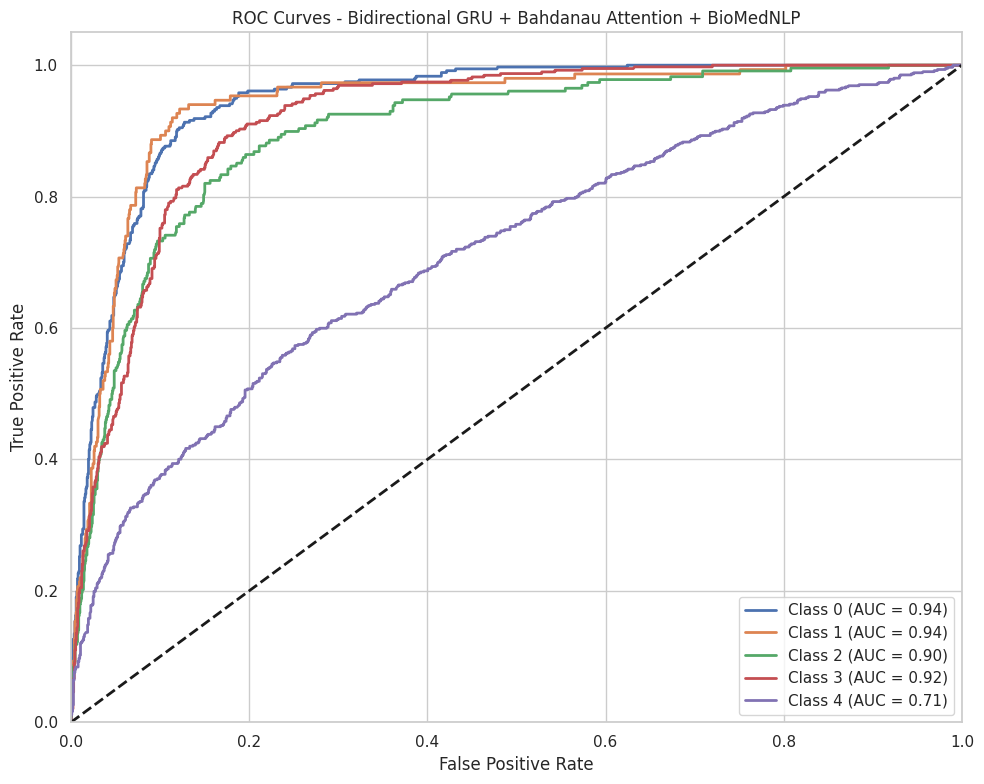

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # Single plot

# Plot ROC Curves
for i in range(n_classes):
    axes.plot(fpr_BioMedNLP[i], tpr_BioMedNLP[i], lw=2,
              label=f'{class_names[i]} (AUC = {roc_auc_BioMedNLP[i]:.2f})')

# Diagonal reference line
axes.plot([0, 1], [0, 1], 'k--', lw=2)

# Axis labels and formatting
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('ROC Curves - Bidirectional GRU + Bahdanau Attention + BioMedNLP')
axes.legend(loc='lower right')
axes.grid(True)

plt.tight_layout()
plt.savefig("biomednlp_roc_curves.png", dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Compute AUCs
auc_macro = roc_auc_score(y_true_bin_BioMedNLP, y_score_BioMedNLP, average='macro')
auc_micro = roc_auc_score(y_true_bin_BioMedNLP, y_score_BioMedNLP, average='micro')
auc_weighted = roc_auc_score(y_true_bin_BioMedNLP, y_score_BioMedNLP, average='weighted')

# Print results
print(f"Macro AUC:     {auc_macro:.4f}")
print(f"Micro AUC:     {auc_micro:.4f}")
print(f"Weighted AUC:  {auc_weighted:.4f}")

Macro AUC:     0.8831
Micro AUC:     0.8967
Weighted AUC:  0.8514


In [ ]:
df_wrong_BioMedNLP

index  true_label  predicted_label  probability  \
0        6           0                4     0.453262   
1       10           2                4     0.603026   
2       12           4                3     0.941747   
3       15           4                3     0.499269   
4       22           3                0     0.279156   
..     ...         ...              ...          ...   
627   1722           4                2     0.840641   
628   1723           4                2     0.707275   
629   1724           4                3     0.572424   
630   1728           4                3     0.717761   
631   1732           0                1     0.608701   

                                                  text  
0    The effects of sucralfate suspension and diphe...  
1    Rate of oxyhemoglobin desaturation in obstruct...  
2    Marfanoid children. Etiologic heterogeneity an...  
3    Microangiopathy in the eosinophilia-myalgia sy...  
4    Spinal cord arteriovenous malformation with an...  
..                                                 ...  
627  Differential reading recovery in patients with...  
628  Exogenous opioids in human breast milk and acu...  
629  Quantitative structural analysis of peripheral...  
630  Systolic wall stress and ventricular arrhythmi...  
631  Gastrointestinal intraluminal pH in normal sub...  

[632 rows x 5 columns]

## **II.2 Few Shot Learning**

In [ ]:
# Helper: select exactly k examples per class from the original training set
def get_k_shot_data_from_original(dataset, k, num_classes):
    X_k, y_k = [], []
    for cls in range(num_classes):
        cls_indices = [i for i, d in enumerate(dataset) if d['labels'].item() == cls]
        chosen = np.random.choice(cls_indices, size=min(k, len(cls_indices)), replace=False)
        for idx in chosen:
            X_k.append(dataset[idx]['text'])
            y_k.append(dataset[idx]['labels'].item())
    return X_k, np.array(y_k)

In [ ]:
k_values = range(1, 11)  # Few-shot from k=1 to 10

BERT_DIM = 768
HIDDEN_DIM = 156
DROPOUT = 0.4

model_metrics = {
    "K-shot": [],
    "Model": [],
    "Test Accuracy": [],
    "F1": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

patience = 5
num_epochs = 16
for k in k_values:
    print(f"\n--- K-Shot = {k} ---")

    X_kshot, y_kshot = get_k_shot_data_from_original(combined_dataset, k, NUM_CLASSES)
    kshot_dataset = BiomedNLPDataset(X_kshot, y_kshot, tokenizer)
    kshot_loader = DataLoader(kshot_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = BiomedNLP_GRU_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device)
    print(f"{count_parameters(model)} model parameters")
    print()
    print(model)

    learning_rate = 8e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_kshot), y=y_kshot)
    loss_function = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

    # Train with early stopping
    best_val_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, kshot_loader, optimizer, loss_function, device)
        val_acc, val_f1, val_loss = evaluate_model(model, test_loader, loss_function, device)

        print(f"K={k} | Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    avg_loss, avg_accuracy, f1, balanced_acc, recall, precision = test_model(model, test_loader, loss_function, device)

    # Log metrics
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    model_metrics["K-shot"].append(k)
    model_metrics["Model"].append("GRU-BioMedNLP")
    model_metrics["Test Accuracy"].append(avg_accuracy)
    model_metrics["F1"].append(f1)
    model_metrics["Balanced Accuracy"].append(balanced_acc)
    model_metrics["Recall"].append(recall)
    model_metrics["Precision"].append(precision)

# Convert results to DataFrame
df = pd.DataFrame(model_metrics)


--- K-Shot = 1 ---
917285 model parameters

BiomedNLP_GRU_Attention(
  (gru): GRU(768, 156, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=312, out_features=156, bias=True)
    (v): Linear(in_features=156, out_features=1, bias=False)
  )
  (fc): Linear(in_features=312, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
K=1 | Epoch 1/16 - Train Loss: 1.7877, Train Acc: 0.2000, Val Loss: 1.6441, Val Acc: 0.1994, Val F1: 0.0703
K=1 | Epoch 2/16 - Train Loss: 1.4521, Train Acc: 0.4000, Val Loss: 1.6276, Val Acc: 0.2168, Val F1: 0.1116
K=1 | Epoch 3/16 - Train Loss: 1.4477, Train Acc: 0.4000, Val Loss: 1.6160, Val Acc: 0.2663, Val F1: 0.1838
K=1 | Epoch 4/16 - Train Loss: 1.4393, Train Acc: 0.2000, Val Loss: 1.6106, Val Acc: 0.2965, Val F1: 0.2008
K=1 | Epoch 5/16 - Train Loss: 1.5294, Train Acc: 0.4000, Val Loss: 1.6068, Val Acc: 0.3040, Val F1: 0.2074
K=1 | Epoch 6/16 - Train Loss: 1.4607, Train Acc: 0.6000, Val Lo

In [ ]:
# --- Plotting ---
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
palette = sns.color_palette("Set2")

def plot_model_performance(df, model_name, color, title_prefix="Model Performance"):
    model_df = df[df["Model"] == model_name]
    metrics_to_plot = ["F1", "Balanced Accuracy", "Recall", "Precision"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        sns.lineplot(
            data=model_df,
            x="K-shot",
            y=metric,
            ax=axes[i],
            color=color,
            marker="o",
            linewidth=2.2,
            markersize=6,
        )
        axes[i].set_title(metric, fontsize=14)
        axes[i].set_xlabel("K-shot")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    plt.suptitle(f"{title_prefix} for {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

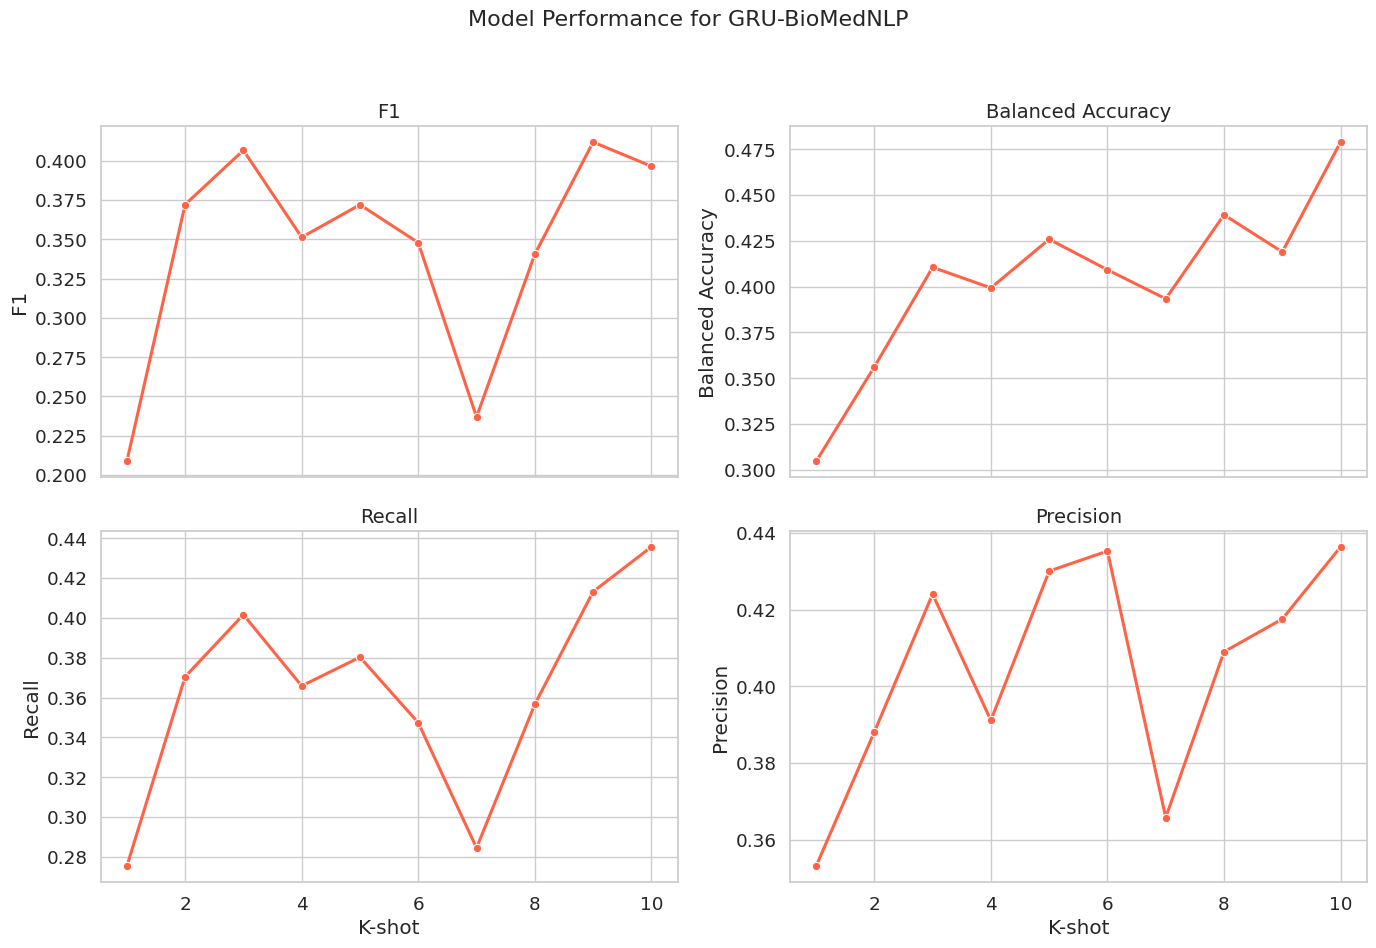

In [ ]:
# Plot results
plot_model_performance(df, "GRU-BioMedNLP", "tomato")

Maximum values per metric:
Balanced Accuracy: 0.4789 (at K-shot = 10)
F1: 0.4118 (at K-shot = 9)
Recall: 0.4357 (at K-shot = 10)
Precision: 0.4364 (at K-shot = 10)


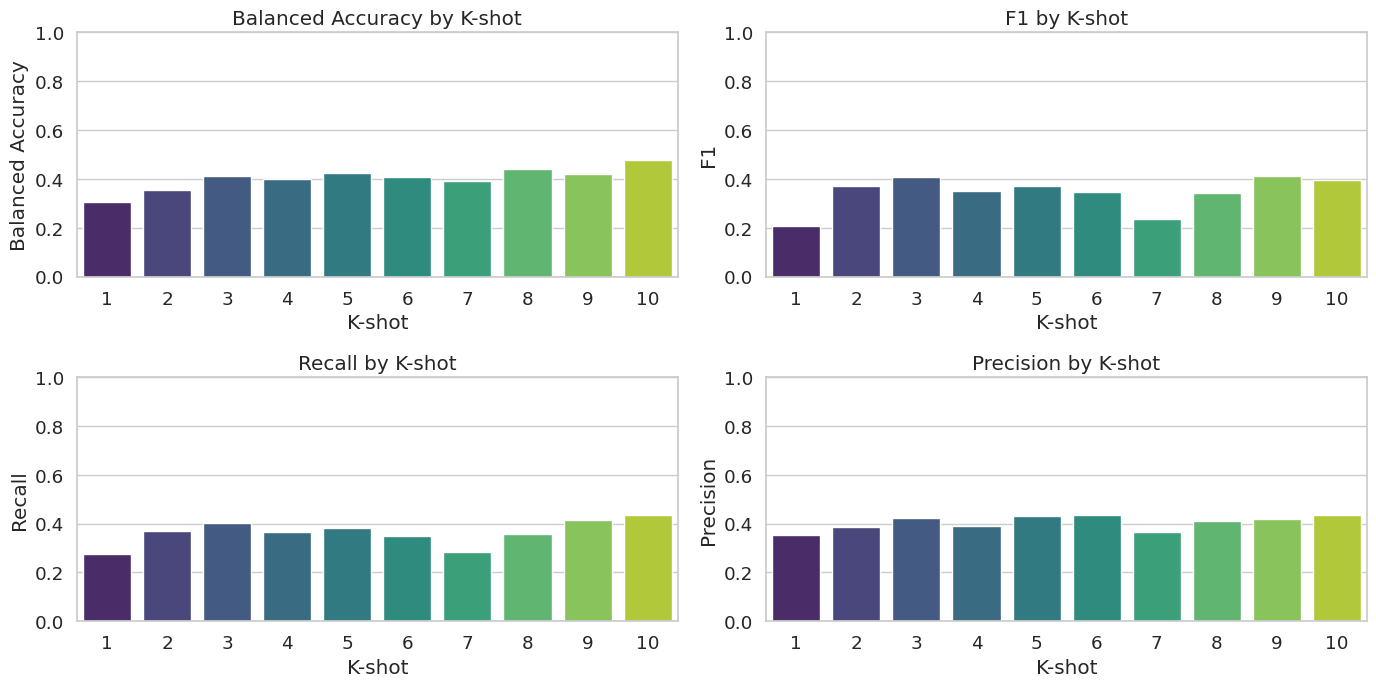

In [ ]:
metrics = ["Balanced Accuracy", "F1", "Recall", "Precision"]

# Print max values for each metric
print("Maximum values per metric:")
for metric in metrics:
    max_val = df[metric].max()
    max_k = df.loc[df[metric].idxmax(), "K-shot"]
    print(f"{metric}: {max_val:.4f} (at K-shot = {max_k})")

# Then plot the histograms
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x="K-shot", y=metric, data=df, palette="viridis")
    plt.title(f"{metric} by K-shot")
    plt.ylim(0, 1)
    plt.xlabel("K-shot")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# **III. LSTM + BioMedNLP + Bahdanau Attention**

## **III.1 Optimization Phase**

In [21]:
BERT_DIM = 768
HIDDEN_DIM = 156
DROPOUT = 0.4

#### **Optimizer selection**

In [ ]:
num_epochs = 10
learning_rate = 5e-5

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
results = []

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW
}

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = BiomedNLP_LSTM_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    print(model)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        val_f1s.append(f1)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Opt: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

    all_train_losses[optimizer_name] = train_losses
    all_val_losses[optimizer_name] = val_losses
    all_train_accs[optimizer_name] = train_accs
    all_val_accs[optimizer_name] = val_accs

    label = f"Batch={BATCH_SIZE} | Optimizer={optimizer_name} | HD={HIDDEN_DIM} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with optimizer: Adam
BiomedNLP_LSTM_Attention(
  (lstm): LSTM(768, 156, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=312, out_features=156, bias=True)
    (v): Linear(in_features=156, out_features=1, bias=False)
  )
  (fc): Linear(in_features=312, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Total trainable parameters: 1206197
Opt: Adam | Epoch 1/10 - TL: 1.5850, VL: 1.5288, TA: 27.37%, VA: 47.98%, F1: 38.76%, Time: 4.69 min
Opt: Adam | Epoch 2/10 - TL: 1.4166, VL: 1.2036, TA: 46.57%, VA: 60.37%, F1: 49.12%, Time: 4.71 min
Opt: Adam | Epoch 3/10 - TL: 1.0882, VL: 0.9603, TA: 54.81%, VA: 64.19%, F1: 49.08%, Time: 4.70 min
Opt: Adam | Epoch 4/10 - TL: 0.9606, VL: 0.9026, TA: 56.45%, VA: 65.74%, F1: 53.29%, Time: 4.71 min
Opt: Adam | Epoch 5/10 - TL: 0.9138, VL: 0.8755, TA: 58.53%, VA: 67.38%, F1: 55.87%, Time: 4.71 min
Opt: Adam | Epoch 6/10 - TL: 0.8870, VL: 0.8632, TA: 59.86%, VA: 68.17%, F1: 

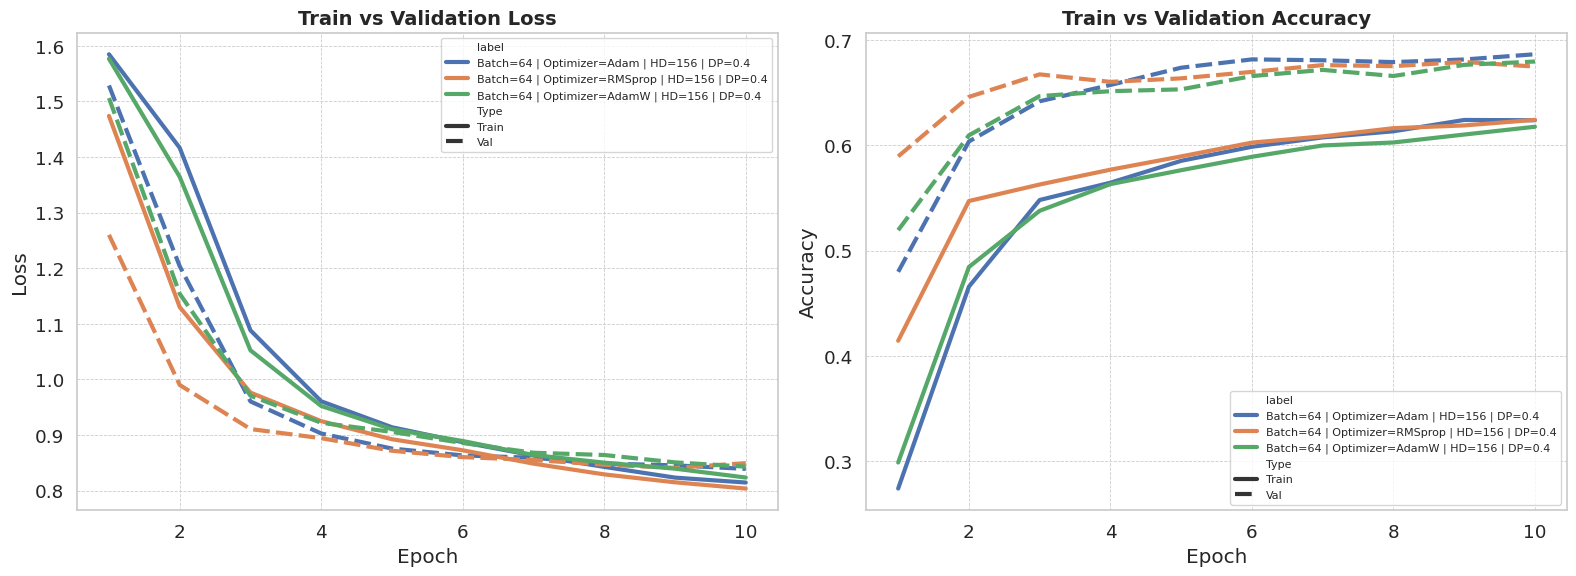

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Learning rate value selection**

In [ ]:
learning_rates = [3e-5, 8e-5, 5e-5]
optimizer_name = 'RMSprop'
optimizer_class = optim.RMSprop
results = []
num_epochs = 10

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop optimizer, learning rate = {lr}")

    model = BiomedNLP_LSTM_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    print(model)

    optimizer = optimizer_class(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(f1)

        print(
            f"LR: {lr:.1e} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {(time.time() - start_time)/60:.2f} min"
        )

    label = f"LR={lr:.1e} | Optimizer={optimizer_name} | HD={HIDDEN_DIM} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with RMSprop optimizer, learning rate = 3e-05
BiomedNLP_LSTM_Attention(
  (lstm): LSTM(768, 156, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=312, out_features=156, bias=True)
    (v): Linear(in_features=156, out_features=1, bias=False)
  )
  (fc): Linear(in_features=312, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
LR: 3.0e-05 | Epoch 1/10 - TL: 1.5520, VL: 1.4849, TA: 32.62%, VA: 54.68%, F1: 49.81%, Time: 4.71 min
LR: 3.0e-05 | Epoch 2/10 - TL: 1.4000, VL: 1.2631, TA: 49.35%, VA: 61.47%, F1: 47.66%, Time: 4.71 min
LR: 3.0e-05 | Epoch 3/10 - TL: 1.1720, VL: 1.0581, TA: 53.61%, VA: 62.59%, F1: 47.07%, Time: 4.71 min
LR: 3.0e-05 | Epoch 4/10 - TL: 1.0331, VL: 0.9714, TA: 55.11%, VA: 64.57%, F1: 49.67%, Time: 4.71 min
LR: 3.0e-05 | Epoch 5/10 - TL: 0.9654, VL: 0.9203, TA: 56.49%, VA: 65.92%, F1: 52.29%, Time: 4.71 min
LR: 3.0e-05 | Epoch 6/10 - TL: 0.9212, VL: 0.8954, TA: 58.13%, VA: 66.75%, F1:

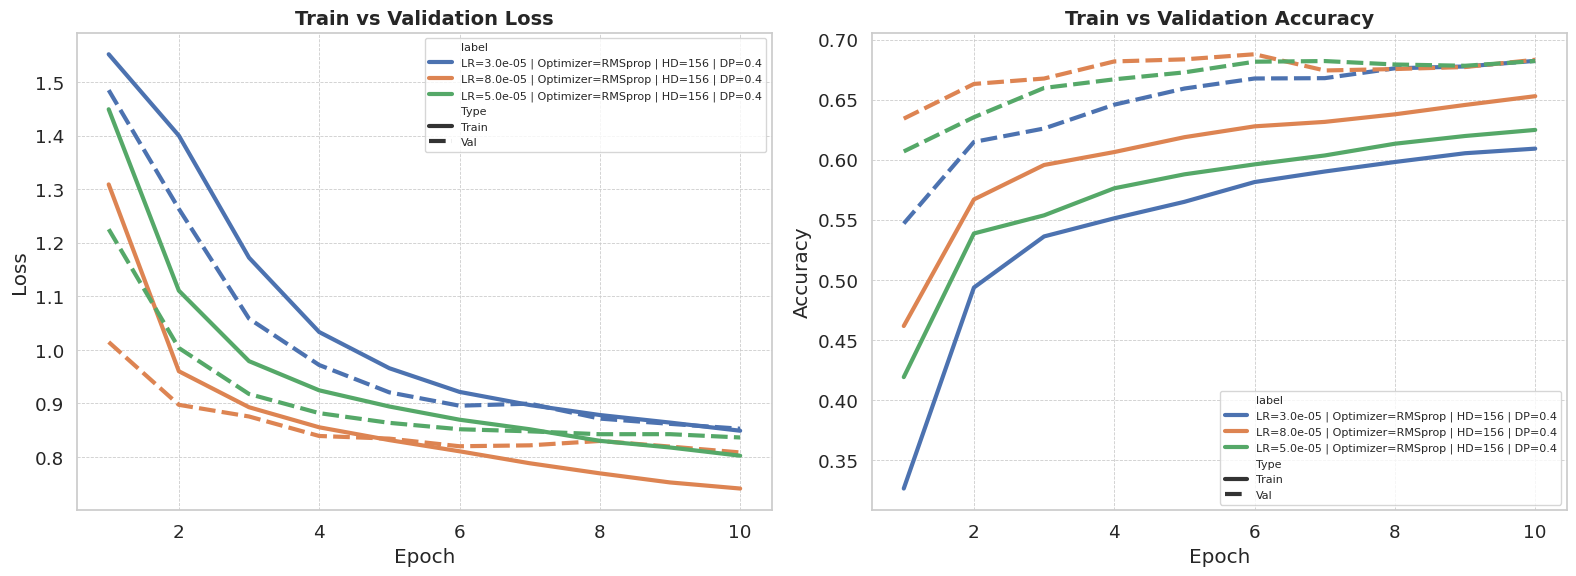

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Batch size value selection**

In [ ]:
batch_sizes = [32, 16]
learning_rate = 2e-5
num_epochs = 10

results = []

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")

    # Create DataLoader with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = BiomedNLP_LSTM_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(f1)

        print(
            f"BS: {batch_size} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {(time.time() - start_time)/60:.2f} min"
        )

    label = f"LR={learning_rate:.1e} | Batch={batch_size} | HD={HIDDEN_DIM} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with batch size: 32
BS: 32 | Epoch 1/8 - TL: 1.5931, VL: 1.5609, TA: 24.71%, VA: 49.28%, F1: 42.89%, Time: 5.06 min
BS: 32 | Epoch 2/8 - TL: 1.5284, VL: 1.4570, TA: 39.08%, VA: 57.56%, F1: 45.89%, Time: 5.05 min
BS: 32 | Epoch 3/8 - TL: 1.3460, VL: 1.2048, TA: 50.15%, VA: 60.85%, F1: 46.64%, Time: 5.05 min
BS: 32 | Epoch 4/8 - TL: 1.1465, VL: 1.0509, TA: 52.99%, VA: 63.86%, F1: 47.17%, Time: 5.05 min
BS: 32 | Epoch 5/8 - TL: 1.0415, VL: 0.9856, TA: 54.57%, VA: 64.32%, F1: 49.17%, Time: 5.05 min
BS: 32 | Epoch 6/8 - TL: 0.9818, VL: 0.9417, TA: 55.62%, VA: 64.99%, F1: 50.04%, Time: 5.05 min
BS: 32 | Epoch 7/8 - TL: 0.9431, VL: 0.9203, TA: 57.09%, VA: 65.84%, F1: 53.12%, Time: 5.05 min
BS: 32 | Epoch 8/8 - TL: 0.9219, VL: 0.9056, TA: 58.19%, VA: 66.81%, F1: 55.10%, Time: 5.06 min

🔹 Training with batch size: 16
BS: 16 | Epoch 1/8 - TL: 1.5826, VL: 1.5261, TA: 32.80%, VA: 53.72%, F1: 47.46%, Time: 4.85 min
BS: 16 | Epoch 2/8 - TL: 1.4160, VL: 1.2285, TA: 48.41%, VA: 60.41%, F1:

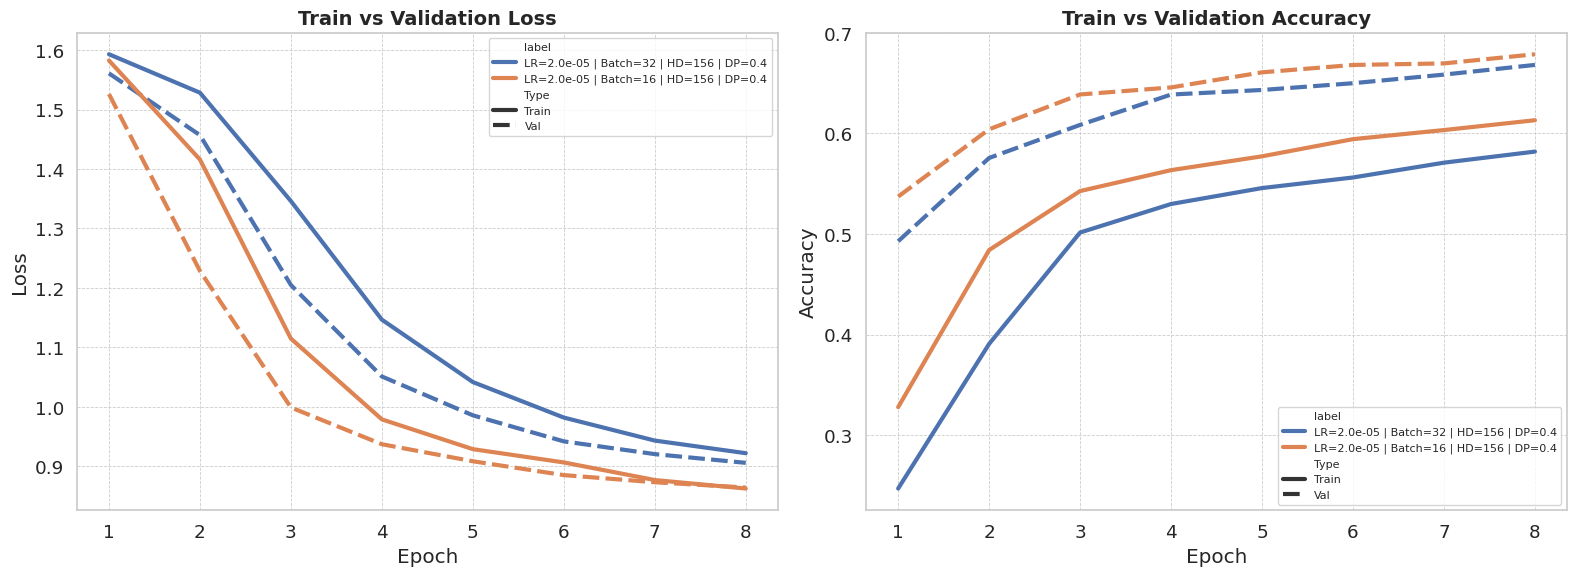

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Hidden dimension value selection**

In [23]:
hidden_dims = [256, 167, 400]
learning_rate = 3e-5
batch_size = 16
num_epochs = 10
results = []

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden dimension: {hidden_dim}")

    # Dataloaders remain the same since batch_size is fixed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Pass the loop variable `hidden_dim` instead of a fixed HIDDEN_DIM
    model = BiomedNLP_LSTM_Attention(BERT_DIM, hidden_dim, dropout_prob=DROPOUT).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(f1)

        print(
            f"HD: {hidden_dim} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {(time.time() - start_time)/60:.2f} min"
        )

    label = f"LR={learning_rate:.1e} | BS={batch_size} | HD={hidden_dim} | DP={DROPOUT}"
    for epoch in range(num_epochs):
        results.append({
            "epoch": epoch + 1,
            "label": label,
            "train_loss": train_losses[epoch],
            "val_loss": val_losses[epoch],
            "train_acc": train_accs[epoch],
            "val_acc": val_accs[epoch],
            "val_f1": val_f1s[epoch]
        })


🔹 Training with hidden dimension: 256
HD: 256 | Epoch 1/10 - TL: 1.4687, VL: 1.1798, TA: 40.36%, VA: 57.85%, F1: 49.53%, Time: 4.74 min
HD: 256 | Epoch 2/10 - TL: 1.0499, VL: 0.9649, TA: 55.02%, VA: 62.85%, F1: 48.86%, Time: 4.87 min
HD: 256 | Epoch 3/10 - TL: 0.9244, VL: 0.8964, TA: 58.87%, VA: 66.65%, F1: 57.17%, Time: 4.90 min
HD: 256 | Epoch 4/10 - TL: 0.8820, VL: 0.8886, TA: 60.93%, VA: 66.23%, F1: 55.87%, Time: 4.90 min
HD: 256 | Epoch 5/10 - TL: 0.8524, VL: 0.8627, TA: 62.20%, VA: 67.11%, F1: 56.79%, Time: 4.90 min
HD: 256 | Epoch 6/10 - TL: 0.8232, VL: 0.8471, TA: 63.29%, VA: 67.56%, F1: 57.87%, Time: 4.88 min
HD: 256 | Epoch 7/10 - TL: 0.7975, VL: 0.8743, TA: 64.07%, VA: 66.04%, F1: 59.09%, Time: 4.89 min
HD: 256 | Epoch 8/10 - TL: 0.7891, VL: 0.8406, TA: 64.22%, VA: 67.60%, F1: 58.07%, Time: 4.89 min
HD: 256 | Epoch 9/10 - TL: 0.7691, VL: 0.8278, TA: 64.89%, VA: 68.11%, F1: 59.75%, Time: 4.90 min
HD: 256 | Epoch 10/10 - TL: 0.7565, VL: 0.8386, TA: 65.16%, VA: 67.94%, F1: 58.

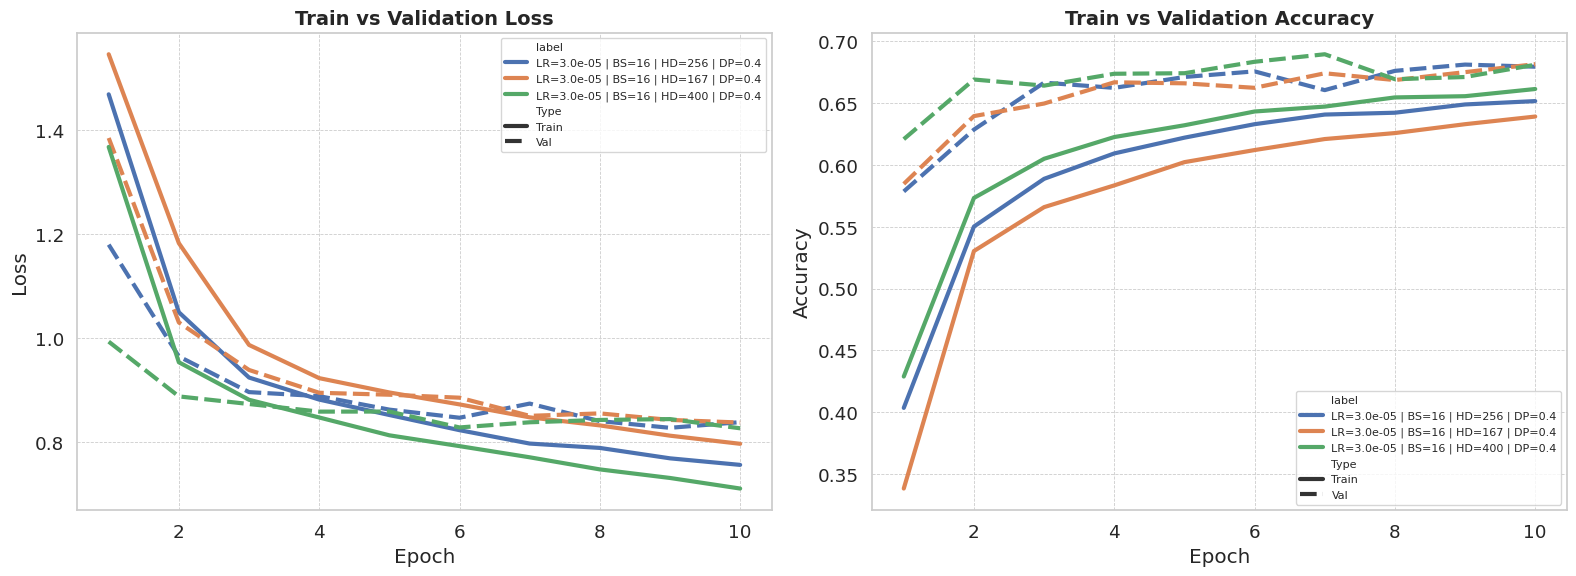

In [24]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

#### **Dropout value selection**

In [ ]:
dropout_values = [0.3, 0.5, 0.7]
hidden_dims = [286]
learning_rate = 3e-5
batch_size = 16
num_epochs = 10
results = []

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for hidden_dim in hidden_dims:
    for dropout_prob in dropout_values:
        print(f"\n🔹 Training with hidden_dim={hidden_dim}, dropout={dropout_prob}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = BiomedNLP_LSTM_Attention(BERT_DIM, hidden_dim, dropout_prob=dropout_prob).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        val_f1s = []

        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(f1)

            print(
                f"HD={hidden_dim}, DP={dropout_prob} | Epoch {epoch+1}/{num_epochs} - "
                f"TL={train_loss:.4f}, VL={val_loss:.4f}, "
                f"TA={train_acc:.2%}, VA={val_acc:.2%}, F1={f1:.2%}, "
                f"Time={(time.time() - start_time)/60:.2f} min"
            )

        label = f"LR={learning_rate:.1e} | BS={batch_size} | HD={hidden_dim} | DP={dropout_prob}"
        for epoch in range(num_epochs):
            results.append({
                "epoch": epoch + 1,
                "label": label,
                "train_loss": train_losses[epoch],
                "val_loss": val_losses[epoch],
                "train_acc": train_accs[epoch],
                "val_acc": val_accs[epoch],
                "val_f1": val_f1s[epoch]
            })


🔹 Training with hidden_dim=286, dropout=0.3
HD=286, DP=0.3 | Epoch 1/10 - TL=1.4298, VL=1.0441, TA=42.04%, VA=62.69%, F1=44.84%, Time=5.45 min
HD=286, DP=0.3 | Epoch 2/10 - TL=0.9767, VL=0.9312, TA=55.14%, VA=65.11%, F1=55.07%, Time=5.52 min
HD=286, DP=0.3 | Epoch 3/10 - TL=0.8994, VL=0.8727, TA=59.26%, VA=67.55%, F1=56.73%, Time=5.52 min
HD=286, DP=0.3 | Epoch 4/10 - TL=0.8569, VL=0.8516, TA=60.89%, VA=68.26%, F1=60.03%, Time=5.52 min
HD=286, DP=0.3 | Epoch 5/10 - TL=0.8250, VL=0.8567, TA=62.24%, VA=68.21%, F1=55.70%, Time=5.52 min
HD=286, DP=0.3 | Epoch 6/10 - TL=0.8094, VL=0.8418, TA=63.18%, VA=69.03%, F1=59.06%, Time=5.53 min
HD=286, DP=0.3 | Epoch 7/10 - TL=0.7851, VL=0.8779, TA=63.83%, VA=67.10%, F1=59.50%, Time=5.52 min
HD=286, DP=0.3 | Epoch 8/10 - TL=0.7657, VL=0.8400, TA=64.07%, VA=68.57%, F1=61.22%, Time=5.53 min
HD=286, DP=0.3 | Epoch 9/10 - TL=0.7494, VL=0.8444, TA=64.92%, VA=68.14%, F1=59.88%, Time=5.52 min
HD=286, DP=0.3 | Epoch 10/10 - TL=0.7357, VL=0.8428, TA=64.91%, 

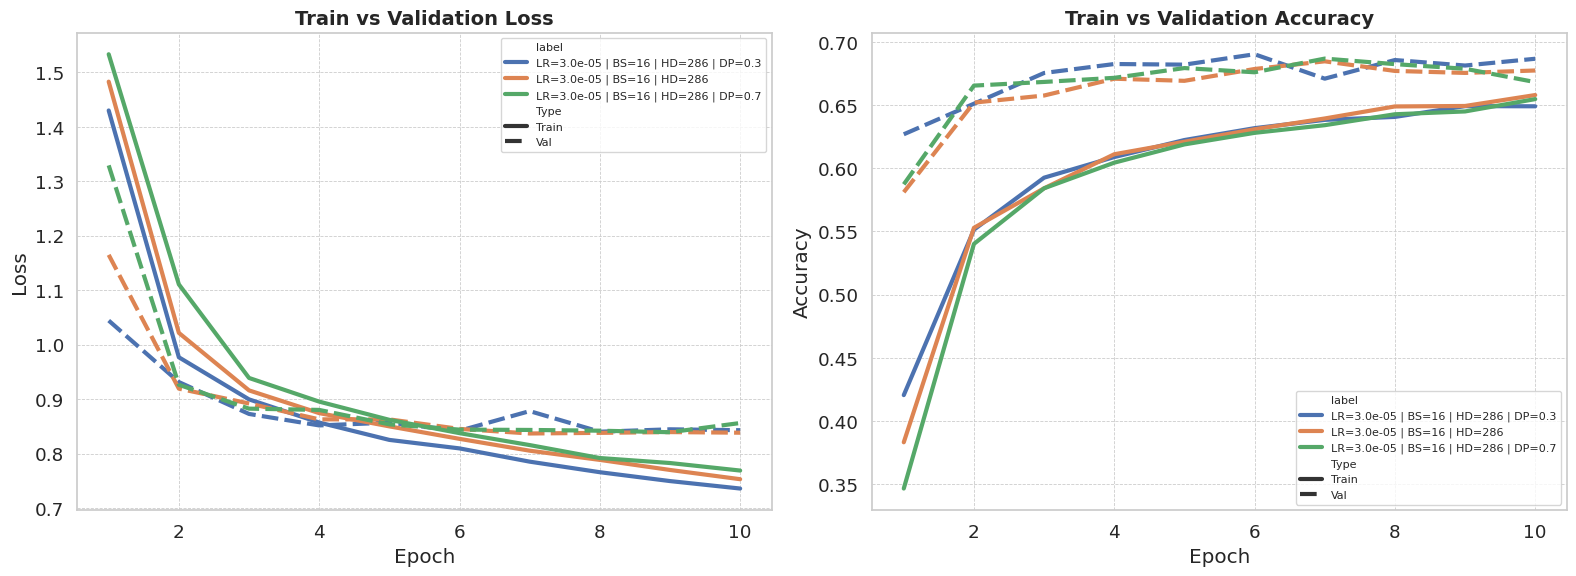

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

df_results['label'] = (
    df_results['label']
    .str.replace(r'\s*\|\s*HD=450', '', regex=True)
    .str.replace(r'\s*\|\s*DP=0\.5', '', regex=True)
)

df_loss = pd.melt(df_results, id_vars=['epoch', 'label'],
                  value_vars=['train_loss', 'val_loss'],
                  var_name='Type', value_name='Loss')
df_loss['Type'] = df_loss['Type'].map({'train_loss': 'Train', 'val_loss': 'Val'})

df_acc = pd.melt(df_results, id_vars=['epoch', 'label'],
                 value_vars=['train_acc', 'val_acc'],
                 var_name='Type', value_name='Accuracy')
df_acc['Type'] = df_acc['Type'].map({'train_acc': 'Train', 'val_acc': 'Val'})

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
sns.lineplot(data=df_loss, x='epoch', y='Loss', hue='label', style='Type', ax=axes[0])
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Run')
axes[0].legend(title=None, fontsize=8)
axes[0].grid(True, linestyle='--', linewidth=0.6)

# Plot Accuracy
sns.lineplot(data=df_acc, x='epoch', y='Accuracy', hue='label', style='Type', ax=axes[1])
axes[1].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Run')
axes[1].legend(title=None, fontsize=8)
axes[1].grid(True, linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("combined_metrics_highres.png", dpi=300, bbox_inches='tight')
plt.show()

## **III.2 Test Phase**

#### **With Class Weighting**

In [ ]:
BATCH_SIZE = 16

# --- Load Data ---
train_dataset = BiomedNLPDataset(X_train.tolist(), y_train, tokenizer)
val_dataset = BiomedNLPDataset(X_val.tolist(), y_val, tokenizer)
test_dataset = BiomedNLPDataset(X_test.tolist(), y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Combine the training and validation datasets (for test)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
BERT_DIM = 768
HIDDEN_DIM = 286
DROPOUT = 0.4

# --- Model Instantiation ---
model = BiomedNLP_LSTM_Attention(BERT_DIM, HIDDEN_DIM,num_layers=1, dropout_prob=DROPOUT).to(device)

learning_rate = 2e-5
num_epochs = 30
patience = 4
best_model_path = "best_model_weight_class.pth"

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# --- Compute Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_function = nn.CrossEntropyLoss(class_weights_tensor)

# --- Tracking Variables ---
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []

best_test_bal_acc = 0
patience_counter = 0
best_model_state = None

# --- Training with Early Stopping ---
with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as epoch_pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, combined_loader, optimizer, loss_function, device)
        test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_model(
                    model, test_loader, loss_function, device)

        # Logging
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_balanced_accs.append(test_balanced_acc)
        test_f1s.append(test_f1)

        epoch_duration = time.time() - start_time

        # --- Early Stopping Logic ---
        if test_balanced_acc > best_test_bal_acc:
            best_test_bal_acc = test_balanced_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(best_model_state, best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch + 1}.")
                break

        # --- Progress Bar Update ---
        epoch_pbar.set_postfix({
            "Training Loss": f"{train_loss:.4f}",
            "Test Loss": f"{test_loss:.4f}",
            "Training Balanced Acc": f"{train_acc:.2%}",
            "Test Balanced Acc": f"{test_balanced_acc:.2%}",
            "Test F1": f"{test_f1:.2%}",
            "Test Precision": f"{test_precision:.2%}",
            "Test Recall": f"{test_recall:.2%}",
            "Time(min)": f"{epoch_duration / 60:.2f}"
        })
        epoch_pbar.update(1)

# --- Load Best Model ---
model.load_state_dict(torch.load(best_model_path))

Training Progress:  83%|████████▎ | 25/30 [2:26:16<29:15, 351.07s/epoch, Training Loss=0.6662, Test Loss=0.9173, Training Balanced Acc=68.69%, Test Balanced Acc=65.36%, Test F1=58.46%, Test Precision=60.62%, Test Recall=59.90%, Time(min)=5.63]


Early stopping at epoch 26.


<All keys matched successfully>

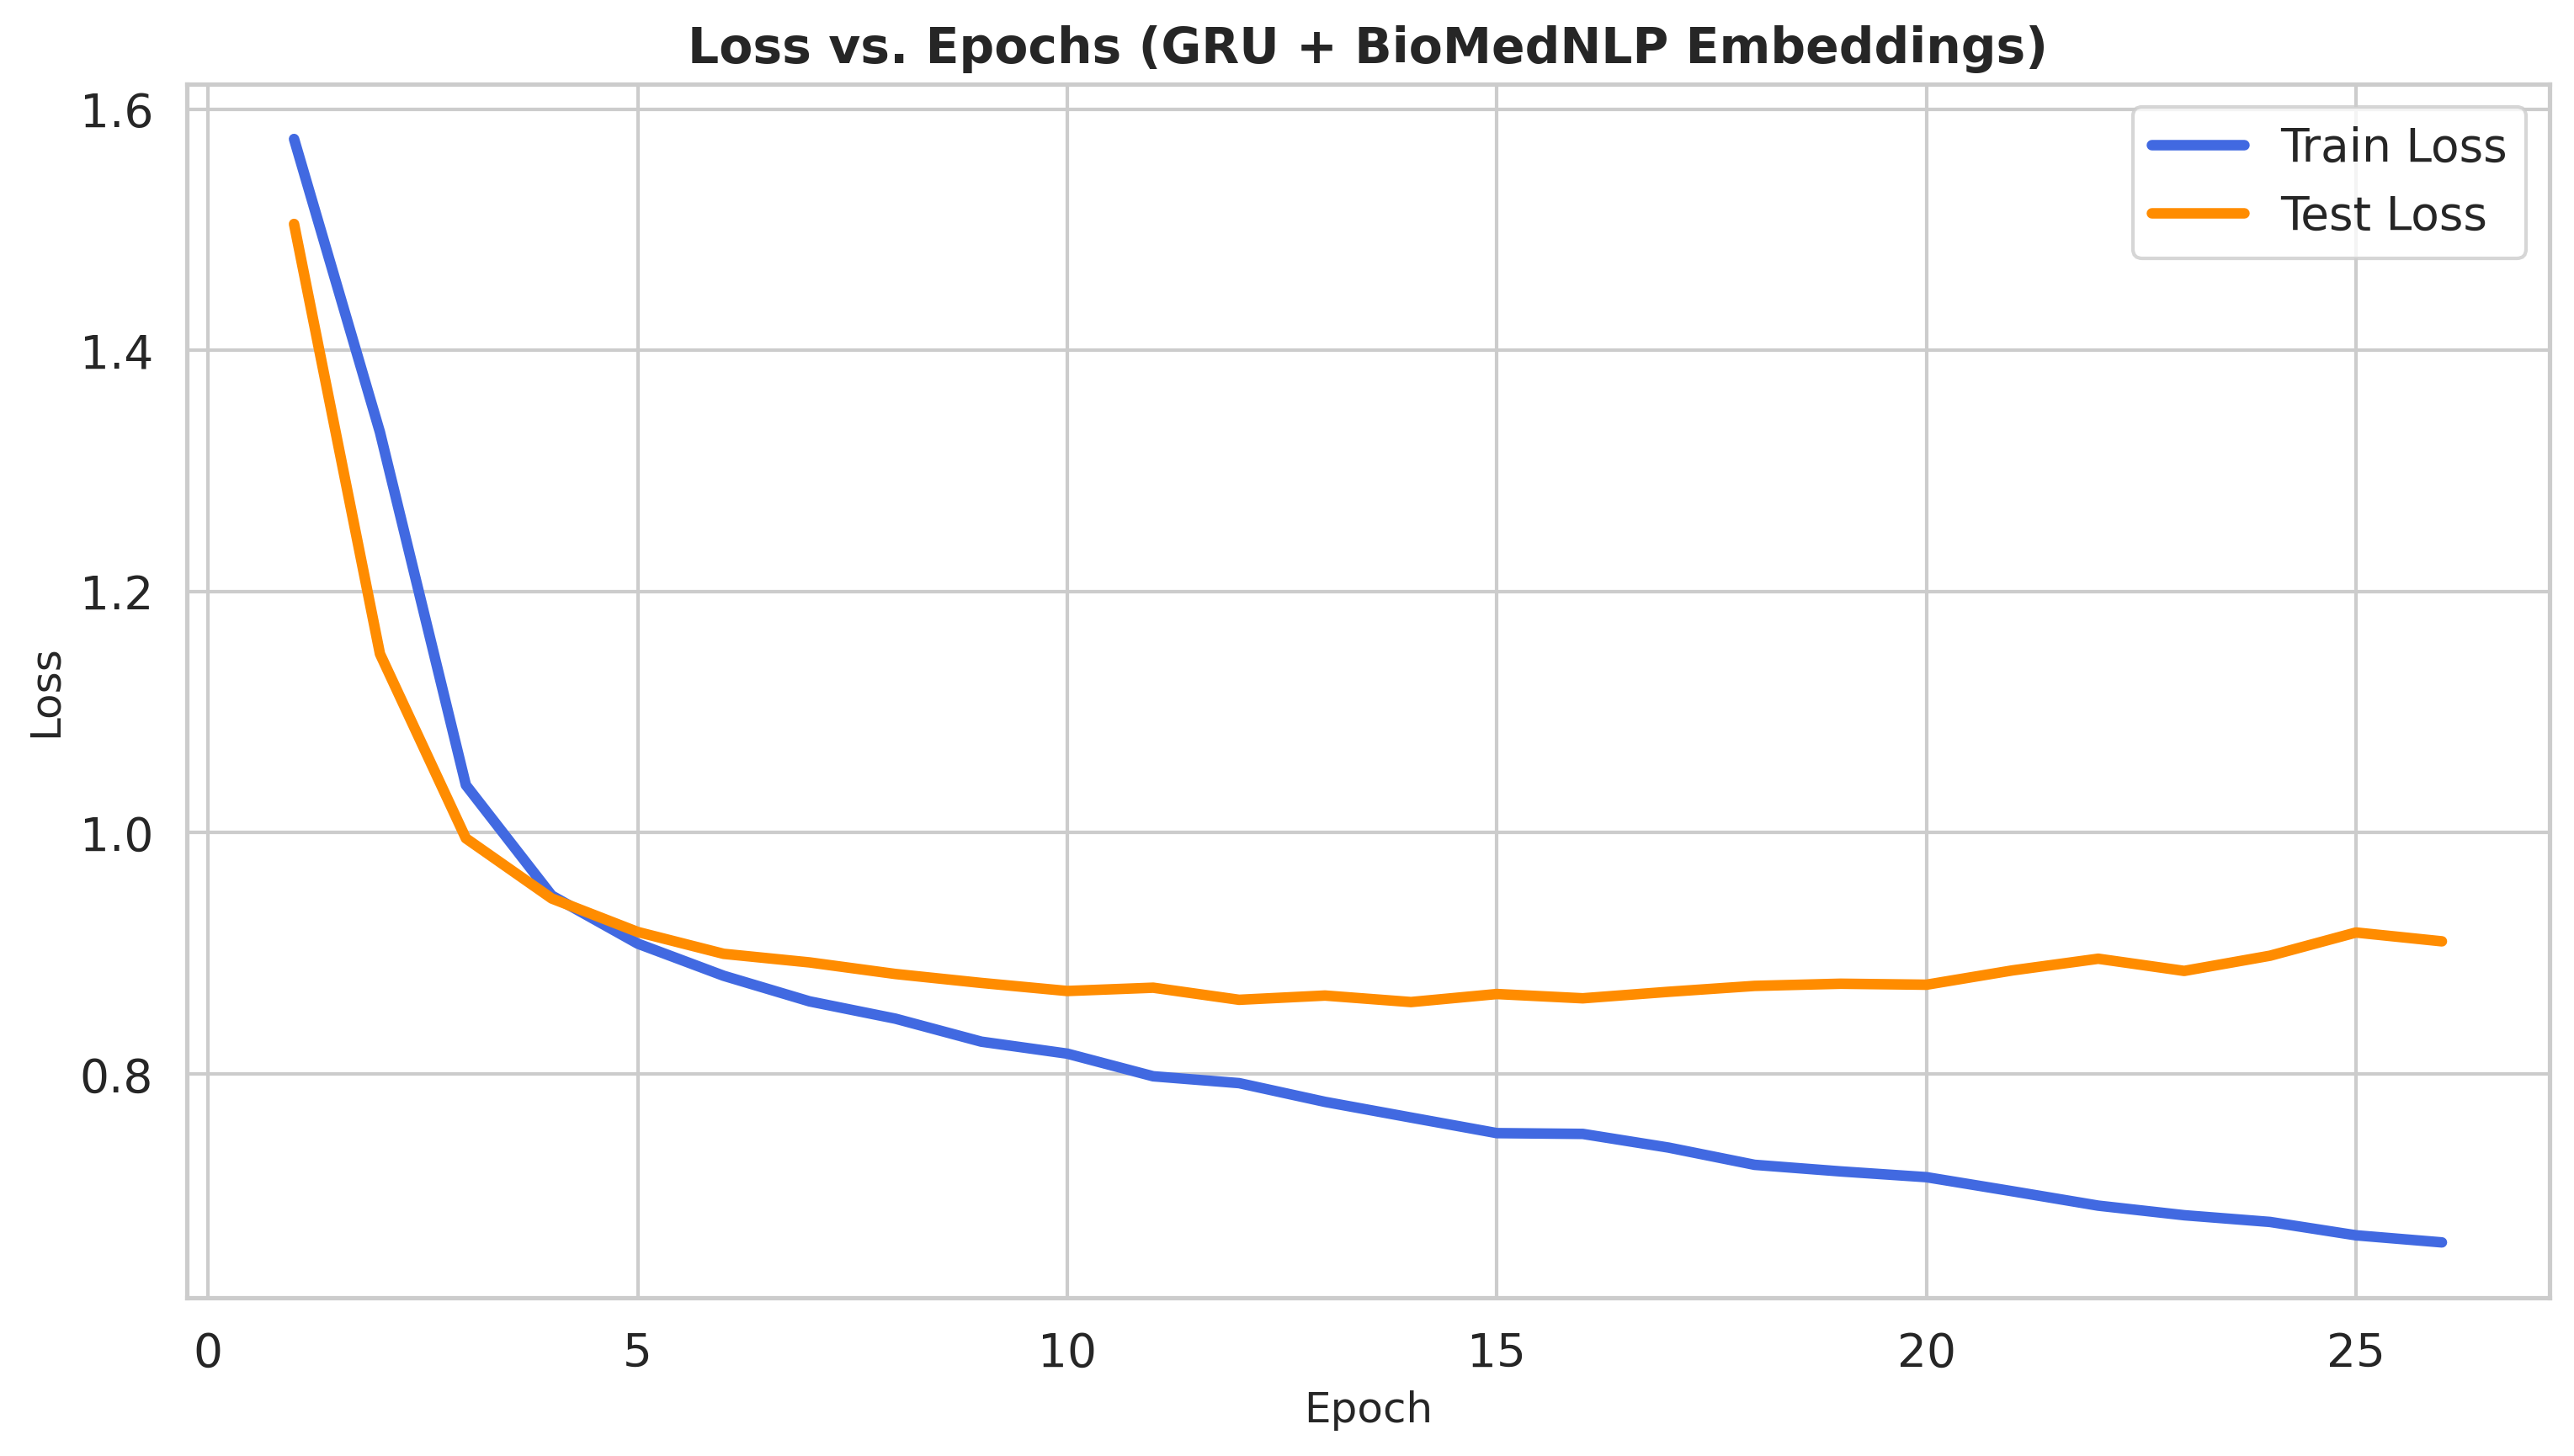

In [ ]:
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})

plt.figure(figsize=(20, 6), dpi=300)

# === 1. Loss Curve ===
plt.subplot(1, 2, 1)

epochs = list(range(1, len(train_losses) + 1))

sns.lineplot(x=epochs, y=train_losses, label='Train Loss', color='royalblue')
sns.lineplot(x=epochs, y=test_losses, label='Test Loss', color='darkorange')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs. Epochs (GRU + BioMedNLP Embeddings)', fontsize=14, weight='bold')
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})

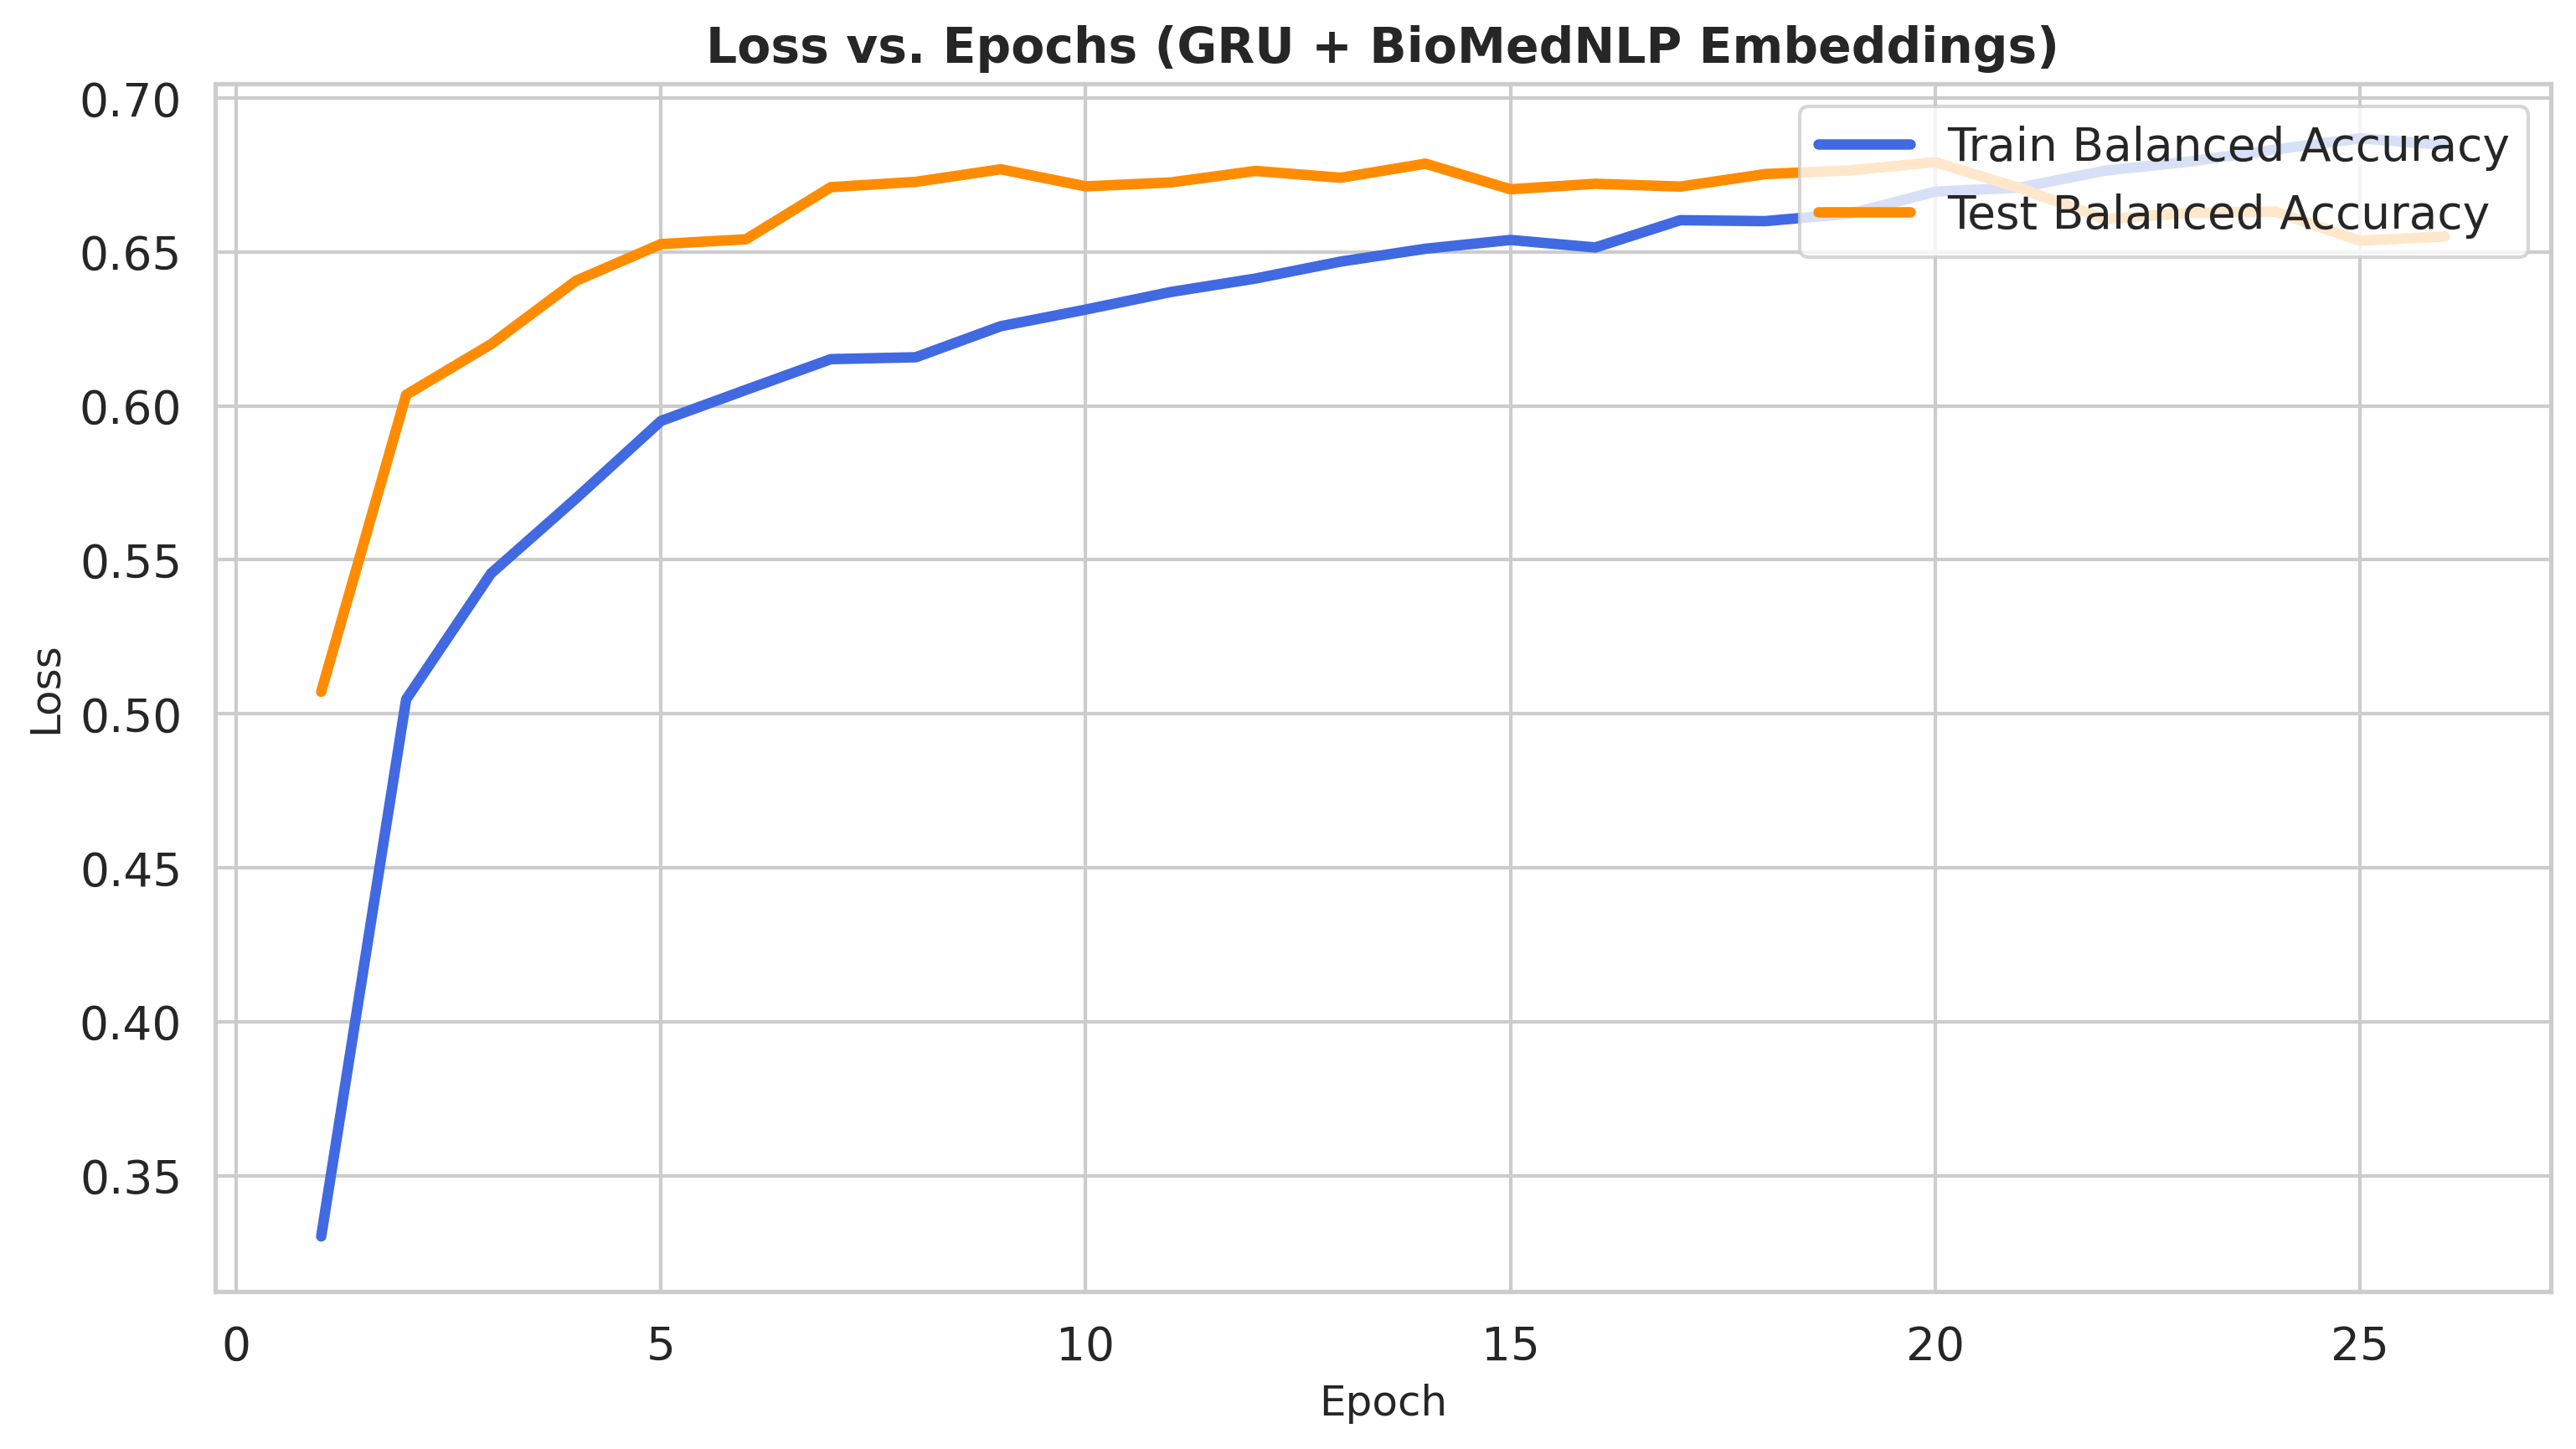

In [ ]:
plt.figure(figsize=(20, 6), dpi=300)

# === 2. Balanced Accurcy Curve ===
plt.subplot(1, 2, 1)

epochs = list(range(1, len(train_losses) + 1))

sns.lineplot(x=epochs, y=train_accuracies, label='Train Balanced Accuracy', color='royalblue')
sns.lineplot(x=epochs, y=test_balanced_accs, label='Test Balanced Accuracy', color='darkorange')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs. Epochs (GRU + BioMedNLP Embeddings)', fontsize=14, weight='bold')
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()

In [ ]:
model = BiomedNLP_LSTM_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device)

model.load_state_dict(torch.load("/content/best_model_weight_class.pth"))
model.eval()

loss_function = torch.nn.CrossEntropyLoss()

# --- Recalculate metrics on test set ---
final_test_loss, final_test_acc, final_test_f1, final_test_bal_acc, final_test_recall, final_test_precision = test_model(
    model, test_loader, loss_function, device
)

# --- Print results ---
print("\n Final Evaluation Metrics of Best Model:")
print(f"Test Loss           : {final_test_loss:.4f}")
print(f"Test Accuracy       : {final_test_acc:.2%}")
print(f"Test F1 Score       : {final_test_f1:.2%}")
print(f"Balanced Accuracy   : {final_test_bal_acc:.2%}")
print(f"Test Precision      : {final_test_precision:.2%}")
print(f"Test Recall         : {final_test_recall:.2%}")


 Final Evaluation Metrics of Best Model:
Test Loss           : 0.9618
Test Accuracy       : 60.53%
Test F1 Score       : 57.83%
Balanced Accuracy   : 67.91%
Test Precision      : 62.26%
Test Recall         : 60.53%


In [ ]:
df_results_BioMedNLP, df_wrong_BioMedNLP, df_correct_BioMedNLP, all_labels_BioMedNLP, all_probs_BioMedNLP = evaluate_and_analyze_BioMedNLP(model, test_loader, device)

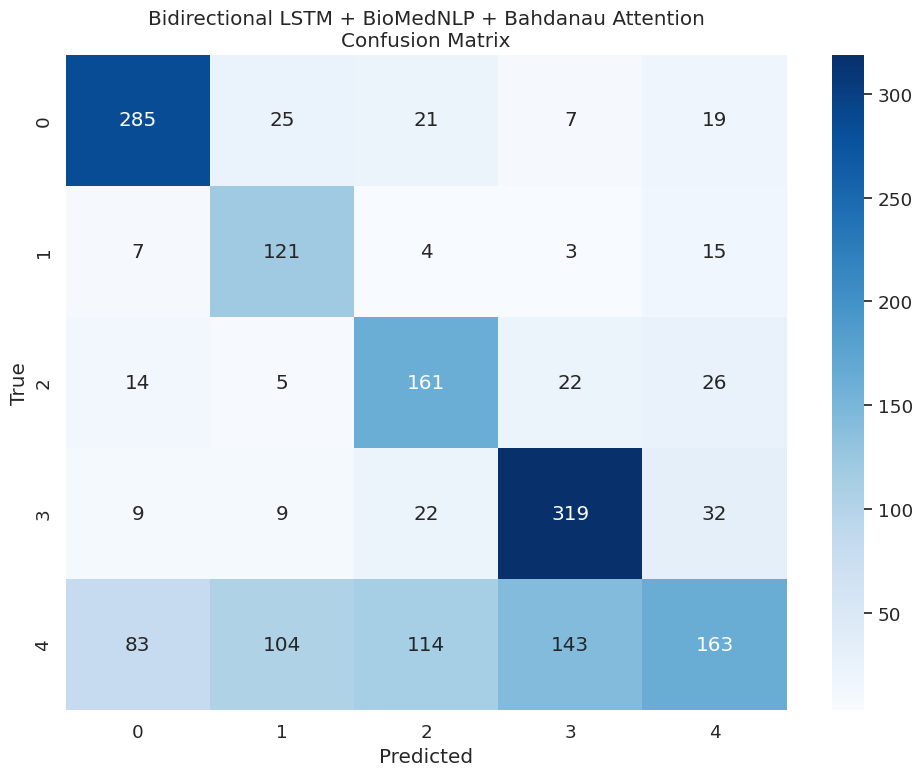

In [ ]:
all_preds_BioMedNLP = np.argmax(np.array(all_probs_BioMedNLP), axis=1)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

plot_confusion_matrix(axes, all_labels_BioMedNLP, all_preds_BioMedNLP, NUM_CLASSES)
axes.set_title("Bidirectional LSTM + BioMedNLP + Bahdanau Attention\nConfusion Matrix")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 5
class_names = [f'Class {i}' for i in range(n_classes)]

y_true_BioMedNLP = np.array(all_labels_BioMedNLP)
y_score_BioMedNLP = np.array(all_probs_BioMedNLP)
y_true_bin_BioMedNLP = label_binarize(y_true_BioMedNLP, classes=list(range(n_classes)))

if y_score_BioMedNLP.ndim != 2 or y_score_BioMedNLP.shape[1] != n_classes:
    raise ValueError("y_score_pubMedBert must be an array with shape (n_samples, n_classes) containing probabilities for each class.")

fpr_BioMedNLP, tpr_BioMedNLP, roc_auc_BioMedNLP = {}, {}, {}

for i in range(n_classes):

    fpr_BioMedNLP[i], tpr_BioMedNLP[i], _ = roc_curve(y_true_bin_BioMedNLP[:, i], y_score_BioMedNLP[:, i])
    roc_auc_BioMedNLP[i] = auc(fpr_BioMedNLP[i], tpr_BioMedNLP[i])

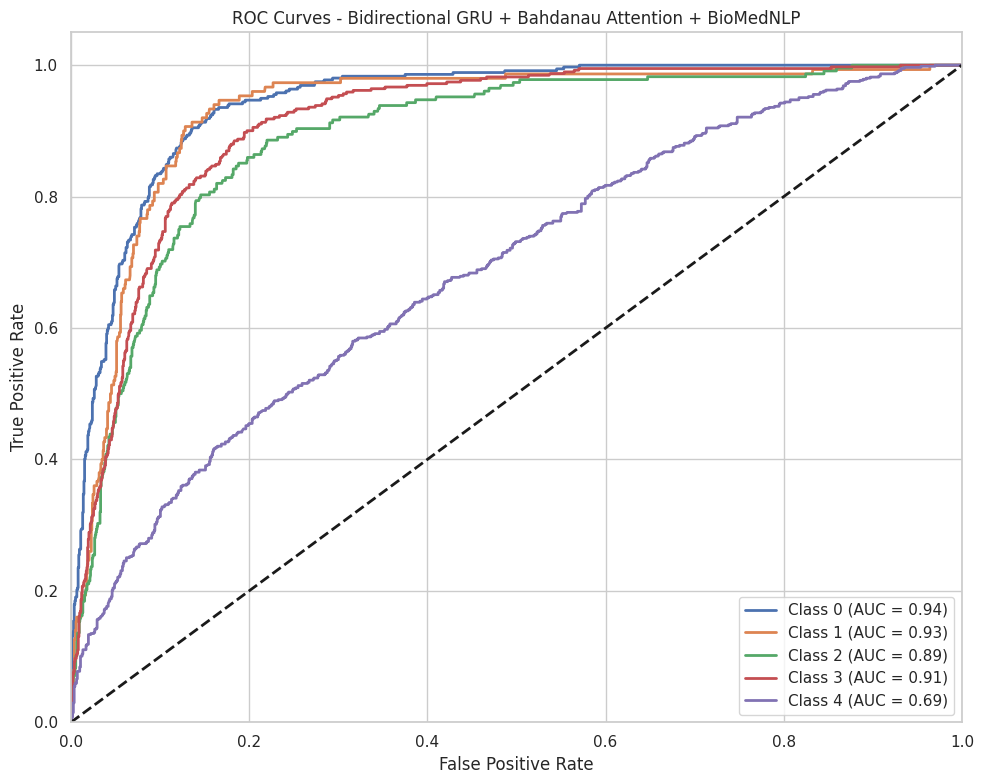

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # Single plot

# Plot ROC Curves
for i in range(n_classes):
    axes.plot(fpr_BioMedNLP[i], tpr_BioMedNLP[i], lw=2,
              label=f'{class_names[i]} (AUC = {roc_auc_BioMedNLP[i]:.2f})')

# Diagonal reference line
axes.plot([0, 1], [0, 1], 'k--', lw=2)

# Axis labels and formatting
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('ROC Curves - Bidirectional GRU + Bahdanau Attention + BioMedNLP')
axes.legend(loc='lower right')
axes.grid(True)

plt.tight_layout()
plt.savefig("biomednlp_roc_curves.png", dpi=300)
plt.show()

In [ ]:
df_wrong_BioMedNLP.head()

index  true_label  predicted_label  probability  \
0      0           4                2     0.667867   
1      8           3                4     0.639941   
2     10           2                4     0.591899   
3     12           4                3     0.889860   
4     15           4                3     0.494756   

                                                text  
0  The "military family syndrome" revisited: "by ...  
1  Prognostic factors in acute renal failure foll...  
2  Rate of oxyhemoglobin desaturation in obstruct...  
3  Marfanoid children. Etiologic heterogeneity an...  
4  Microangiopathy in the eosinophilia-myalgia sy...

## **III.2 Few Shot Learning**

In [ ]:
k_values = range(1, 11)  # Few-shot from k=1 to 10
BERT_DIM = 768
HIDDEN_DIM = 156
DROPOUT = 0.4

model_metrics = {
    "K-shot": [],
    "Model": [],
    "Test Accuracy": [],
    "F1": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

patience = 4
num_epochs = 15
for k in k_values:
    print(f"\n--- K-Shot = {k} ---")

    X_kshot, y_kshot = get_k_shot_data_from_original(combined_dataset, k, NUM_CLASSES)
    kshot_dataset = BiomedNLPDataset(X_kshot, y_kshot, tokenizer)
    kshot_loader = DataLoader(kshot_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = BiomedNLP_LSTM_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device)
    print(f"{count_parameters(model)} model parameters")
    print()
    print(model)

    learning_rate = 8e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_kshot), y=y_kshot)
    loss_function = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

    # Train with early stopping
    best_val_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, kshot_loader, optimizer, loss_function, device)
        val_acc, val_f1, val_loss = evaluate_model(model, test_loader, loss_function, device)

        print(f"K={k} | Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    avg_loss, avg_accuracy, f1, balanced_acc, recall, precision = test_model(model, test_loader, loss_function, device)

    # Log metrics
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    model_metrics["K-shot"].append(k)
    model_metrics["Model"].append("LSTM-BioMedNLP")
    model_metrics["Test Accuracy"].append(avg_accuracy)
    model_metrics["F1"].append(f1)
    model_metrics["Balanced Accuracy"].append(balanced_acc)
    model_metrics["Recall"].append(recall)
    model_metrics["Precision"].append(precision)

# Convert results to DataFrame
df = pd.DataFrame(model_metrics)


--- K-Shot = 1 ---
1206197 model parameters

BiomedNLP_LSTM_Attention(
  (lstm): LSTM(768, 156, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=312, out_features=156, bias=True)
    (v): Linear(in_features=156, out_features=1, bias=False)
  )
  (fc): Linear(in_features=312, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
K=1 | Epoch 1/15 - Train Loss: 1.5750, Train Acc: 0.2000, Val Loss: 1.6046, Val Acc: 0.2000, Val F1: 0.0704
K=1 | Epoch 2/15 - Train Loss: 1.5258, Train Acc: 0.2000, Val Loss: 1.5987, Val Acc: 0.1998, Val F1: 0.0715
K=1 | Epoch 3/15 - Train Loss: 1.5350, Train Acc: 0.4000, Val Loss: 1.5937, Val Acc: 0.2109, Val F1: 0.1524
K=1 | Epoch 4/15 - Train Loss: 1.4491, Train Acc: 0.6000, Val Loss: 1.5964, Val Acc: 0.2155, Val F1: 0.1463
K=1 | Epoch 5/15 - Train Loss: 1.5014, Train Acc: 0.4000, Val Loss: 1.5993, Val Acc: 0.2198, Val F1: 0.1723
K=1 | Epoch 6/15 - Train Loss: 1.4612, Train Acc: 0.6000, Va

In [ ]:
# --- Plotting ---
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
palette = sns.color_palette("Set2")

def plot_model_performance(df, model_name, color, title_prefix="Model Performance"):
    model_df = df[df["Model"] == model_name]
    metrics_to_plot = ["F1", "Balanced Accuracy", "Recall", "Precision"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        sns.lineplot(
            data=model_df,
            x="K-shot",
            y=metric,
            ax=axes[i],
            color=color,
            marker="o",
            linewidth=2.2,
            markersize=6,
        )
        axes[i].set_title(metric, fontsize=14)
        axes[i].set_xlabel("K-shot")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    plt.suptitle(f"{title_prefix} for {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

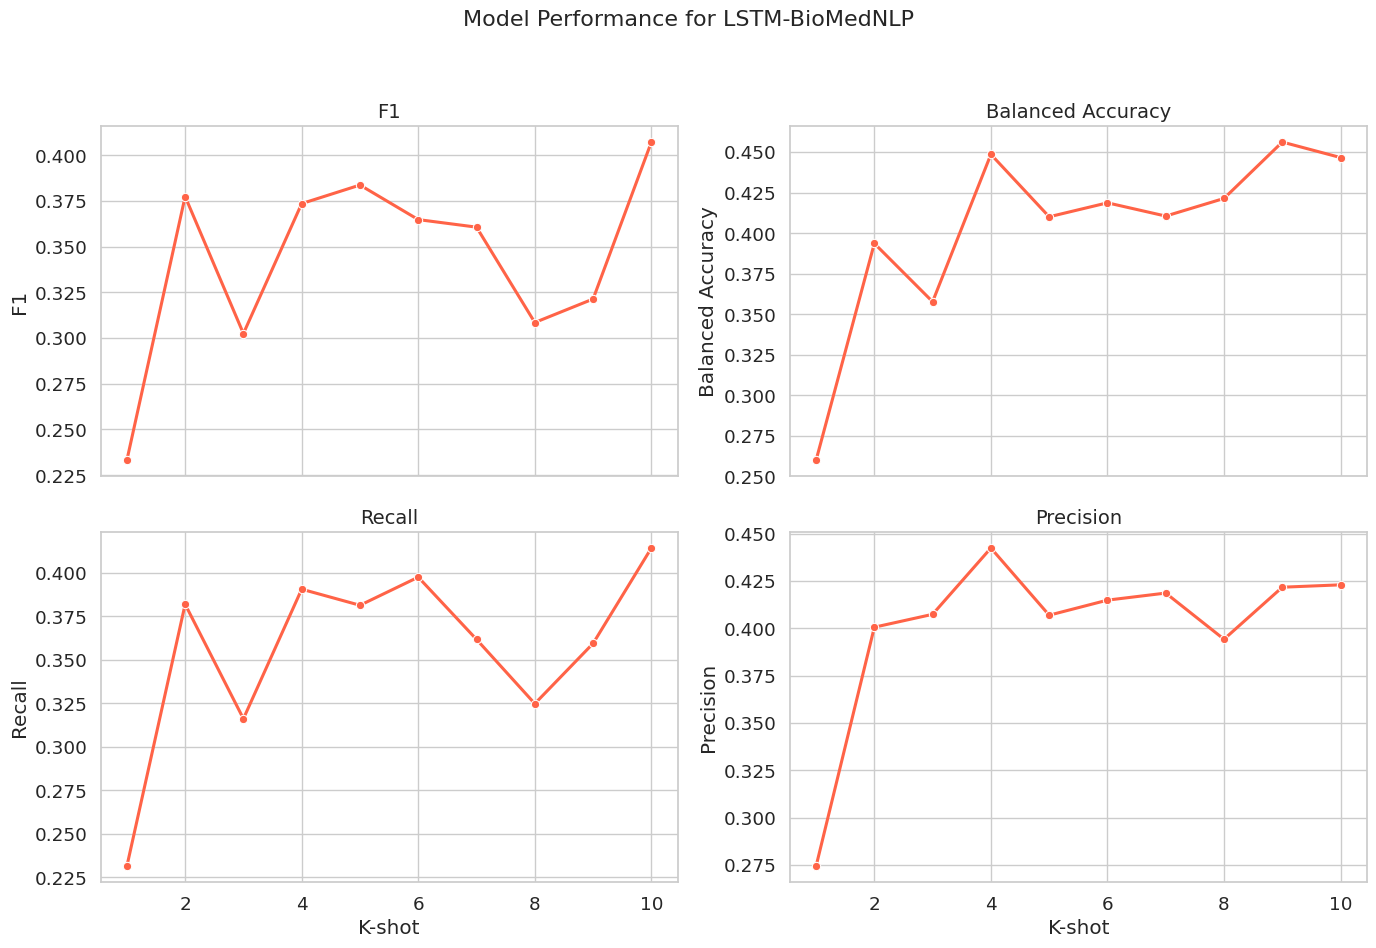

In [ ]:
# Plot results
plot_model_performance(df, "LSTM-BioMedNLP", "tomato")

Maximum values per metric:
Balanced Accuracy: 0.4562 (at K-shot = 9)
F1: 0.4072 (at K-shot = 10)
Recall: 0.4143 (at K-shot = 10)
Precision: 0.4424 (at K-shot = 4)


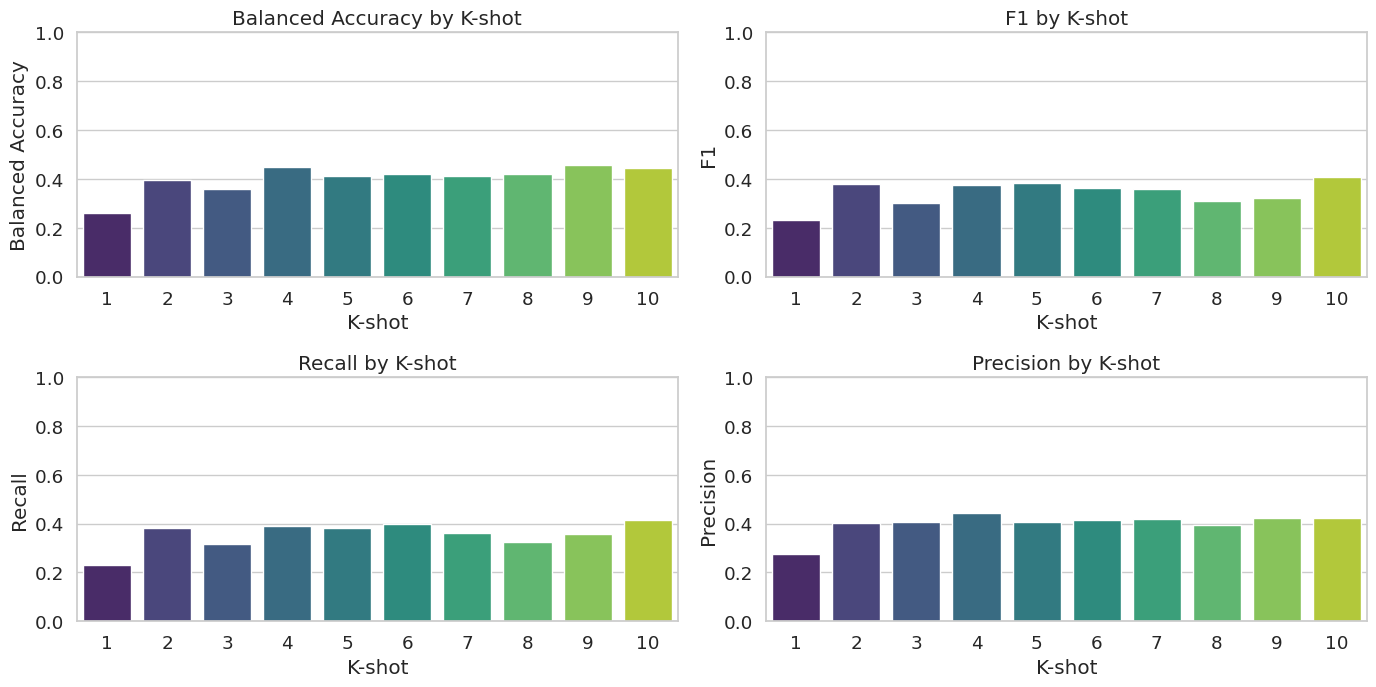

In [ ]:
metrics = ["Balanced Accuracy", "F1", "Recall", "Precision"]

# Print max values for each metric
print("Maximum values per metric:")
for metric in metrics:
    max_val = df[metric].max()
    max_k = df.loc[df[metric].idxmax(), "K-shot"]
    print(f"{metric}: {max_val:.4f} (at K-shot = {max_k})")

# Then plot the histograms
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x="K-shot", y=metric, data=df, palette="viridis")
    plt.title(f"{metric} by K-shot")
    plt.ylim(0, 1)
    plt.xlabel("K-shot")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# **IV. GRU + Bahdanau Attention using Fasttext (300d)**

In [ ]:
batch_size = 16
train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


#### **Few-Shot Learning**

In [ ]:
def get_few_shot_subset(X_tensor, y_tensor, k_shot):
    X_few = []
    y_few = []
    unique_classes = torch.unique(y_tensor)
    for cls in unique_classes:
        indices = (y_tensor == cls).nonzero(as_tuple=True)[0]
        selected = indices[torch.randperm(len(indices))[:k_shot]]
        X_few.append(X_tensor[selected])
        y_few.append(y_tensor[selected])
    X_few = torch.cat(X_few)
    y_few = torch.cat(y_few)
    return X_few, y_few

In [ ]:
EMBEDDING_DIM = 300
NUM_LAYERS = 1
NUM_CLASSES = 5
embedding_matrix_glove = load_glove_embeddings('/content/drive/MyDrive/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)
embedding_matrix_fasttext = load_fasttext_embeddings('/content/drive/MyDrive/cc.en.300.vec/cc.en.300.vec', word_to_index, EMBEDDING_DIM)

In [ ]:
k_values = range(1, 11)  # Few-shot from k=1 to 10
NUM_CLASSES = 5
HIDDEN_DIM = 286
DROPOUT = 0.6

num_epochs = 30

X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
X_combined_tensor = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_combined_tensor = torch.cat((y_train_tensor, y_val_tensor), dim=0)

model_metrics = {
    "K-shot": [],
    "Model": [],
    "Test Accuracy": [],
    "F1": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

patience = 15
num_epochs = 50
for k in k_values:
    print(f"\n--- K-Shot = {k} ---")

    X_few, y_few = get_few_shot_subset(X_combined_tensor, y_combined_tensor, k_shot=k)
    few_shot_dataset = TextDataset(X_few, y_few, raw_text_data=X_combined)
    few_shot_loader = DataLoader(few_shot_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    model = GRU_BahdanauAttention(
                embedding_matrix=embedding_matrix_fasttext,
                hidden_dim=HIDDEN_DIM,
                num_layers=NUM_LAYERS,
                dropout_prob=DROPOUT
            ).to(device)
    print(f"{count_parameters(model)} model parameters")
    print()
    print(model)

    learning_rate = 2e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Train with early stopping
    best_val_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, few_shot_loader, optimizer, loss_function, device)
        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

        print(f"K={k} | Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    avg_loss, avg_accuracy, f1, balanced_acc, recall, precision = test_epoch(model, test_loader, loss_function, device)

    # Log metrics
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    model_metrics["K-shot"].append(k)
    model_metrics["Model"].append("GRU-Fasttext")
    model_metrics["Test Accuracy"].append(avg_accuracy)
    model_metrics["F1"].append(f1)
    model_metrics["Balanced Accuracy"].append(balanced_acc)
    model_metrics["Recall"].append(recall)
    model_metrics["Precision"].append(precision)

# Convert results to DataFrame
df = pd.DataFrame(model_metrics)


--- K-Shot = 1 ---
7455937 model parameters

GRU_BahdanauAttention(
  (embedding): Embedding(20933, 300)
  (gru): GRU(300, 286, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=572, out_features=286, bias=True)
    (v): Linear(in_features=286, out_features=1, bias=False)
  )
  (fc): Linear(in_features=572, out_features=5, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=1 | Epoch 1/50 - Train Loss: 1.5990, Train Acc: 0.4000, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 2/50 - Train Loss: 1.5981, Train Acc: 0.4000, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 3/50 - Train Loss: 1.6140, Train Acc: 0.2000, Test Loss: 1.6108, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 4/50 - Train Loss: 1.6164, Train Acc: 0.2000, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 5/50 - Train Loss: 1.6004, Train Acc: 0.2000, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 6/50 - Train Loss: 1.5970, Train Acc: 0.6000, Test Loss: 1.6105, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 7/50 - Train Loss: 1.5963, Train Acc: 0.4000, Test Loss: 1.6105, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 8/50 - Train Loss: 1.6067, Train Acc: 0.2000, Test Loss: 1.6104, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoch 9/50 - Train Loss: 1.6044, Train Acc: 0.2000, Test Loss: 1.6104, Test Acc: 0.2000, Val F1: 0.0786
K=1 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=2 | Epoch 1/50 - Train Loss: 1.6129, Train Acc: 0.1000, Test Loss: 1.6110, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 2/50 - Train Loss: 1.6163, Train Acc: 0.1000, Test Loss: 1.6108, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 3/50 - Train Loss: 1.6009, Train Acc: 0.1000, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 4/50 - Train Loss: 1.6107, Train Acc: 0.1000, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 5/50 - Train Loss: 1.6111, Train Acc: 0.1000, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 6/50 - Train Loss: 1.6115, Train Acc: 0.2000, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 7/50 - Train Loss: 1.6031, Train Acc: 0.3000, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 8/50 - Train Loss: 1.6090, Train Acc: 0.2000, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 9/50 - Train Loss: 1.6075, Train Acc: 0.1000, Test Loss: 1.6104, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=3 | Epoch 1/50 - Train Loss: 1.6034, Train Acc: 0.2667, Test Loss: 1.6136, Test Acc: 0.2000, Val F1: 0.0340
K=3 | Epoch 2/50 - Train Loss: 1.6073, Train Acc: 0.2000, Test Loss: 1.6136, Test Acc: 0.2000, Val F1: 0.0340
K=3 | Epoch 3/50 - Train Loss: 1.6091, Train Acc: 0.1333, Test Loss: 1.6134, Test Acc: 0.2005, Val F1: 0.0352
K=3 | Epoch 4/50 - Train Loss: 1.6100, Train Acc: 0.2000, Test Loss: 1.6135, Test Acc: 0.1997, Val F1: 0.0351
K=3 | Epoch 5/50 - Train Loss: 1.6064, Train Acc: 0.2000, Test Loss: 1.6134, Test Acc: 0.1997, Val F1: 0.0351
K=3 | Epoch 6/50 - Train Loss: 1.6132, Train Acc: 0.1333, Test Loss: 1.6134, Test Acc: 0.1994, Val F1: 0.0361
K=3 | Epoch 7/50 - Train Loss: 1.6029, Train Acc: 0.2667, Test Loss: 1.6134, Test Acc: 0.2010, Val F1: 0.0395
K=3 | Epoch 8/50 - Train Loss: 1.6087, Train Acc: 0.2667, Test Loss: 1.6134, Test Acc: 0.2026, Val F1: 0.0428
K=3 | Epoch 9/50 - Train Loss: 1.6094, Train Acc: 0.0667, Test Loss: 1.6133, Test Acc: 0.2026, Val F1: 0.0428
K=3 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=4 | Epoch 1/50 - Train Loss: 1.6285, Train Acc: 0.2000, Test Loss: 1.6121, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 2/50 - Train Loss: 1.6170, Train Acc: 0.2000, Test Loss: 1.6123, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 3/50 - Train Loss: 1.6123, Train Acc: 0.1000, Test Loss: 1.6122, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 4/50 - Train Loss: 1.5984, Train Acc: 0.2000, Test Loss: 1.6118, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 5/50 - Train Loss: 1.6113, Train Acc: 0.3000, Test Loss: 1.6121, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 6/50 - Train Loss: 1.6055, Train Acc: 0.2500, Test Loss: 1.6118, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 7/50 - Train Loss: 1.5951, Train Acc: 0.2500, Test Loss: 1.6118, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 8/50 - Train Loss: 1.6217, Train Acc: 0.2000, Test Loss: 1.6119, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 9/50 - Train Loss: 1.6119, Train Acc: 0.2500, Test Loss: 1.6119, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=5 | Epoch 1/50 - Train Loss: 1.6094, Train Acc: 0.2000, Test Loss: 1.6108, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 2/50 - Train Loss: 1.6206, Train Acc: 0.1600, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 3/50 - Train Loss: 1.6107, Train Acc: 0.0800, Test Loss: 1.6105, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 4/50 - Train Loss: 1.6102, Train Acc: 0.2000, Test Loss: 1.6103, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 5/50 - Train Loss: 1.6135, Train Acc: 0.2400, Test Loss: 1.6103, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 6/50 - Train Loss: 1.6052, Train Acc: 0.2000, Test Loss: 1.6105, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 7/50 - Train Loss: 1.6161, Train Acc: 0.1600, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 8/50 - Train Loss: 1.6135, Train Acc: 0.1600, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 9/50 - Train Loss: 1.6143, Train Acc: 0.1200, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=6 | Epoch 1/50 - Train Loss: 1.6142, Train Acc: 0.1333, Test Loss: 1.6032, Test Acc: 0.2000, Val F1: 0.0759
K=6 | Epoch 2/50 - Train Loss: 1.6131, Train Acc: 0.1667, Test Loss: 1.6032, Test Acc: 0.2000, Val F1: 0.0759
K=6 | Epoch 3/50 - Train Loss: 1.6114, Train Acc: 0.1333, Test Loss: 1.6032, Test Acc: 0.2000, Val F1: 0.0759
K=6 | Epoch 4/50 - Train Loss: 1.6069, Train Acc: 0.2667, Test Loss: 1.6033, Test Acc: 0.2000, Val F1: 0.0759
K=6 | Epoch 5/50 - Train Loss: 1.6086, Train Acc: 0.1333, Test Loss: 1.6034, Test Acc: 0.2000, Val F1: 0.0759
K=6 | Epoch 6/50 - Train Loss: 1.6115, Train Acc: 0.1000, Test Loss: 1.6034, Test Acc: 0.2005, Val F1: 0.0771
K=6 | Epoch 7/50 - Train Loss: 1.6084, Train Acc: 0.2333, Test Loss: 1.6035, Test Acc: 0.2021, Val F1: 0.0807
K=6 | Epoch 8/50 - Train Loss: 1.6124, Train Acc: 0.1667, Test Loss: 1.6035, Test Acc: 0.2021, Val F1: 0.0807
K=6 | Epoch 9/50 - Train Loss: 1.6086, Train Acc: 0.2667, Test Loss: 1.6035, Test Acc: 0.2032, Val F1: 0.0830
K=6 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=7 | Epoch 1/50 - Train Loss: 1.6136, Train Acc: 0.3143, Test Loss: 1.6035, Test Acc: 0.2000, Val F1: 0.0759
K=7 | Epoch 2/50 - Train Loss: 1.6131, Train Acc: 0.3143, Test Loss: 1.6039, Test Acc: 0.1995, Val F1: 0.0758
K=7 | Epoch 3/50 - Train Loss: 1.6107, Train Acc: 0.1429, Test Loss: 1.6038, Test Acc: 0.1996, Val F1: 0.0781
K=7 | Epoch 4/50 - Train Loss: 1.6083, Train Acc: 0.2000, Test Loss: 1.6040, Test Acc: 0.2000, Val F1: 0.0759
K=7 | Epoch 5/50 - Train Loss: 1.6000, Train Acc: 0.2571, Test Loss: 1.6035, Test Acc: 0.2005, Val F1: 0.0825
K=7 | Epoch 6/50 - Train Loss: 1.6185, Train Acc: 0.1714, Test Loss: 1.6035, Test Acc: 0.2043, Val F1: 0.0990
K=7 | Epoch 7/50 - Train Loss: 1.6065, Train Acc: 0.0571, Test Loss: 1.6036, Test Acc: 0.2011, Val F1: 0.0827
K=7 | Epoch 8/50 - Train Loss: 1.6098, Train Acc: 0.2000, Test Loss: 1.6036, Test Acc: 0.2011, Val F1: 0.0827
K=7 | Epoch 9/50 - Train Loss: 1.6142, Train Acc: 0.1429, Test Loss: 1.6037, Test Acc: 0.2013, Val F1: 0.0849
K=7 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=8 | Epoch 1/50 - Train Loss: 1.6103, Train Acc: 0.1250, Test Loss: 1.6069, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 2/50 - Train Loss: 1.6150, Train Acc: 0.1750, Test Loss: 1.6070, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 3/50 - Train Loss: 1.6140, Train Acc: 0.1750, Test Loss: 1.6069, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 4/50 - Train Loss: 1.6043, Train Acc: 0.2250, Test Loss: 1.6067, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 5/50 - Train Loss: 1.6072, Train Acc: 0.2750, Test Loss: 1.6068, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 6/50 - Train Loss: 1.6106, Train Acc: 0.1500, Test Loss: 1.6069, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 7/50 - Train Loss: 1.6073, Train Acc: 0.2500, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 8/50 - Train Loss: 1.6115, Train Acc: 0.2000, Test Loss: 1.6068, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoch 9/50 - Train Loss: 1.6111, Train Acc: 0.1750, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.0759
K=8 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=9 | Epoch 1/50 - Train Loss: 1.6161, Train Acc: 0.0889, Test Loss: 1.6108, Test Acc: 0.2150, Val F1: 0.0800
K=9 | Epoch 2/50 - Train Loss: 1.6122, Train Acc: 0.2000, Test Loss: 1.6108, Test Acc: 0.2112, Val F1: 0.0445
K=9 | Epoch 3/50 - Train Loss: 1.6127, Train Acc: 0.2000, Test Loss: 1.6108, Test Acc: 0.2253, Val F1: 0.0551
K=9 | Epoch 4/50 - Train Loss: 1.6066, Train Acc: 0.1556, Test Loss: 1.6107, Test Acc: 0.2411, Val F1: 0.0878
K=9 | Epoch 5/50 - Train Loss: 1.6086, Train Acc: 0.2222, Test Loss: 1.6108, Test Acc: 0.2378, Val F1: 0.0751
K=9 | Epoch 6/50 - Train Loss: 1.6082, Train Acc: 0.2444, Test Loss: 1.6107, Test Acc: 0.2406, Val F1: 0.0758
K=9 | Epoch 7/50 - Train Loss: 1.6068, Train Acc: 0.2222, Test Loss: 1.6107, Test Acc: 0.2406, Val F1: 0.0757
K=9 | Epoch 8/50 - Train Loss: 1.6051, Train Acc: 0.2000, Test Loss: 1.6106, Test Acc: 0.2438, Val F1: 0.0793
K=9 | Epoch 9/50 - Train Loss: 1.6134, Train Acc: 0.1556, Test Loss: 1.6106, Test Acc: 0.2441, Val F1: 0.0785
K=9 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=10 | Epoch 1/50 - Train Loss: 1.6094, Train Acc: 0.2800, Test Loss: 1.6052, Test Acc: 0.2006, Val F1: 0.1646
K=10 | Epoch 2/50 - Train Loss: 1.6120, Train Acc: 0.1400, Test Loss: 1.6056, Test Acc: 0.2132, Val F1: 0.2029
K=10 | Epoch 3/50 - Train Loss: 1.6110, Train Acc: 0.1600, Test Loss: 1.6050, Test Acc: 0.2024, Val F1: 0.1656
K=10 | Epoch 4/50 - Train Loss: 1.6049, Train Acc: 0.2000, Test Loss: 1.6053, Test Acc: 0.2069, Val F1: 0.1804
K=10 | Epoch 5/50 - Train Loss: 1.6213, Train Acc: 0.1800, Test Loss: 1.6055, Test Acc: 0.2102, Val F1: 0.1913
K=10 | Epoch 6/50 - Train Loss: 1.6090, Train Acc: 0.1400, Test Loss: 1.6052, Test Acc: 0.2024, Val F1: 0.1656
K=10 | Epoch 7/50 - Train Loss: 1.6086, Train Acc: 0.2600, Test Loss: 1.6054, Test Acc: 0.2026, Val F1: 0.1666
K=10 | Epoch 8/50 - Train Loss: 1.6079, Train Acc: 0.2600, Test Loss: 1.6054, Test Acc: 0.2142, Val F1: 0.2003
K=10 | Epoch 9/50 - Train Loss: 1.6175, Train Acc: 0.1600, Test Loss: 1.6054, Test Acc: 0.2109, Val F1: 0.1928
K

In [ ]:
# --- Plotting ---
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 3})
palette = sns.color_palette("Set2")

def plot_model_performance(df, model_name, color, title_prefix="Model Performance"):
    model_df = df[df["Model"] == model_name]
    metrics_to_plot = ["F1", "Balanced Accuracy", "Recall", "Precision"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        sns.lineplot(
            data=model_df,
            x="K-shot",
            y=metric,
            ax=axes[i],
            color=color,
            marker="o",
            linewidth=2.2,
            markersize=6,
        )
        axes[i].set_title(metric, fontsize=14)
        axes[i].set_xlabel("K-shot")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    plt.suptitle(f"{title_prefix} for {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

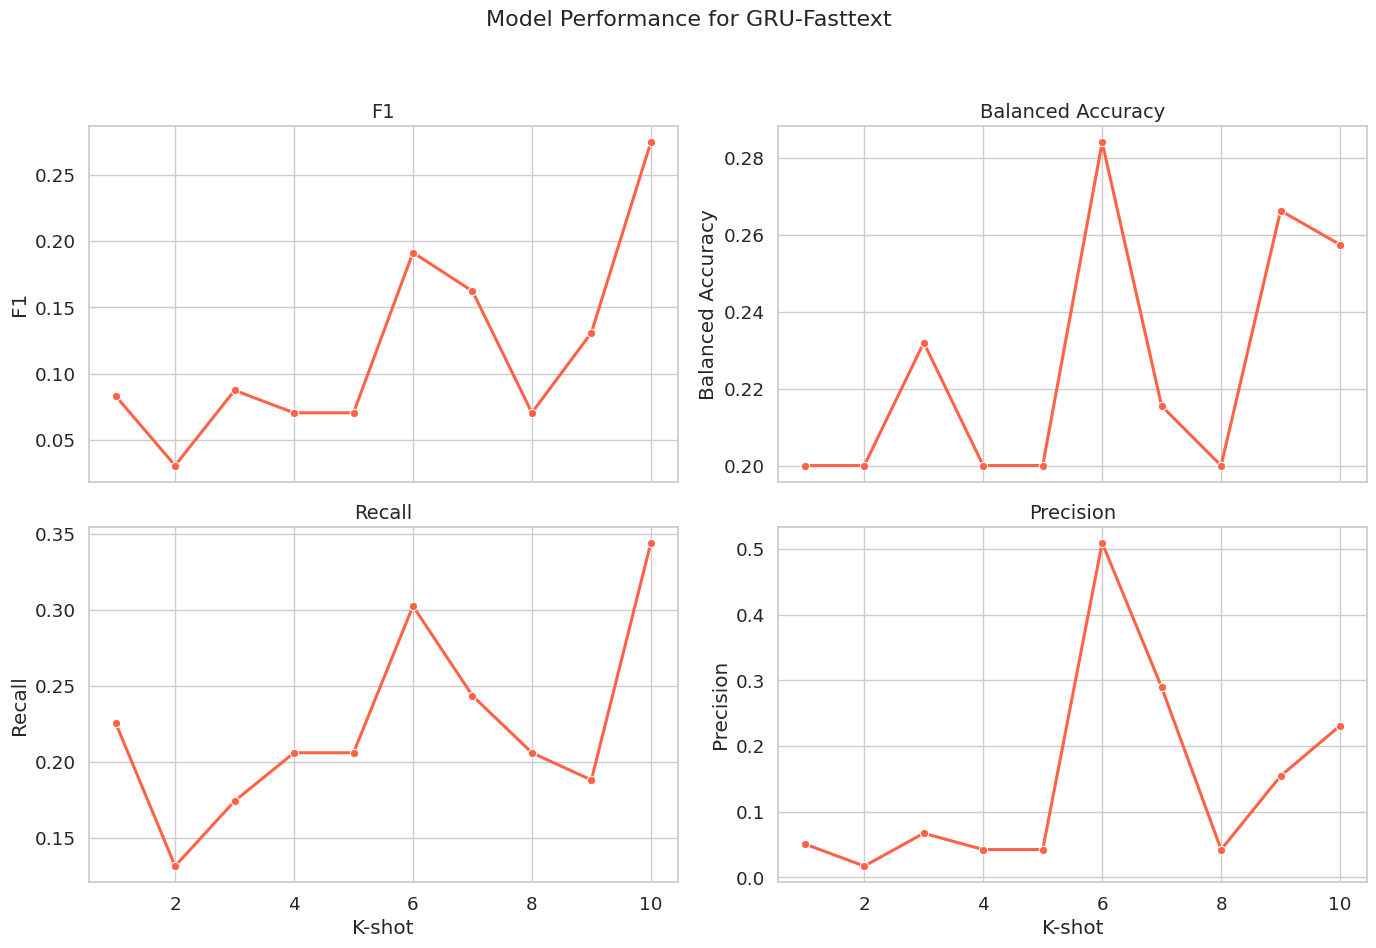

In [ ]:
# Plot results
plot_model_performance(df, "GRU-Fasttext", "tomato")

Maximum values per metric:
Balanced Accuracy: 0.2840 (at K-shot = 6)
F1: 0.2744 (at K-shot = 10)
Recall: 0.3439 (at K-shot = 10)
Precision: 0.5093 (at K-shot = 6)


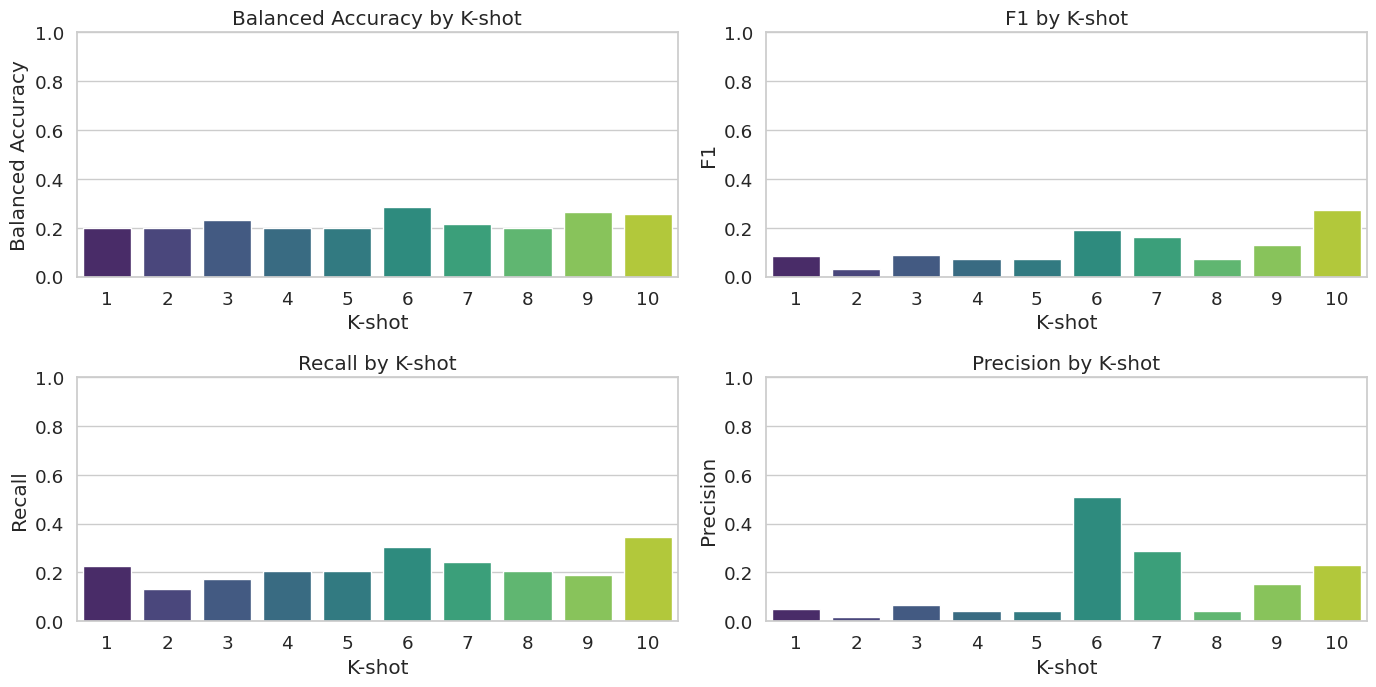

In [ ]:
metrics = ["Balanced Accuracy", "F1", "Recall", "Precision"]

# Print max values for each metric
print("Maximum values per metric:")
for metric in metrics:
    max_val = df[metric].max()
    max_k = df.loc[df[metric].idxmax(), "K-shot"]
    print(f"{metric}: {max_val:.4f} (at K-shot = {max_k})")

# Then plot the histograms
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x="K-shot", y=metric, data=df, palette="viridis")
    plt.title(f"{metric} by K-shot")
    plt.ylim(0, 1)
    plt.xlabel("K-shot")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# **V. LSTM + Bahdanau Attention using Fasttext (300d)**

#### **Few-Shot Learning**

In [ ]:
k_values = range(1, 11)  # Few-shot from k=1 to 10
NUM_CLASSES = 5
HIDDEN_DIM = 286
DROPOUT = 0.2

X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
X_combined_tensor = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_combined_tensor = torch.cat((y_train_tensor, y_val_tensor), dim=0)

model_metrics = {
    "K-shot": [],
    "Model": [],
    "Test Accuracy": [],
    "F1": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

patience = 15
num_epochs = 30
for k in k_values:
    print(f"\n--- K-Shot = {k} ---")

    X_few, y_few = get_few_shot_subset(X_combined_tensor, y_combined_tensor, k_shot=k)
    few_shot_dataset = TextDataset(X_few, y_few, raw_text_data=X_combined)
    few_shot_loader = DataLoader(few_shot_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    model = LSTM_BahdanauAttention(
                embedding_matrix=embedding_matrix_fasttext,
                hidden_dim=HIDDEN_DIM,
                num_layers=NUM_LAYERS,
                dropout_prob=DROPOUT
            ).to(device)
    print(f"{count_parameters(model)} model parameters")
    print()
    print(model)

    learning_rate = 2e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Train with early stopping
    best_val_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, few_shot_loader, optimizer, loss_function, device)
        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

        print(f"K={k} | Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    avg_loss, avg_accuracy, f1, balanced_acc, recall, precision = test_epoch(model, test_loader, loss_function, device)

    # Log metrics
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    model_metrics["K-shot"].append(k)
    model_metrics["Model"].append("LSTM-Fasttext")
    model_metrics["Test Accuracy"].append(avg_accuracy)
    model_metrics["F1"].append(f1)
    model_metrics["Balanced Accuracy"].append(balanced_acc)
    model_metrics["Recall"].append(recall)
    model_metrics["Precision"].append(precision)

# Convert results to DataFrame
df = pd.DataFrame(model_metrics)


--- K-Shot = 1 ---
7792273 model parameters

LSTM_BahdanauAttention(
  (embedding): Embedding(20933, 300)
  (lstm): LSTM(300, 286, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=572, out_features=286, bias=True)
    (v): Linear(in_features=286, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=572, out_features=5, bias=True)
)


/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=1 | Epoch 1/30 - Train Loss: 1.6078, Train Acc: 0.2000, Test Loss: 1.6067, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 2/30 - Train Loss: 1.6143, Train Acc: 0.2000, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 3/30 - Train Loss: 1.6061, Train Acc: 0.4000, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 4/30 - Train Loss: 1.6039, Train Acc: 0.2000, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 5/30 - Train Loss: 1.6051, Train Acc: 0.2000, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 6/30 - Train Loss: 1.6077, Train Acc: 0.2000, Test Loss: 1.6067, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 7/30 - Train Loss: 1.6070, Train Acc: 0.2000, Test Loss: 1.6067, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 8/30 - Train Loss: 1.6066, Train Acc: 0.2000, Test Loss: 1.6068, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoch 9/30 - Train Loss: 1.6050, Train Acc: 0.2000, Test Loss: 1.6069, Test Acc: 0.2000, Val F1: 0.1570
K=1 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=2 | Epoch 1/30 - Train Loss: 1.6108, Train Acc: 0.2000, Test Loss: 1.6146, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 2/30 - Train Loss: 1.6066, Train Acc: 0.2000, Test Loss: 1.6145, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 3/30 - Train Loss: 1.6102, Train Acc: 0.2000, Test Loss: 1.6143, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 4/30 - Train Loss: 1.6119, Train Acc: 0.2000, Test Loss: 1.6142, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 5/30 - Train Loss: 1.6035, Train Acc: 0.3000, Test Loss: 1.6141, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 6/30 - Train Loss: 1.6073, Train Acc: 0.1000, Test Loss: 1.6139, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 7/30 - Train Loss: 1.6074, Train Acc: 0.2000, Test Loss: 1.6139, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 8/30 - Train Loss: 1.6065, Train Acc: 0.2000, Test Loss: 1.6138, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoch 9/30 - Train Loss: 1.6062, Train Acc: 0.2000, Test Loss: 1.6138, Test Acc: 0.2000, Val F1: 0.0340
K=2 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=3 | Epoch 1/30 - Train Loss: 1.6119, Train Acc: 0.0667, Test Loss: 1.6144, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 2/30 - Train Loss: 1.6078, Train Acc: 0.2000, Test Loss: 1.6143, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 3/30 - Train Loss: 1.6095, Train Acc: 0.1333, Test Loss: 1.6142, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 4/30 - Train Loss: 1.6084, Train Acc: 0.2000, Test Loss: 1.6140, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 5/30 - Train Loss: 1.6113, Train Acc: 0.2667, Test Loss: 1.6140, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 6/30 - Train Loss: 1.6066, Train Acc: 0.2000, Test Loss: 1.6139, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 7/30 - Train Loss: 1.6107, Train Acc: 0.2000, Test Loss: 1.6138, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 8/30 - Train Loss: 1.6024, Train Acc: 0.3333, Test Loss: 1.6137, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoch 9/30 - Train Loss: 1.6077, Train Acc: 0.2000, Test Loss: 1.6136, Test Acc: 0.2000, Val F1: 0.0200
K=3 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=4 | Epoch 1/30 - Train Loss: 1.6115, Train Acc: 0.2000, Test Loss: 1.6067, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 2/30 - Train Loss: 1.6115, Train Acc: 0.2000, Test Loss: 1.6070, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 3/30 - Train Loss: 1.6057, Train Acc: 0.2000, Test Loss: 1.6064, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 4/30 - Train Loss: 1.6121, Train Acc: 0.2500, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 5/30 - Train Loss: 1.6100, Train Acc: 0.2500, Test Loss: 1.6066, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 6/30 - Train Loss: 1.6083, Train Acc: 0.2500, Test Loss: 1.6057, Test Acc: 0.2000, Val F1: 0.0759
K=4 | Epoch 7/30 - Train Loss: 1.6073, Train Acc: 0.2500, Test Loss: 1.6055, Test Acc: 0.2015, Val F1: 0.0881
K=4 | Epoch 8/30 - Train Loss: 1.6093, Train Acc: 0.2500, Test Loss: 1.6059, Test Acc: 0.1984, Val F1: 0.0775
K=4 | Epoch 9/30 - Train Loss: 1.6174, Train Acc: 0.2500, Test Loss: 1.6063, Test Acc: 0.2031, Val F1: 0.0912
K=4 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=5 | Epoch 1/30 - Train Loss: 1.6112, Train Acc: 0.2000, Test Loss: 1.6087, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 2/30 - Train Loss: 1.6083, Train Acc: 0.2000, Test Loss: 1.6087, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 3/30 - Train Loss: 1.6087, Train Acc: 0.2000, Test Loss: 1.6085, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 4/30 - Train Loss: 1.6094, Train Acc: 0.2000, Test Loss: 1.6086, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 5/30 - Train Loss: 1.6100, Train Acc: 0.2000, Test Loss: 1.6085, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 6/30 - Train Loss: 1.6081, Train Acc: 0.2000, Test Loss: 1.6085, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 7/30 - Train Loss: 1.6087, Train Acc: 0.2000, Test Loss: 1.6086, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 8/30 - Train Loss: 1.6078, Train Acc: 0.2000, Test Loss: 1.6087, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoch 9/30 - Train Loss: 1.6103, Train Acc: 0.2000, Test Loss: 1.6086, Test Acc: 0.2000, Val F1: 0.0759
K=5 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=6 | Epoch 1/30 - Train Loss: 1.6119, Train Acc: 0.1667, Test Loss: 1.6106, Test Acc: 0.2005, Val F1: 0.0809
K=6 | Epoch 2/30 - Train Loss: 1.6109, Train Acc: 0.2000, Test Loss: 1.6107, Test Acc: 0.2022, Val F1: 0.0844
K=6 | Epoch 3/30 - Train Loss: 1.6104, Train Acc: 0.1667, Test Loss: 1.6106, Test Acc: 0.2027, Val F1: 0.0884
K=6 | Epoch 4/30 - Train Loss: 1.6112, Train Acc: 0.2000, Test Loss: 1.6103, Test Acc: 0.2028, Val F1: 0.0936
K=6 | Epoch 5/30 - Train Loss: 1.6081, Train Acc: 0.2000, Test Loss: 1.6102, Test Acc: 0.2018, Val F1: 0.0956
K=6 | Epoch 6/30 - Train Loss: 1.6097, Train Acc: 0.2000, Test Loss: 1.6102, Test Acc: 0.2023, Val F1: 0.0965
K=6 | Epoch 7/30 - Train Loss: 1.6076, Train Acc: 0.2333, Test Loss: 1.6101, Test Acc: 0.2088, Val F1: 0.1099
K=6 | Epoch 8/30 - Train Loss: 1.6080, Train Acc: 0.3000, Test Loss: 1.6101, Test Acc: 0.2094, Val F1: 0.1147
K=6 | Epoch 9/30 - Train Loss: 1.6085, Train Acc: 0.2000, Test Loss: 1.6100, Test Acc: 0.2105, Val F1: 0.1183
K=6 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=7 | Epoch 1/30 - Train Loss: 1.6119, Train Acc: 0.2000, Test Loss: 1.6176, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 2/30 - Train Loss: 1.6037, Train Acc: 0.2000, Test Loss: 1.6181, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 3/30 - Train Loss: 1.6101, Train Acc: 0.2000, Test Loss: 1.6182, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 4/30 - Train Loss: 1.6143, Train Acc: 0.2000, Test Loss: 1.6178, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 5/30 - Train Loss: 1.6139, Train Acc: 0.2000, Test Loss: 1.6171, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 6/30 - Train Loss: 1.6071, Train Acc: 0.2000, Test Loss: 1.6175, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 7/30 - Train Loss: 1.6105, Train Acc: 0.2000, Test Loss: 1.6172, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 8/30 - Train Loss: 1.6112, Train Acc: 0.2000, Test Loss: 1.6172, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoch 9/30 - Train Loss: 1.6042, Train Acc: 0.2000, Test Loss: 1.6176, Test Acc: 0.2000, Val F1: 0.0340
K=7 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=8 | Epoch 1/30 - Train Loss: 1.6101, Train Acc: 0.1750, Test Loss: 1.6095, Test Acc: 0.2000, Val F1: 0.0200
K=8 | Epoch 2/30 - Train Loss: 1.6093, Train Acc: 0.2250, Test Loss: 1.6088, Test Acc: 0.2000, Val F1: 0.0200
K=8 | Epoch 3/30 - Train Loss: 1.6104, Train Acc: 0.2250, Test Loss: 1.6087, Test Acc: 0.2000, Val F1: 0.0200
K=8 | Epoch 4/30 - Train Loss: 1.6087, Train Acc: 0.2000, Test Loss: 1.6088, Test Acc: 0.2000, Val F1: 0.0200
K=8 | Epoch 5/30 - Train Loss: 1.6100, Train Acc: 0.2000, Test Loss: 1.6088, Test Acc: 0.2011, Val F1: 0.0223
K=8 | Epoch 6/30 - Train Loss: 1.6064, Train Acc: 0.2250, Test Loss: 1.6088, Test Acc: 0.2000, Val F1: 0.0200
K=8 | Epoch 7/30 - Train Loss: 1.6098, Train Acc: 0.2250, Test Loss: 1.6090, Test Acc: 0.2016, Val F1: 0.0235
K=8 | Epoch 8/30 - Train Loss: 1.6088, Train Acc: 0.2500, Test Loss: 1.6090, Test Acc: 0.2016, Val F1: 0.0235
K=8 | Epoch 9/30 - Train Loss: 1.6063, Train Acc: 0.3500, Test Loss: 1.6090, Test Acc: 0.2011, Val F1: 0.0223
K=8 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=9 | Epoch 1/30 - Train Loss: 1.6102, Train Acc: 0.2000, Test Loss: 1.6100, Test Acc: 0.1973, Val F1: 0.0762
K=9 | Epoch 2/30 - Train Loss: 1.6082, Train Acc: 0.1778, Test Loss: 1.6099, Test Acc: 0.1974, Val F1: 0.0785
K=9 | Epoch 3/30 - Train Loss: 1.6109, Train Acc: 0.1556, Test Loss: 1.6097, Test Acc: 0.1964, Val F1: 0.0794
K=9 | Epoch 4/30 - Train Loss: 1.6077, Train Acc: 0.2222, Test Loss: 1.6096, Test Acc: 0.1981, Val F1: 0.0823
K=9 | Epoch 5/30 - Train Loss: 1.6090, Train Acc: 0.2222, Test Loss: 1.6097, Test Acc: 0.2004, Val F1: 0.0852
K=9 | Epoch 6/30 - Train Loss: 1.6079, Train Acc: 0.1333, Test Loss: 1.6097, Test Acc: 0.2078, Val F1: 0.0900
K=9 | Epoch 7/30 - Train Loss: 1.6098, Train Acc: 0.2222, Test Loss: 1.6097, Test Acc: 0.2113, Val F1: 0.0916
K=9 | Epoch 8/30 - Train Loss: 1.6069, Train Acc: 0.1778, Test Loss: 1.6097, Test Acc: 0.2103, Val F1: 0.0911
K=9 | Epoch 9/30 - Train Loss: 1.6076, Train Acc: 0.2000, Test Loss: 1.6097, Test Acc: 0.2113, Val F1: 0.0916
K=9 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=10 | Epoch 1/30 - Train Loss: 1.6056, Train Acc: 0.2000, Test Loss: 1.6001, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 2/30 - Train Loss: 1.6170, Train Acc: 0.2000, Test Loss: 1.6010, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 3/30 - Train Loss: 1.6062, Train Acc: 0.2000, Test Loss: 1.6009, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 4/30 - Train Loss: 1.6170, Train Acc: 0.2000, Test Loss: 1.6013, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 5/30 - Train Loss: 1.6109, Train Acc: 0.2000, Test Loss: 1.6015, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 6/30 - Train Loss: 1.5984, Train Acc: 0.2000, Test Loss: 1.6008, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 7/30 - Train Loss: 1.6114, Train Acc: 0.2000, Test Loss: 1.6010, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 8/30 - Train Loss: 1.6095, Train Acc: 0.2000, Test Loss: 1.6015, Test Acc: 0.2000, Val F1: 0.1570
K=10 | Epoch 9/30 - Train Loss: 1.6086, Train Acc: 0.2000, Test Loss: 1.6018, Test Acc: 0.2000, Val F1: 0.1570
K

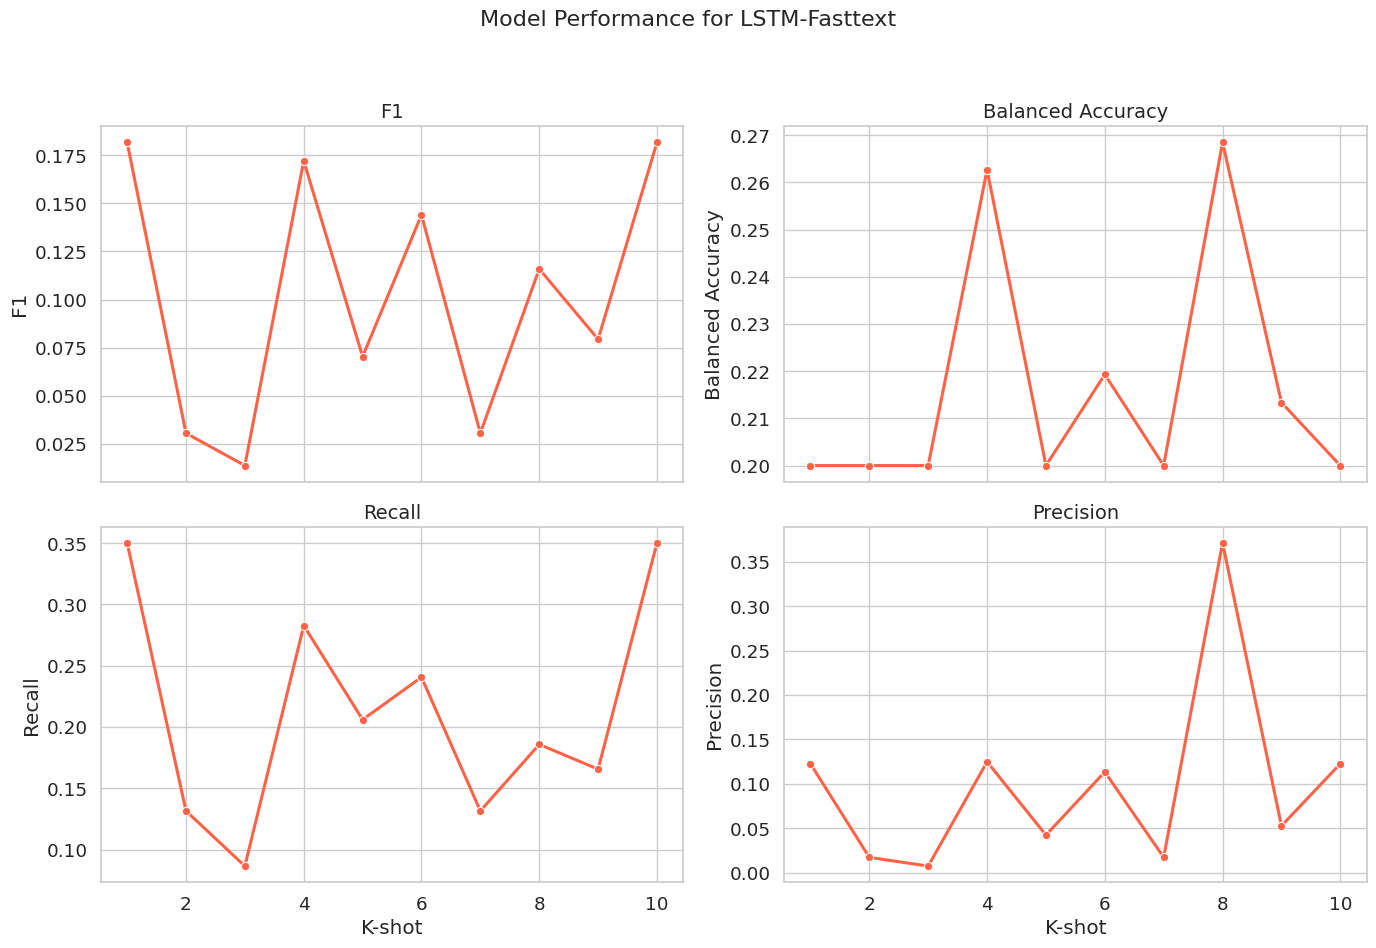

In [ ]:
# Plot results
plot_model_performance(df, "LSTM-Fasttext", "tomato")

Maximum values per metric:
Balanced Accuracy: 0.2685 (at K-shot = 8)
F1: 0.1817 (at K-shot = 1)
Recall: 0.3503 (at K-shot = 1)
Precision: 0.3714 (at K-shot = 8)


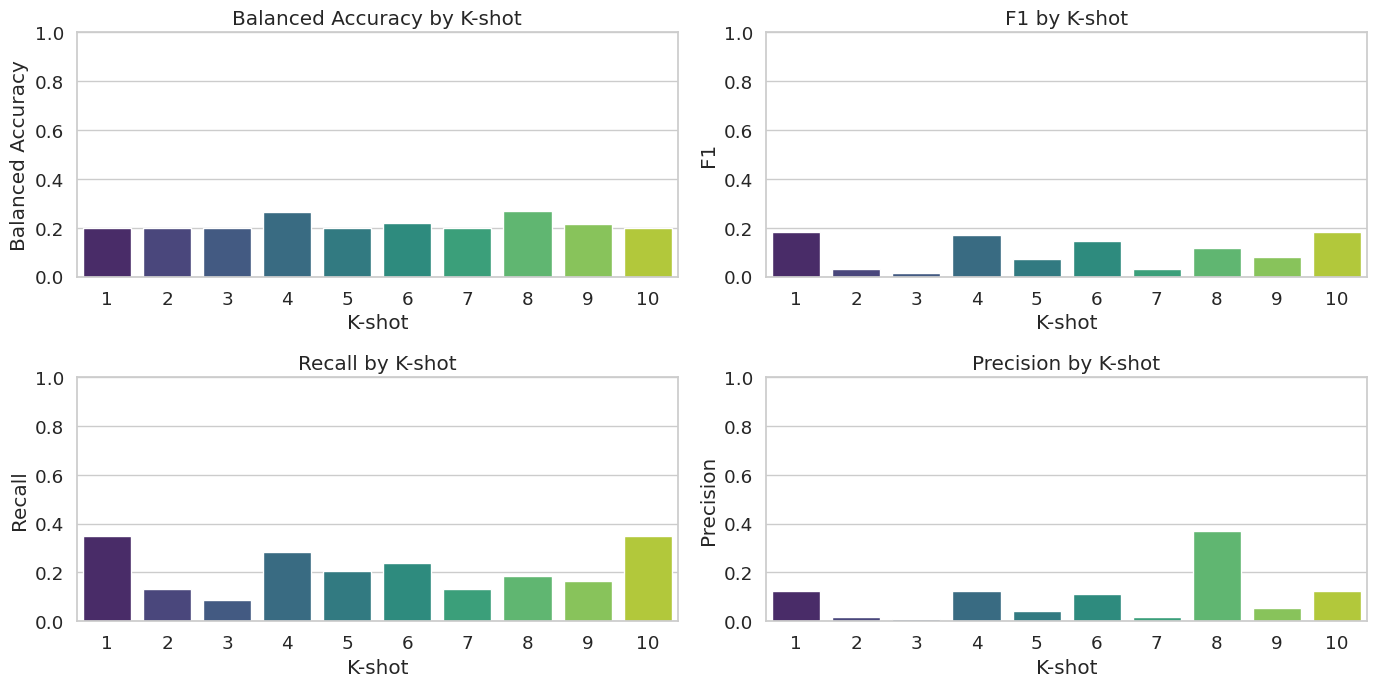

In [ ]:
metrics = ["Balanced Accuracy", "F1", "Recall", "Precision"]

# Print max values for each metric
print("Maximum values per metric:")
for metric in metrics:
    max_val = df[metric].max()
    max_k = df.loc[df[metric].idxmax(), "K-shot"]
    print(f"{metric}: {max_val:.4f} (at K-shot = {max_k})")

# Then plot the histograms
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x="K-shot", y=metric, data=df, palette="viridis")
    plt.title(f"{metric} by K-shot")
    plt.ylim(0, 1)
    plt.xlabel("K-shot")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# **VI. GRU + Bahdanau Attention using Glove (300d)**

#### **Few-Shot Learning**

In [ ]:
k_values = range(1, 11)  # Few-shot from k=1 to 10
NUM_CLASSES = 5
HIDDEN_DIM = 286
DROPOUT = 0.2

X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
X_combined_tensor = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_combined_tensor = torch.cat((y_train_tensor, y_val_tensor), dim=0)

model_metrics = {
    "K-shot": [],
    "Model": [],
    "Test Accuracy": [],
    "F1": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

patience = 15
num_epochs = 30
for k in k_values:
    print(f"\n--- K-Shot = {k} ---")

    X_few, y_few = get_few_shot_subset(X_combined_tensor, y_combined_tensor, k_shot=k)
    few_shot_dataset = TextDataset(X_few, y_few, raw_text_data=X_combined)
    few_shot_loader = DataLoader(few_shot_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    model = GRU_BahdanauAttention(
                embedding_matrix=embedding_matrix_glove,
                hidden_dim=HIDDEN_DIM,
                num_layers=NUM_LAYERS,
                dropout_prob=DROPOUT
            ).to(device)
    print(f"{count_parameters(model)} model parameters")
    print()
    print(model)

    learning_rate = 2e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Train with early stopping
    best_val_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, few_shot_loader, optimizer, loss_function, device)
        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

        print(f"K={k} | Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    avg_loss, avg_accuracy, f1, balanced_acc, recall, precision = test_epoch(model, test_loader, loss_function, device)

    # Log metrics
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    model_metrics["K-shot"].append(k)
    model_metrics["Model"].append("GRU-Glove")
    model_metrics["Test Accuracy"].append(avg_accuracy)
    model_metrics["F1"].append(f1)
    model_metrics["Balanced Accuracy"].append(balanced_acc)
    model_metrics["Recall"].append(recall)
    model_metrics["Precision"].append(precision)

# Convert results to DataFrame
df = pd.DataFrame(model_metrics)


--- K-Shot = 1 ---
7455937 model parameters

GRU_BahdanauAttention(
  (embedding): Embedding(20933, 300)
  (gru): GRU(300, 286, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=572, out_features=286, bias=True)
    (v): Linear(in_features=286, out_features=1, bias=False)
  )
  (fc): Linear(in_features=572, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=1 | Epoch 1/30 - Train Loss: 1.6016, Train Acc: 0.2000, Test Loss: 1.6146, Test Acc: 0.2025, Val F1: 0.0268
K=1 | Epoch 2/30 - Train Loss: 1.6027, Train Acc: 0.4000, Test Loss: 1.6142, Test Acc: 0.2032, Val F1: 0.0313
K=1 | Epoch 3/30 - Train Loss: 1.5984, Train Acc: 0.2000, Test Loss: 1.6138, Test Acc: 0.2033, Val F1: 0.0397
K=1 | Epoch 4/30 - Train Loss: 1.5962, Train Acc: 0.2000, Test Loss: 1.6132, Test Acc: 0.2095, Val F1: 0.0576
K=1 | Epoch 5/30 - Train Loss: 1.5932, Train Acc: 0.4000, Test Loss: 1.6128, Test Acc: 0.2138, Val F1: 0.0754
K=1 | Epoch 6/30 - Train Loss: 1.5899, Train Acc: 0.6000, Test Loss: 1.6125, Test Acc: 0.2201, Val F1: 0.0994
K=1 | Epoch 7/30 - Train Loss: 1.5894, Train Acc: 0.4000, Test Loss: 1.6122, Test Acc: 0.2228, Val F1: 0.1081
K=1 | Epoch 8/30 - Train Loss: 1.5833, Train Acc: 0.6000, Test Loss: 1.6119, Test Acc: 0.2342, Val F1: 0.1342
K=1 | Epoch 9/30 - Train Loss: 1.5847, Train Acc: 0.6000, Test Loss: 1.6114, Test Acc: 0.2312, Val F1: 0.1474
K=1 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=2 | Epoch 1/30 - Train Loss: 1.6067, Train Acc: 0.2000, Test Loss: 1.6072, Test Acc: 0.2000, Val F1: 0.0759
K=2 | Epoch 2/30 - Train Loss: 1.6060, Train Acc: 0.2000, Test Loss: 1.6072, Test Acc: 0.2000, Val F1: 0.0759
K=2 | Epoch 3/30 - Train Loss: 1.5991, Train Acc: 0.2000, Test Loss: 1.6075, Test Acc: 0.2000, Val F1: 0.0759
K=2 | Epoch 4/30 - Train Loss: 1.5950, Train Acc: 0.3000, Test Loss: 1.6075, Test Acc: 0.2000, Val F1: 0.0760
K=2 | Epoch 5/30 - Train Loss: 1.5886, Train Acc: 0.3000, Test Loss: 1.6078, Test Acc: 0.2011, Val F1: 0.0773
K=2 | Epoch 6/30 - Train Loss: 1.5903, Train Acc: 0.4000, Test Loss: 1.6079, Test Acc: 0.2033, Val F1: 0.0797
K=2 | Epoch 7/30 - Train Loss: 1.5845, Train Acc: 0.3000, Test Loss: 1.6080, Test Acc: 0.2028, Val F1: 0.0803
K=2 | Epoch 8/30 - Train Loss: 1.5831, Train Acc: 0.4000, Test Loss: 1.6081, Test Acc: 0.2007, Val F1: 0.0821
K=2 | Epoch 9/30 - Train Loss: 1.5786, Train Acc: 0.5000, Test Loss: 1.6083, Test Acc: 0.2046, Val F1: 0.0882
K=2 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=3 | Epoch 1/30 - Train Loss: 1.6090, Train Acc: 0.2000, Test Loss: 1.6106, Test Acc: 0.2000, Val F1: 0.0759
K=3 | Epoch 2/30 - Train Loss: 1.6076, Train Acc: 0.2000, Test Loss: 1.6107, Test Acc: 0.2000, Val F1: 0.0759
K=3 | Epoch 3/30 - Train Loss: 1.6032, Train Acc: 0.2000, Test Loss: 1.6108, Test Acc: 0.2000, Val F1: 0.0759
K=3 | Epoch 4/30 - Train Loss: 1.6044, Train Acc: 0.2000, Test Loss: 1.6108, Test Acc: 0.2000, Val F1: 0.0760
K=3 | Epoch 5/30 - Train Loss: 1.5923, Train Acc: 0.2667, Test Loss: 1.6109, Test Acc: 0.2011, Val F1: 0.0772
K=3 | Epoch 6/30 - Train Loss: 1.5955, Train Acc: 0.2667, Test Loss: 1.6110, Test Acc: 0.2022, Val F1: 0.0784
K=3 | Epoch 7/30 - Train Loss: 1.5951, Train Acc: 0.2000, Test Loss: 1.6111, Test Acc: 0.2033, Val F1: 0.0796
K=3 | Epoch 8/30 - Train Loss: 1.5919, Train Acc: 0.2667, Test Loss: 1.6111, Test Acc: 0.2039, Val F1: 0.0806
K=3 | Epoch 9/30 - Train Loss: 1.5870, Train Acc: 0.3333, Test Loss: 1.6111, Test Acc: 0.2038, Val F1: 0.0829
K=3 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=4 | Epoch 1/30 - Train Loss: 1.6146, Train Acc: 0.2000, Test Loss: 1.6100, Test Acc: 0.1788, Val F1: 0.0988
K=4 | Epoch 2/30 - Train Loss: 1.6006, Train Acc: 0.3000, Test Loss: 1.6095, Test Acc: 0.1926, Val F1: 0.1068
K=4 | Epoch 3/30 - Train Loss: 1.6024, Train Acc: 0.3000, Test Loss: 1.6092, Test Acc: 0.2012, Val F1: 0.0961
K=4 | Epoch 4/30 - Train Loss: 1.6061, Train Acc: 0.2500, Test Loss: 1.6087, Test Acc: 0.2066, Val F1: 0.1235
K=4 | Epoch 5/30 - Train Loss: 1.6002, Train Acc: 0.2500, Test Loss: 1.6088, Test Acc: 0.2068, Val F1: 0.1121
K=4 | Epoch 6/30 - Train Loss: 1.5945, Train Acc: 0.3000, Test Loss: 1.6085, Test Acc: 0.2100, Val F1: 0.1169
K=4 | Epoch 7/30 - Train Loss: 1.5962, Train Acc: 0.2500, Test Loss: 1.6080, Test Acc: 0.2190, Val F1: 0.1365
K=4 | Epoch 8/30 - Train Loss: 1.5942, Train Acc: 0.3000, Test Loss: 1.6081, Test Acc: 0.2178, Val F1: 0.1326
K=4 | Epoch 9/30 - Train Loss: 1.6017, Train Acc: 0.3000, Test Loss: 1.6074, Test Acc: 0.2221, Val F1: 0.1370
K=4 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=5 | Epoch 1/30 - Train Loss: 1.6100, Train Acc: 0.2000, Test Loss: 1.6153, Test Acc: 0.2100, Val F1: 0.0430
K=5 | Epoch 2/30 - Train Loss: 1.6101, Train Acc: 0.2400, Test Loss: 1.6143, Test Acc: 0.2221, Val F1: 0.0706
K=5 | Epoch 3/30 - Train Loss: 1.6028, Train Acc: 0.2800, Test Loss: 1.6138, Test Acc: 0.2322, Val F1: 0.0850
K=5 | Epoch 4/30 - Train Loss: 1.6024, Train Acc: 0.4000, Test Loss: 1.6127, Test Acc: 0.2483, Val F1: 0.1146
K=5 | Epoch 5/30 - Train Loss: 1.5962, Train Acc: 0.5600, Test Loss: 1.6118, Test Acc: 0.2725, Val F1: 0.1446
K=5 | Epoch 6/30 - Train Loss: 1.5920, Train Acc: 0.5200, Test Loss: 1.6112, Test Acc: 0.2698, Val F1: 0.1464
K=5 | Epoch 7/30 - Train Loss: 1.5934, Train Acc: 0.4400, Test Loss: 1.6105, Test Acc: 0.2809, Val F1: 0.1549
K=5 | Epoch 8/30 - Train Loss: 1.5931, Train Acc: 0.4000, Test Loss: 1.6100, Test Acc: 0.2882, Val F1: 0.1651
K=5 | Epoch 9/30 - Train Loss: 1.5900, Train Acc: 0.5200, Test Loss: 1.6095, Test Acc: 0.2881, Val F1: 0.1691
K=5 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=6 | Epoch 1/30 - Train Loss: 1.6099, Train Acc: 0.1667, Test Loss: 1.6036, Test Acc: 0.2297, Val F1: 0.2269
K=6 | Epoch 2/30 - Train Loss: 1.6063, Train Acc: 0.2667, Test Loss: 1.6034, Test Acc: 0.2334, Val F1: 0.2240
K=6 | Epoch 3/30 - Train Loss: 1.6055, Train Acc: 0.2667, Test Loss: 1.6032, Test Acc: 0.2257, Val F1: 0.2036
K=6 | Epoch 4/30 - Train Loss: 1.6024, Train Acc: 0.2667, Test Loss: 1.6029, Test Acc: 0.2247, Val F1: 0.1938
K=6 | Epoch 5/30 - Train Loss: 1.6015, Train Acc: 0.2333, Test Loss: 1.6026, Test Acc: 0.2254, Val F1: 0.1881
K=6 | Epoch 6/30 - Train Loss: 1.5987, Train Acc: 0.3000, Test Loss: 1.6023, Test Acc: 0.2231, Val F1: 0.1754
K=6 | Epoch 7/30 - Train Loss: 1.5936, Train Acc: 0.3333, Test Loss: 1.6021, Test Acc: 0.2155, Val F1: 0.1597
K=6 | Epoch 8/30 - Train Loss: 1.5944, Train Acc: 0.2667, Test Loss: 1.6019, Test Acc: 0.2165, Val F1: 0.1567
K=6 | Epoch 9/30 - Train Loss: 1.5925, Train Acc: 0.2333, Test Loss: 1.6015, Test Acc: 0.2183, Val F1: 0.1488
K=6 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=7 | Epoch 1/30 - Train Loss: 1.6056, Train Acc: 0.1429, Test Loss: 1.6003, Test Acc: 0.1953, Val F1: 0.1212
K=7 | Epoch 2/30 - Train Loss: 1.6113, Train Acc: 0.2286, Test Loss: 1.6000, Test Acc: 0.1937, Val F1: 0.1321
K=7 | Epoch 3/30 - Train Loss: 1.6220, Train Acc: 0.3143, Test Loss: 1.6006, Test Acc: 0.1953, Val F1: 0.1442
K=7 | Epoch 4/30 - Train Loss: 1.6201, Train Acc: 0.2000, Test Loss: 1.6010, Test Acc: 0.1995, Val F1: 0.1341
K=7 | Epoch 5/30 - Train Loss: 1.6065, Train Acc: 0.2571, Test Loss: 1.6005, Test Acc: 0.2022, Val F1: 0.1530
K=7 | Epoch 6/30 - Train Loss: 1.6082, Train Acc: 0.3429, Test Loss: 1.6003, Test Acc: 0.2142, Val F1: 0.1705
K=7 | Epoch 7/30 - Train Loss: 1.6021, Train Acc: 0.4000, Test Loss: 1.6001, Test Acc: 0.2284, Val F1: 0.1751
K=7 | Epoch 8/30 - Train Loss: 1.6057, Train Acc: 0.3714, Test Loss: 1.6001, Test Acc: 0.2493, Val F1: 0.2029
K=7 | Epoch 9/30 - Train Loss: 1.5937, Train Acc: 0.4286, Test Loss: 1.5992, Test Acc: 0.2416, Val F1: 0.2222
K=7 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=8 | Epoch 1/30 - Train Loss: 1.6071, Train Acc: 0.2250, Test Loss: 1.6111, Test Acc: 0.1934, Val F1: 0.0237
K=8 | Epoch 2/30 - Train Loss: 1.6059, Train Acc: 0.2250, Test Loss: 1.6113, Test Acc: 0.1983, Val F1: 0.0231
K=8 | Epoch 3/30 - Train Loss: 1.6035, Train Acc: 0.2500, Test Loss: 1.6112, Test Acc: 0.2000, Val F1: 0.0222
K=8 | Epoch 4/30 - Train Loss: 1.6071, Train Acc: 0.2250, Test Loss: 1.6106, Test Acc: 0.1978, Val F1: 0.0241
K=8 | Epoch 5/30 - Train Loss: 1.6086, Train Acc: 0.2000, Test Loss: 1.6102, Test Acc: 0.1988, Val F1: 0.0264
K=8 | Epoch 6/30 - Train Loss: 1.5987, Train Acc: 0.2250, Test Loss: 1.6100, Test Acc: 0.2005, Val F1: 0.0233
K=8 | Epoch 7/30 - Train Loss: 1.6018, Train Acc: 0.2500, Test Loss: 1.6094, Test Acc: 0.2000, Val F1: 0.0222
K=8 | Epoch 8/30 - Train Loss: 1.6015, Train Acc: 0.2500, Test Loss: 1.6084, Test Acc: 0.1994, Val F1: 0.0232
K=8 | Epoch 9/30 - Train Loss: 1.5955, Train Acc: 0.2000, Test Loss: 1.6080, Test Acc: 0.2010, Val F1: 0.0287
K=8 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=9 | Epoch 1/30 - Train Loss: 1.6101, Train Acc: 0.2000, Test Loss: 1.6128, Test Acc: 0.2000, Val F1: 0.0340
K=9 | Epoch 2/30 - Train Loss: 1.6104, Train Acc: 0.2000, Test Loss: 1.6122, Test Acc: 0.2000, Val F1: 0.0340
K=9 | Epoch 3/30 - Train Loss: 1.6072, Train Acc: 0.2222, Test Loss: 1.6119, Test Acc: 0.1992, Val F1: 0.0339
K=9 | Epoch 4/30 - Train Loss: 1.6053, Train Acc: 0.2222, Test Loss: 1.6117, Test Acc: 0.2013, Val F1: 0.0385
K=9 | Epoch 5/30 - Train Loss: 1.6023, Train Acc: 0.2222, Test Loss: 1.6113, Test Acc: 0.2045, Val F1: 0.0451
K=9 | Epoch 6/30 - Train Loss: 1.6001, Train Acc: 0.2444, Test Loss: 1.6112, Test Acc: 0.2059, Val F1: 0.0491
K=9 | Epoch 7/30 - Train Loss: 1.6011, Train Acc: 0.2444, Test Loss: 1.6108, Test Acc: 0.2096, Val F1: 0.0558
K=9 | Epoch 8/30 - Train Loss: 1.5980, Train Acc: 0.2889, Test Loss: 1.6106, Test Acc: 0.2169, Val F1: 0.0689
K=9 | Epoch 9/30 - Train Loss: 1.5960, Train Acc: 0.2889, Test Loss: 1.6103, Test Acc: 0.2206, Val F1: 0.0739
K=9 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=10 | Epoch 1/30 - Train Loss: 1.6084, Train Acc: 0.2000, Test Loss: 1.6037, Test Acc: 0.2933, Val F1: 0.2971
K=10 | Epoch 2/30 - Train Loss: 1.6048, Train Acc: 0.2800, Test Loss: 1.6034, Test Acc: 0.2557, Val F1: 0.1819
K=10 | Epoch 3/30 - Train Loss: 1.6064, Train Acc: 0.2600, Test Loss: 1.6027, Test Acc: 0.2627, Val F1: 0.1747
K=10 | Epoch 4/30 - Train Loss: 1.6133, Train Acc: 0.2400, Test Loss: 1.6036, Test Acc: 0.2630, Val F1: 0.1759
K=10 | Epoch 5/30 - Train Loss: 1.6053, Train Acc: 0.3000, Test Loss: 1.6035, Test Acc: 0.2503, Val F1: 0.1613
K=10 | Epoch 6/30 - Train Loss: 1.6004, Train Acc: 0.3600, Test Loss: 1.6022, Test Acc: 0.2645, Val F1: 0.1960
K=10 | Epoch 7/30 - Train Loss: 1.5968, Train Acc: 0.3600, Test Loss: 1.6022, Test Acc: 0.2498, Val F1: 0.1657
K=10 | Epoch 8/30 - Train Loss: 1.6033, Train Acc: 0.2800, Test Loss: 1.6012, Test Acc: 0.2804, Val F1: 0.2245
K=10 | Epoch 9/30 - Train Loss: 1.5976, Train Acc: 0.3600, Test Loss: 1.6004, Test Acc: 0.2655, Val F1: 0.2085
K

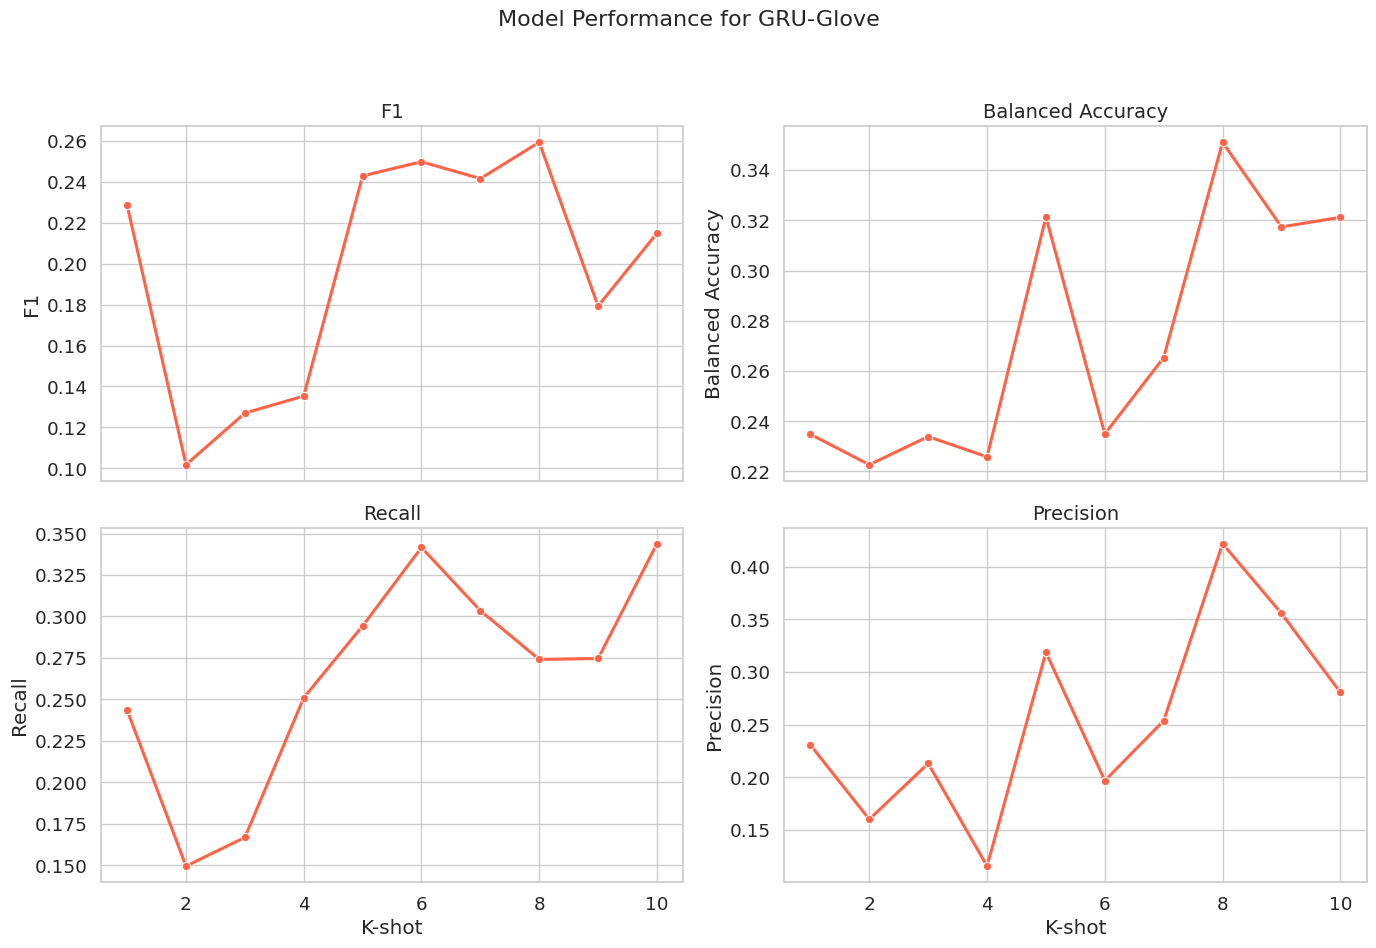

In [ ]:
# Plot results
plot_model_performance(df, "GRU-Glove", "tomato")

Maximum values per metric:
Balanced Accuracy: 0.3511 (at K-shot = 8)
F1: 0.2592 (at K-shot = 8)
Recall: 0.3439 (at K-shot = 10)
Precision: 0.4220 (at K-shot = 8)


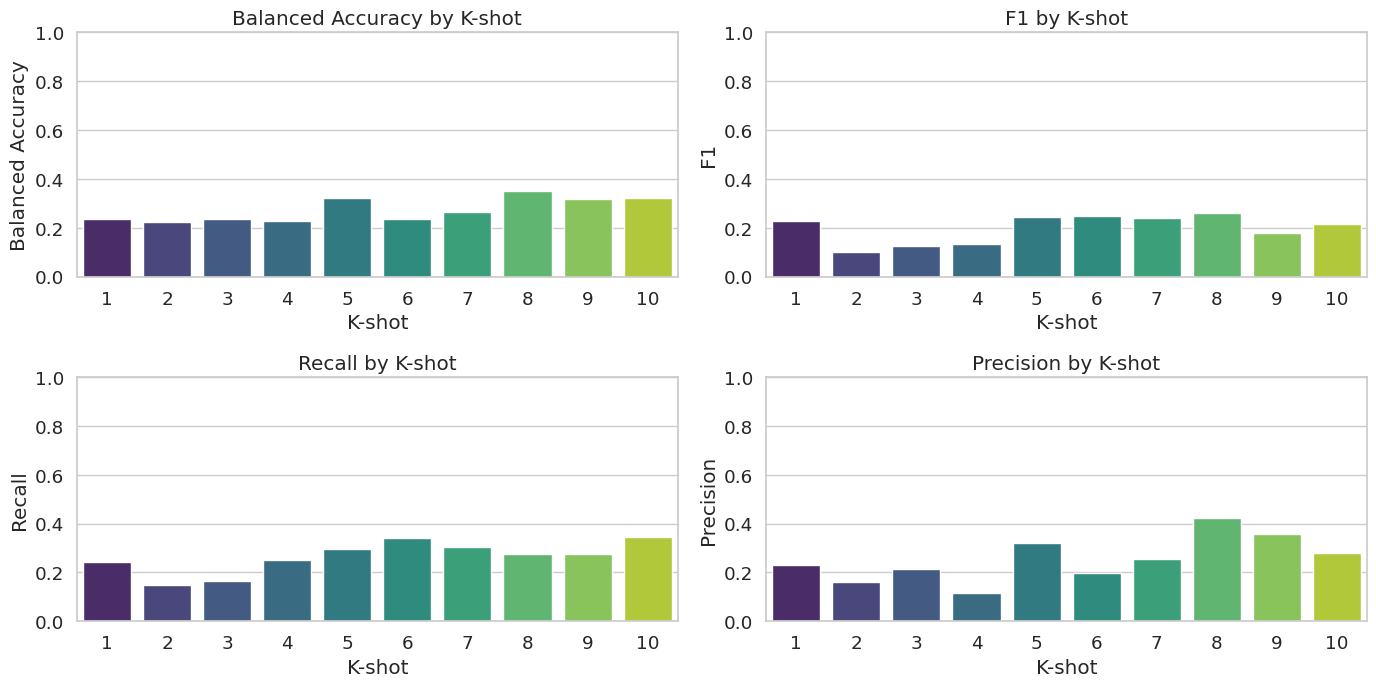

In [ ]:
metrics = ["Balanced Accuracy", "F1", "Recall", "Precision"]

# Print max values for each metric
print("Maximum values per metric:")
for metric in metrics:
    max_val = df[metric].max()
    max_k = df.loc[df[metric].idxmax(), "K-shot"]
    print(f"{metric}: {max_val:.4f} (at K-shot = {max_k})")

# Then plot the histograms
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x="K-shot", y=metric, data=df, palette="viridis")
    plt.title(f"{metric} by K-shot")
    plt.ylim(0, 1)
    plt.xlabel("K-shot")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# **VII. LSTM + Bahdanau Attention using Glove (300d)**

#### **Few-Shot Learning**

In [ ]:
k_values = range(1, 11)  # Few-shot from k=1 to 10
NUM_CLASSES = 5
HIDDEN_DIM = 286
DROPOUT = 0.2

X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
X_combined_tensor = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_combined_tensor = torch.cat((y_train_tensor, y_val_tensor), dim=0)

model_metrics = {
    "K-shot": [],
    "Model": [],
    "Test Accuracy": [],
    "F1": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

patience = 15
num_epochs = 30
for k in k_values:
    print(f"\n--- K-Shot = {k} ---")

    X_few, y_few = get_few_shot_subset(X_combined_tensor, y_combined_tensor, k_shot=k)
    few_shot_dataset = TextDataset(X_few, y_few, raw_text_data=X_combined)
    few_shot_loader = DataLoader(few_shot_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    model = LSTM_BahdanauAttention(
                embedding_matrix=embedding_matrix_glove,
                hidden_dim=HIDDEN_DIM,
                num_layers=NUM_LAYERS,
                dropout_prob=DROPOUT
            ).to(device)
    print(f"{count_parameters(model)} model parameters")
    print()
    print(model)

    learning_rate = 2e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Train with early stopping
    best_val_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, few_shot_loader, optimizer, loss_function, device)
        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

        print(f"K={k} | Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    avg_loss, avg_accuracy, f1, balanced_acc, recall, precision = test_epoch(model, test_loader, loss_function, device)

    # Log metrics
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    model_metrics["K-shot"].append(k)
    model_metrics["Model"].append("LSTM-Glove")
    model_metrics["Test Accuracy"].append(avg_accuracy)
    model_metrics["F1"].append(f1)
    model_metrics["Balanced Accuracy"].append(balanced_acc)
    model_metrics["Recall"].append(recall)
    model_metrics["Precision"].append(precision)

# Convert results to DataFrame
df = pd.DataFrame(model_metrics)


--- K-Shot = 1 ---
7792273 model parameters

LSTM_BahdanauAttention(
  (embedding): Embedding(20933, 300)
  (lstm): LSTM(300, 286, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=572, out_features=286, bias=True)
    (v): Linear(in_features=286, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=572, out_features=5, bias=True)
)


/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=1 | Epoch 1/30 - Train Loss: 1.6105, Train Acc: 0.2000, Test Loss: 1.6043, Test Acc: 0.1998, Val F1: 0.1600
K=1 | Epoch 2/30 - Train Loss: 1.6030, Train Acc: 0.2000, Test Loss: 1.6045, Test Acc: 0.2008, Val F1: 0.1624
K=1 | Epoch 3/30 - Train Loss: 1.5986, Train Acc: 0.4000, Test Loss: 1.6046, Test Acc: 0.2008, Val F1: 0.1623
K=1 | Epoch 4/30 - Train Loss: 1.5965, Train Acc: 0.2000, Test Loss: 1.6048, Test Acc: 0.2009, Val F1: 0.1647
K=1 | Epoch 5/30 - Train Loss: 1.5910, Train Acc: 0.6000, Test Loss: 1.6049, Test Acc: 0.2011, Val F1: 0.1657
K=1 | Epoch 6/30 - Train Loss: 1.5917, Train Acc: 0.2000, Test Loss: 1.6050, Test Acc: 0.2027, Val F1: 0.1708
K=1 | Epoch 7/30 - Train Loss: 1.5937, Train Acc: 0.4000, Test Loss: 1.6053, Test Acc: 0.2033, Val F1: 0.1745
K=1 | Epoch 8/30 - Train Loss: 1.5897, Train Acc: 0.4000, Test Loss: 1.6055, Test Acc: 0.2052, Val F1: 0.1820
K=1 | Epoch 9/30 - Train Loss: 1.5789, Train Acc: 0.6000, Test Loss: 1.6057, Test Acc: 0.2103, Val F1: 0.1918
K=1 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=2 | Epoch 1/30 - Train Loss: 1.6092, Train Acc: 0.2000, Test Loss: 1.6062, Test Acc: 0.2005, Val F1: 0.0799
K=2 | Epoch 2/30 - Train Loss: 1.6052, Train Acc: 0.2000, Test Loss: 1.6060, Test Acc: 0.2022, Val F1: 0.0835
K=2 | Epoch 3/30 - Train Loss: 1.6043, Train Acc: 0.3000, Test Loss: 1.6060, Test Acc: 0.2027, Val F1: 0.0847
K=2 | Epoch 4/30 - Train Loss: 1.6027, Train Acc: 0.1000, Test Loss: 1.6061, Test Acc: 0.2027, Val F1: 0.0847
K=2 | Epoch 5/30 - Train Loss: 1.6009, Train Acc: 0.3000, Test Loss: 1.6060, Test Acc: 0.2032, Val F1: 0.0859
K=2 | Epoch 6/30 - Train Loss: 1.5990, Train Acc: 0.5000, Test Loss: 1.6059, Test Acc: 0.2057, Val F1: 0.0917
K=2 | Epoch 7/30 - Train Loss: 1.5975, Train Acc: 0.4000, Test Loss: 1.6058, Test Acc: 0.2063, Val F1: 0.0937
K=2 | Epoch 8/30 - Train Loss: 1.5973, Train Acc: 0.3000, Test Loss: 1.6057, Test Acc: 0.2079, Val F1: 0.0978
K=2 | Epoch 9/30 - Train Loss: 1.6001, Train Acc: 0.4000, Test Loss: 1.6057, Test Acc: 0.2095, Val F1: 0.1009
K=2 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=3 | Epoch 1/30 - Train Loss: 1.6094, Train Acc: 0.2000, Test Loss: 1.6006, Test Acc: 0.2000, Val F1: 0.1570
K=3 | Epoch 2/30 - Train Loss: 1.6047, Train Acc: 0.2000, Test Loss: 1.6003, Test Acc: 0.2000, Val F1: 0.1570
K=3 | Epoch 3/30 - Train Loss: 1.6059, Train Acc: 0.2000, Test Loss: 1.6003, Test Acc: 0.2000, Val F1: 0.1570
K=3 | Epoch 4/30 - Train Loss: 1.6037, Train Acc: 0.2000, Test Loss: 1.6002, Test Acc: 0.2000, Val F1: 0.1570
K=3 | Epoch 5/30 - Train Loss: 1.6017, Train Acc: 0.2000, Test Loss: 1.6001, Test Acc: 0.2000, Val F1: 0.1570
K=3 | Epoch 6/30 - Train Loss: 1.6035, Train Acc: 0.2000, Test Loss: 1.6000, Test Acc: 0.2000, Val F1: 0.1570
K=3 | Epoch 7/30 - Train Loss: 1.5957, Train Acc: 0.2000, Test Loss: 1.5999, Test Acc: 0.2000, Val F1: 0.1570
K=3 | Epoch 8/30 - Train Loss: 1.5999, Train Acc: 0.2000, Test Loss: 1.5998, Test Acc: 0.2005, Val F1: 0.1582
K=3 | Epoch 9/30 - Train Loss: 1.6005, Train Acc: 0.2000, Test Loss: 1.5996, Test Acc: 0.2005, Val F1: 0.1582
K=3 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=4 | Epoch 1/30 - Train Loss: 1.6336, Train Acc: 0.2000, Test Loss: 1.6056, Test Acc: 0.2013, Val F1: 0.0599
K=4 | Epoch 2/30 - Train Loss: 1.6102, Train Acc: 0.3000, Test Loss: 1.6049, Test Acc: 0.2174, Val F1: 0.0985
K=4 | Epoch 3/30 - Train Loss: 1.5952, Train Acc: 0.3500, Test Loss: 1.6048, Test Acc: 0.2245, Val F1: 0.1093
K=4 | Epoch 4/30 - Train Loss: 1.6128, Train Acc: 0.2500, Test Loss: 1.6051, Test Acc: 0.2260, Val F1: 0.1120
K=4 | Epoch 5/30 - Train Loss: 1.6032, Train Acc: 0.2000, Test Loss: 1.6050, Test Acc: 0.2276, Val F1: 0.1124
K=4 | Epoch 6/30 - Train Loss: 1.5995, Train Acc: 0.3000, Test Loss: 1.6053, Test Acc: 0.2253, Val F1: 0.1116
K=4 | Epoch 7/30 - Train Loss: 1.5949, Train Acc: 0.3000, Test Loss: 1.6048, Test Acc: 0.2142, Val F1: 0.1048
K=4 | Epoch 8/30 - Train Loss: 1.5804, Train Acc: 0.3500, Test Loss: 1.6049, Test Acc: 0.2160, Val F1: 0.1057
K=4 | Epoch 9/30 - Train Loss: 1.6166, Train Acc: 0.3000, Test Loss: 1.6056, Test Acc: 0.2154, Val F1: 0.1051
K=4 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=5 | Epoch 1/30 - Train Loss: 1.6086, Train Acc: 0.2000, Test Loss: 1.6010, Test Acc: 0.2000, Val F1: 0.1570
K=5 | Epoch 2/30 - Train Loss: 1.6022, Train Acc: 0.2000, Test Loss: 1.6008, Test Acc: 0.1996, Val F1: 0.1568
K=5 | Epoch 3/30 - Train Loss: 1.6019, Train Acc: 0.2000, Test Loss: 1.6007, Test Acc: 0.2007, Val F1: 0.1583
K=5 | Epoch 4/30 - Train Loss: 1.6002, Train Acc: 0.2800, Test Loss: 1.6007, Test Acc: 0.1993, Val F1: 0.1578
K=5 | Epoch 5/30 - Train Loss: 1.5954, Train Acc: 0.2400, Test Loss: 1.6005, Test Acc: 0.2027, Val F1: 0.1622
K=5 | Epoch 6/30 - Train Loss: 1.5981, Train Acc: 0.2800, Test Loss: 1.6004, Test Acc: 0.2024, Val F1: 0.1630
K=5 | Epoch 7/30 - Train Loss: 1.5970, Train Acc: 0.2400, Test Loss: 1.6003, Test Acc: 0.2049, Val F1: 0.1653
K=5 | Epoch 8/30 - Train Loss: 1.5990, Train Acc: 0.2400, Test Loss: 1.6004, Test Acc: 0.2047, Val F1: 0.1660
K=5 | Epoch 9/30 - Train Loss: 1.5958, Train Acc: 0.3200, Test Loss: 1.6006, Test Acc: 0.2027, Val F1: 0.1648
K=5 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=6 | Epoch 1/30 - Train Loss: 1.6093, Train Acc: 0.2333, Test Loss: 1.6097, Test Acc: 0.2026, Val F1: 0.0773
K=6 | Epoch 2/30 - Train Loss: 1.6049, Train Acc: 0.3333, Test Loss: 1.6089, Test Acc: 0.2116, Val F1: 0.1117
K=6 | Epoch 3/30 - Train Loss: 1.6069, Train Acc: 0.3333, Test Loss: 1.6082, Test Acc: 0.2171, Val F1: 0.1468
K=6 | Epoch 4/30 - Train Loss: 1.6047, Train Acc: 0.3000, Test Loss: 1.6077, Test Acc: 0.2287, Val F1: 0.1749
K=6 | Epoch 5/30 - Train Loss: 1.6021, Train Acc: 0.4667, Test Loss: 1.6071, Test Acc: 0.2399, Val F1: 0.2081
K=6 | Epoch 6/30 - Train Loss: 1.6030, Train Acc: 0.4667, Test Loss: 1.6066, Test Acc: 0.2569, Val F1: 0.2477
K=6 | Epoch 7/30 - Train Loss: 1.6013, Train Acc: 0.4000, Test Loss: 1.6061, Test Acc: 0.2719, Val F1: 0.2831
K=6 | Epoch 8/30 - Train Loss: 1.5989, Train Acc: 0.5333, Test Loss: 1.6057, Test Acc: 0.2813, Val F1: 0.2980
K=6 | Epoch 9/30 - Train Loss: 1.5978, Train Acc: 0.5667, Test Loss: 1.6052, Test Acc: 0.3028, Val F1: 0.3274
K=6 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=7 | Epoch 1/30 - Train Loss: 1.6131, Train Acc: 0.1429, Test Loss: 1.6056, Test Acc: 0.2018, Val F1: 0.1691
K=7 | Epoch 2/30 - Train Loss: 1.6072, Train Acc: 0.2857, Test Loss: 1.6047, Test Acc: 0.2015, Val F1: 0.1642
K=7 | Epoch 3/30 - Train Loss: 1.6055, Train Acc: 0.2000, Test Loss: 1.6048, Test Acc: 0.2618, Val F1: 0.2532
K=7 | Epoch 4/30 - Train Loss: 1.6027, Train Acc: 0.3429, Test Loss: 1.6041, Test Acc: 0.2626, Val F1: 0.2493
K=7 | Epoch 5/30 - Train Loss: 1.6031, Train Acc: 0.3143, Test Loss: 1.6039, Test Acc: 0.2591, Val F1: 0.2527
K=7 | Epoch 6/30 - Train Loss: 1.5995, Train Acc: 0.3429, Test Loss: 1.6034, Test Acc: 0.2648, Val F1: 0.2492
K=7 | Epoch 7/30 - Train Loss: 1.5979, Train Acc: 0.3714, Test Loss: 1.6031, Test Acc: 0.2592, Val F1: 0.2384
K=7 | Epoch 8/30 - Train Loss: 1.6038, Train Acc: 0.2857, Test Loss: 1.6026, Test Acc: 0.2660, Val F1: 0.2526
K=7 | Epoch 9/30 - Train Loss: 1.6022, Train Acc: 0.3143, Test Loss: 1.6024, Test Acc: 0.2459, Val F1: 0.2174
K=7 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=8 | Epoch 1/30 - Train Loss: 1.6112, Train Acc: 0.1250, Test Loss: 1.6076, Test Acc: 0.2542, Val F1: 0.2545
K=8 | Epoch 2/30 - Train Loss: 1.6081, Train Acc: 0.1500, Test Loss: 1.6068, Test Acc: 0.2645, Val F1: 0.2617
K=8 | Epoch 3/30 - Train Loss: 1.6077, Train Acc: 0.2250, Test Loss: 1.6068, Test Acc: 0.2574, Val F1: 0.2212
K=8 | Epoch 4/30 - Train Loss: 1.6059, Train Acc: 0.2750, Test Loss: 1.6070, Test Acc: 0.2591, Val F1: 0.1945
K=8 | Epoch 5/30 - Train Loss: 1.6060, Train Acc: 0.2750, Test Loss: 1.6070, Test Acc: 0.2841, Val F1: 0.2167
K=8 | Epoch 6/30 - Train Loss: 1.6043, Train Acc: 0.4250, Test Loss: 1.6067, Test Acc: 0.3382, Val F1: 0.2892
K=8 | Epoch 7/30 - Train Loss: 1.6035, Train Acc: 0.4000, Test Loss: 1.6064, Test Acc: 0.3814, Val F1: 0.3503
K=8 | Epoch 8/30 - Train Loss: 1.6021, Train Acc: 0.4750, Test Loss: 1.6062, Test Acc: 0.3675, Val F1: 0.3063
K=8 | Epoch 9/30 - Train Loss: 1.5991, Train Acc: 0.5250, Test Loss: 1.6059, Test Acc: 0.3557, Val F1: 0.2962
K=8 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=9 | Epoch 1/30 - Train Loss: 1.6125, Train Acc: 0.1333, Test Loss: 1.6012, Test Acc: 0.2104, Val F1: 0.2031
K=9 | Epoch 2/30 - Train Loss: 1.6080, Train Acc: 0.2444, Test Loss: 1.6006, Test Acc: 0.2254, Val F1: 0.2208
K=9 | Epoch 3/30 - Train Loss: 1.6067, Train Acc: 0.2222, Test Loss: 1.6001, Test Acc: 0.2344, Val F1: 0.2297
K=9 | Epoch 4/30 - Train Loss: 1.6059, Train Acc: 0.2222, Test Loss: 1.5997, Test Acc: 0.2418, Val F1: 0.2368
K=9 | Epoch 5/30 - Train Loss: 1.6046, Train Acc: 0.2000, Test Loss: 1.5994, Test Acc: 0.2493, Val F1: 0.2429
K=9 | Epoch 6/30 - Train Loss: 1.6048, Train Acc: 0.1778, Test Loss: 1.5990, Test Acc: 0.2450, Val F1: 0.2427
K=9 | Epoch 7/30 - Train Loss: 1.6024, Train Acc: 0.2222, Test Loss: 1.5986, Test Acc: 0.2482, Val F1: 0.2459
K=9 | Epoch 8/30 - Train Loss: 1.5998, Train Acc: 0.2667, Test Loss: 1.5982, Test Acc: 0.2493, Val F1: 0.2484
K=9 | Epoch 9/30 - Train Loss: 1.6031, Train Acc: 0.1778, Test Loss: 1.5979, Test Acc: 0.2514, Val F1: 0.2510
K=9 | Epoc

/tmp/ipython-input-912490951.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
/tmp/ipython-input-912490951.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


K=10 | Epoch 1/30 - Train Loss: 1.6116, Train Acc: 0.2600, Test Loss: 1.6046, Test Acc: 0.2662, Val F1: 0.1905
K=10 | Epoch 2/30 - Train Loss: 1.6019, Train Acc: 0.3600, Test Loss: 1.6037, Test Acc: 0.2892, Val F1: 0.1930
K=10 | Epoch 3/30 - Train Loss: 1.5979, Train Acc: 0.3600, Test Loss: 1.6033, Test Acc: 0.2757, Val F1: 0.1868
K=10 | Epoch 4/30 - Train Loss: 1.6087, Train Acc: 0.3600, Test Loss: 1.6035, Test Acc: 0.2836, Val F1: 0.1926
K=10 | Epoch 5/30 - Train Loss: 1.5960, Train Acc: 0.3400, Test Loss: 1.6028, Test Acc: 0.2892, Val F1: 0.1934
K=10 | Epoch 6/30 - Train Loss: 1.5995, Train Acc: 0.3600, Test Loss: 1.6027, Test Acc: 0.2930, Val F1: 0.1930
K=10 | Epoch 7/30 - Train Loss: 1.6028, Train Acc: 0.3600, Test Loss: 1.6020, Test Acc: 0.2939, Val F1: 0.1930
K=10 | Epoch 8/30 - Train Loss: 1.5976, Train Acc: 0.4000, Test Loss: 1.6016, Test Acc: 0.2738, Val F1: 0.1788
K=10 | Epoch 9/30 - Train Loss: 1.5787, Train Acc: 0.3400, Test Loss: 1.6008, Test Acc: 0.2542, Val F1: 0.1634
K

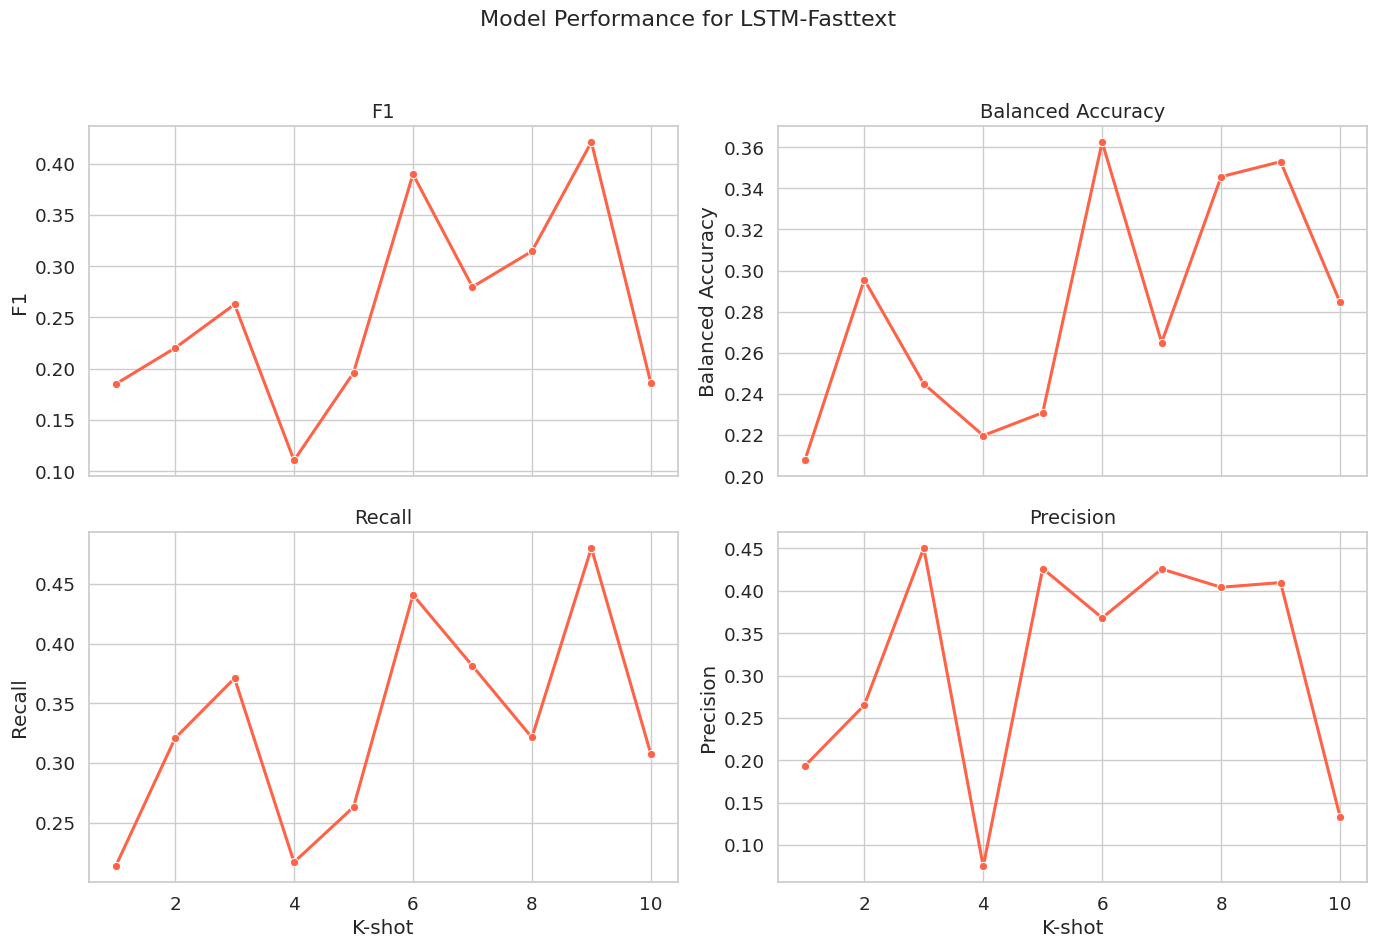

In [ ]:
# Plot results
plot_model_performance(df, "LSTM-Glove", "tomato")

Maximum values per metric:
Balanced Accuracy: 0.3625 (at K-shot = 6)
F1: 0.4211 (at K-shot = 9)
Recall: 0.4801 (at K-shot = 9)
Precision: 0.4506 (at K-shot = 3)


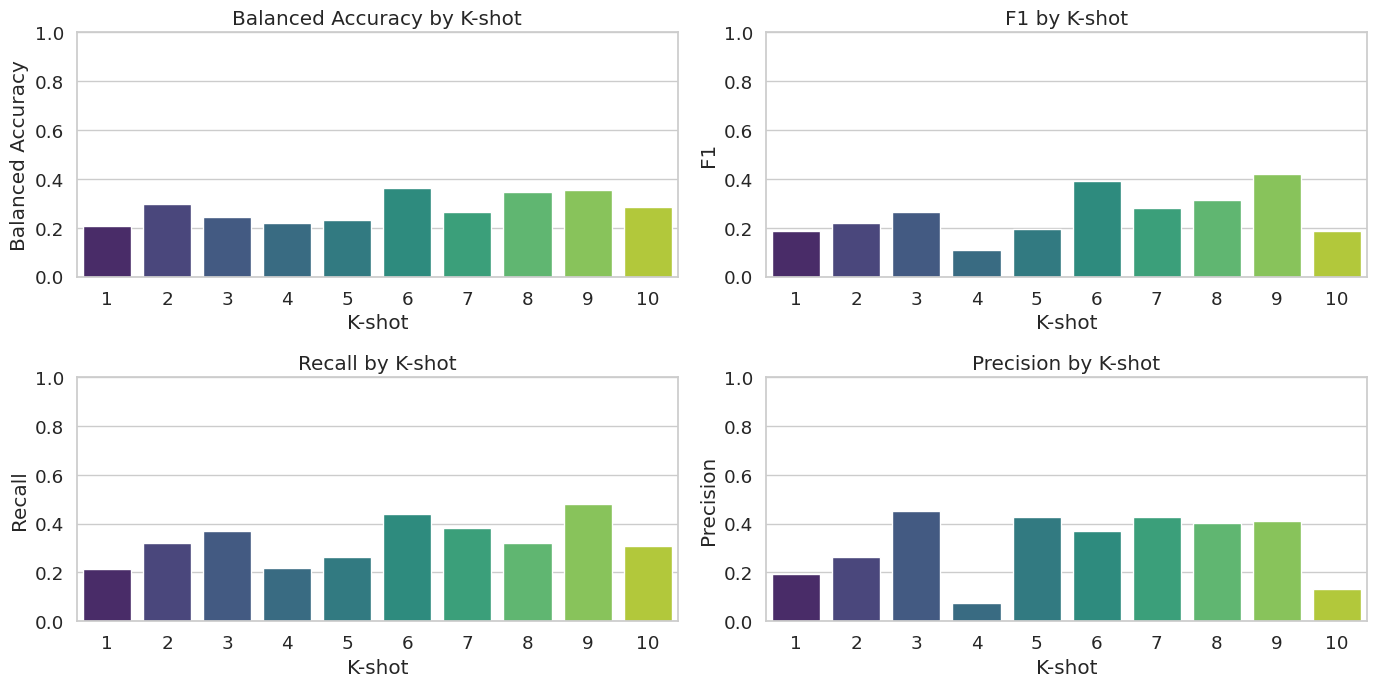

In [ ]:
metrics = ["Balanced Accuracy", "F1", "Recall", "Precision"]

# Print max values for each metric
print("Maximum values per metric:")
for metric in metrics:
    max_val = df[metric].max()
    max_k = df.loc[df[metric].idxmax(), "K-shot"]
    print(f"{metric}: {max_val:.4f} (at K-shot = {max_k})")

# Then plot the histograms
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x="K-shot", y=metric, data=df, palette="viridis")
    plt.title(f"{metric} by K-shot")
    plt.ylim(0, 1)
    plt.xlabel("K-shot")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()